# Projet 7 : Détecter les bads buzz grâce au Deep Learning - Air Paradis

- Problématique : Air Paradis a besoin de détecter les mauvais tweet afin de pouvoir agir rapidement.

Il faut ainsi développer un produit IA en utilisant 3 approches : 
- approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment sur un échantillon des données
- approche “Modèle sur mesure simple” en utilisant le Concepteur / Designer d’un service Azure Machine Learning, interface graphique drag & drop, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet qui sera présenté à Air Paradis

Les données utilisées sont des données opensource provenant de ce lien : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip

Import des bibliothèques

In [221]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
from gensim.models.ldamodel import LdaModel
from  sklearn.feature_extraction.text  import CountVectorizer 
from sklearn.decomposition import SparsePCA
import gensim.downloader as api
import gc
import time
from contextlib import contextmanager
from sklearn import cluster
import warnings
from dotenv import load_dotenv
from emot.emo_unicode import EMOTICONS_EMO# For EMOTICONS
from spacy.tokens import Token
import re
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn import metrics
from sklearn import manifold, decomposition
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer
from spacy.language import Language
import spacy
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from functools import partial
from gensim.models import FastText  
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import tensorflow as tf
#Load Packages
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Bidirectional
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding
import mlflow
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import joblib


warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [4]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [5]:
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Collecte des données

### Import des données

In [45]:
df = pd.read_csv('input/base.csv', encoding='latin-1', header=None)

In [46]:
df.shape

(1600000, 6)

In [47]:
df.head(2)

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...

Nous observons que la colonne 3 semble avoir une unique donnée

In [48]:
df[3].nunique()

1

Supprimons la colonne 3 qui a une donnée unique.

In [49]:
df = df.drop([3], axis=1)

In [50]:
df.head(2)

0           1                             2                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...

Renommons correctement nos colonnes

In [51]:
df.columns = ["target", "identity", "date", "username", "tweet"]

In [52]:
df.head(2)

target    identity                          date         username  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   

                                               tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...

In [53]:
df.shape

(1600000, 5)

In [54]:
df.head(2)

target    identity                          date         username  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   

                                               tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...

La problématique porte uniquement sur les classes positives et négatives. <br> 
Conservons uniquement ces classes et récupérons un échantillon de nos données car nous sommes limités par la puissance de l'ordinateur.

In [55]:
part1 = df.loc[df["target"]==0]

In [56]:
part1 = part1.sample(3000)

In [57]:
part2 = df.loc[df["target"]==4]

In [58]:
part2 = part2.sample(3000)

In [59]:
df = pd.concat([part1, part2])

In [60]:
df.shape

(6000, 5)

### Export csv

In [61]:
df.to_csv("output/sample_2000.csv")

In [153]:
df = pd.read_csv("output/sample_2000.csv")

In [154]:
del df["Unnamed: 0"]

## Construction de la base de données

## Pré-traitement des données

Vérification des doublons

In [17]:
sum(df.duplicated())

0

In [18]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet  
0  My wife, @Birdro just confiscated my 3G S.  Ma...  
1  @STAWPITemily nm about to walk 3miles  in the ...

Vérification des données manquantes

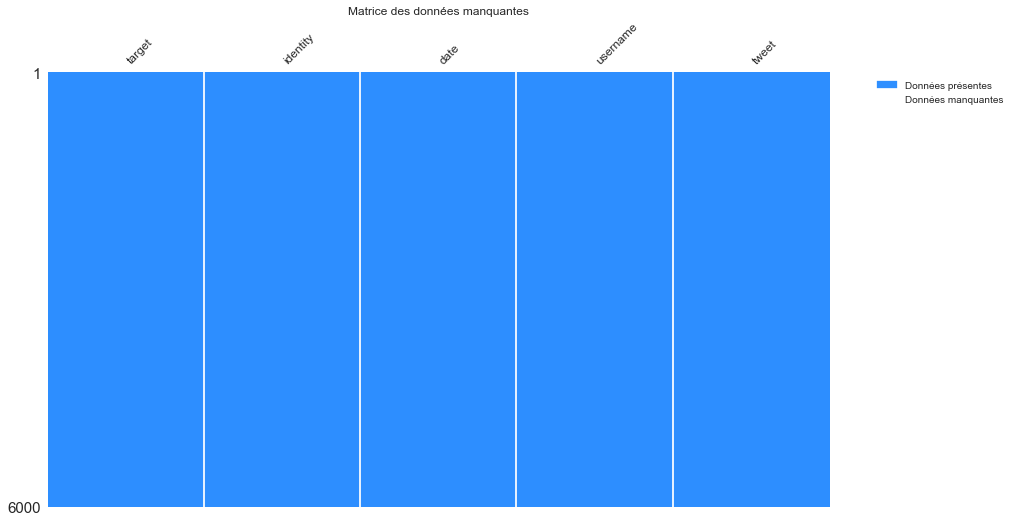

In [19]:
pk.matrix_vm(df, (14,8), (0.18, 0.56, 1))

Aucune donnée manquante

Passons au traitement du texte

In [20]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet  
0  My wife, @Birdro just confiscated my 3G S.  Ma...  
1  @STAWPITemily nm about to walk 3miles  in the ...

Regardons le nombre de texte en fonction de la variable "TARGET"  qui représente la polarité du tweet (0 = negative et 4 = positive)

Avant créons une variable avec les libellées pour améliorer la lisibilité

In [155]:
def lib_polarite_target(target):
    if target == 0:
        return "Negative"
    #elif target == 2:
        #return "Neutral"
    elif target == 4:
        return "Positive"

df["target_lib"] = df["target"].progress_apply(lambda x: lib_polarite_target(x))

  0%|          | 0/6000 [00:00<?, ?it/s]

In [22]:
df.head(5)

target    identity                          date         username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009         MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009    nymetsfan4evr   
2       0  1975246381  Sat May 30 14:45:19 PDT 2009          Lena373   
3       0  1988948900  Sun May 31 23:51:52 PDT 2009  DeniseIgnacio88   
4       0  1961974347  Fri May 29 10:19:44 PDT 2009           Trayzz   

                                               tweet target_lib  
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative  
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative  
2     @moniquita26 I guess I missed a good workout.    Negative  
3   seriously can't believe Rafa lost last night!!!    Negative  
4  @iamdiddy I need a hug  I'm doing my junior ce...   Negative

Etudions notre variable

In [205]:
def graph_circle(data, column, title):
    """
    Graphique circulaire
    Args:
        data ([type]): données de la colonne à representer
        column ([type]): nom de la colonne
        title ([type]): titre du graphique
    Exemple:
    graph_circle(data["libelle_francais"], "libelle_francais",
                 "Répartition des arbres en fonction de leur appellation")
    """
    t = pd.crosstab(data, "freq", normalize=True)
    t = t.assign(column=t.index, freq=100 * t.freq)
    plt.figure(figsize=(18, 8))
    plt.pie(t.freq, labels=t.column,  autopct='%.0f%%')

    plt.title(title)
    my_circle = plt.Circle((0, 0), 0.4, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

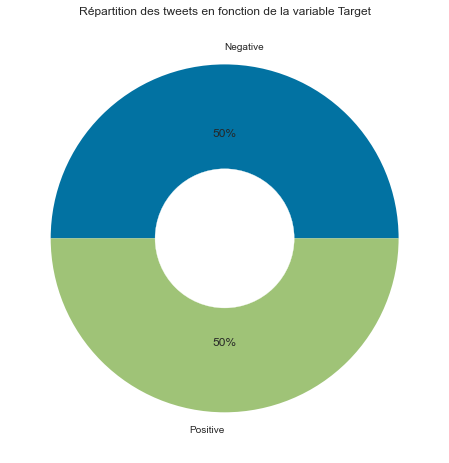

In [13]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

Nous observons que notre variable cible est donc équilibrée. En effet, nous retrouvons 50% de tweets avec un sentiment positif. Ce qui est logique dans la mesure où nous avons filtré notre jeu de données.

Traçons un wordcloud par classe même si le texte n'est pas encore nettoyé

In [14]:
gc.collect()

5741

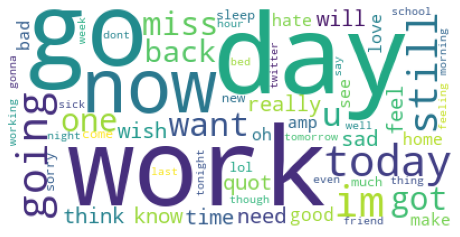

In [15]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet"])

Nous avons ici des mots plutôt négatifs avec miss, bad, hate, sorry, work, go.

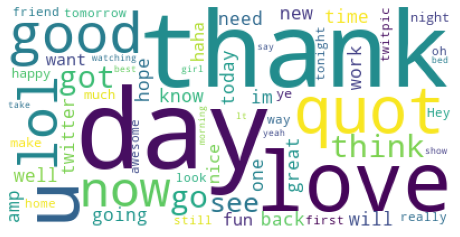

In [16]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet"])

Nous retrouvons des mots positifs avec thank, good, happy, lol, love...

### Passons au nettoyage et à l'analyse de la variable "tweet"

In [17]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet target_lib  
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative  
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative

In [23]:
df["tweet"][0]

"My wife, @Birdro just confiscated my 3G S.  Maybe I'll get to see it later on. :-P"

Nous observons que des tweets mélangent majuscule et minuscule. Nous allons donc mettre le texte en minuscule. Notons aussi que nous observons un @. Il faudra donc supprimer la ponctuation.

Pour cela, nous allons utiliser spacy. Et créer un pipeline que nous complèterons au fur et à mesure afin d'avoir un texte nettoyé.
Nous mettrons donc par la suite notre texte en minuscule et nous supprimerons la ponctuation.

Nous savons que dans les tweets, nous pouvons trouver : 
- des emoticônes et des emojicônes
- des mentions (ex : @toto)
- des hashtags (ex #toureiffel)
- des reponses directes à d'autres tweets, qui seront notées avec "RE"
- des emails
- des urls

En conséquence, nous devons retranscrire les emojicônes/emoticônes car ils expriments un sentiment. 
Et il nous faut supprimer les autres éléments qui n'apportent pas forcément d'informations sur le sentiment du tweet, excepté pour les hashtags qui peuvent exprimer des sentiments tel que #encolere

Commençons par ajouter au pipeline l'identification des emoticônes et des emojicônes en premier

!!!!!!!!!!!!!!!!!Pour rappel, dans le pipeline de spacy nous avons :
-'tok2vec',
-'tagger',
-'parser',
-'attribute_ruler',
-'lemmatizer',
-'ner'

In [111]:
nlp=spacy.load("en_core_web_sm")

In [112]:
_ = nlp.add_pipe("emoji", first=True)

In [113]:
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [114]:
gc.collect()

6614

Nous avons bien ajouté emoji en premier. Vérifions que cela fonctionne avec un texte

In [16]:
doc = nlp("Dr. Alex Smith :-) 😂 not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")
print([(token.text, token._.is_emoji, token.like_url) for token in doc])

[('Dr.', False, False), ('Alex', False, False), ('Smith', False, False), (':-)', False, False), ('😂', True, False), ('not', False, False), ('chaired', False, False), ('LMAO', False, False), ('first', False, False), ('board', False, False), ('meeting', False, False), ('of', False, False), ('Acme', False, False), ('Corp', False, False), ('Inc.', False, False), ('titi@gmail.com', False, False), ('<', False, False), ('https://t.co', False, True), ('>', False, False), ('Re', False, False)]


Notre emojicône est bien détectée contrairement à l'emoticône. Il nous faudra donc ajouter une autre méthode.
Vérifions si nous pouvons détecter les url, les e-mails et la ponctuation.

In [11]:
print(pk.convert_emoticons("Dr. Alex Smith :-) 😂 not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re"))

Dr. Alex Smith Happy_face_smiley 😂 not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <httpsSkeptical,_annoyed,_undecided,_uneasy_or_hesitant/t.co> Re


In [115]:
def is_emoticons_function(token):
    if token.like_url==True:
        return False
    else:
        check = pk.convert_emoticons(token.text)
    if check != token.text:
        return True

In [116]:
Token.set_extension("is_emoticons", getter=is_emoticons_function, force=True)


In [117]:
doc = nlp("Dr. Alex Smith :-) 😂 not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")
for token in doc:
    if token._.is_emoticons == True:
        print(token.text , " ",token._.is_emoticons)

:-)   True


In [118]:
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [119]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop, token._.is_emoticons) for token in doc])

[('Dr.', False, False, None, False, False, None), ('Alex', False, False, None, False, False, None), ('Smith', False, False, None, False, False, None), (':-)', True, False, None, False, False, True), ('😂', False, True, 'face with tears of joy', False, False, None), ('not', False, False, None, False, False, None), ('chaired', False, False, None, False, False, None), ('LMAO', False, False, None, False, False, None), ('first', False, False, None, False, True, None), ('board', False, False, None, False, False, None), ('meeting', False, False, None, False, False, None), ('of', False, False, None, False, True, None), ('Acme', False, False, None, False, False, None), ('Corp', False, False, None, False, False, None), ('Inc.', False, False, None, False, False, None), ('titi@gmail.com', False, False, None, True, False, None), ('<', False, False, None, False, False, None), ('https://t.co', False, False, None, False, False, False), ('>', False, False, None, False, False, None), ('Re', False, False,

Nous détectons bien ces informations.

Ajoutons "RE" dans les stopwords qui apparait lors de la réponse direct à un tweet

Voici un extrait de la liste des stopwords.

In [120]:
import spacy
stopwords = nlp.Defaults.stop_words

print(len(stopwords))
print(stopwords)

273
{'elsewhere', 'which', 'ten', 'are', '’re', 'front', 'please', 'since', 'alone', 'their', 'before', 'nor', 'each', 'whole', 'hereupon', 'last', '’ll', 'yours', "'ll", 'himself', 'otherwise', 'others', 'how', 'twenty', "'m", 'were', 'anyone', 'go', 'therein', 'part', 'myself', 'wherein', 'using', 'had', 'my', 'only', 'whatever', 'same', 'four', 'ours', 'thereupon', 'else', 'various', 'might', 'about', 'third', 'someone', 'becomes', 'see', 'behind', 'nowhere', 'it', 'formerly', 'from', 'nobody', 'beside', 'just', 'during', 'whenever', 'doing', 'hundred', 'does', 'side', 'these', 'get', 'former', 'make', 'its', 'top', 'hereby', 'namely', 'noone', 'has', 'i', 'she', 'all', '‘d', 'seem', 'towards', 'ourselves', 'whence', 'such', 'two', 'me', 'do', 'hereafter', 'be', 'everyone', 'until', 'latterly', 'beyond', 'may', 'when', 'something', 'your', 'move', 'against', 'themselves', 'on', 'take', 'being', 'call', 'them', 'indeed', 'somehow', 'above', 'among', 'with', 'therefore', 'up', 'whereb

In [121]:
nlp.Defaults.stop_words.add("re")

In [122]:
nlp.Defaults.stop_words -= {"not", "no", "n't",'n’t', "would", "without", "could", "still", "ever", 
                            "yet", "almost", "should", "always", "too", "sometimes", "except", 
                            "everything", "really", "nothing", "down", "also", "very", "most", "'d", 
                            "serious", "than", "however", "well", "neither", "anyhow", "few",
                            "rather", "mostly", "none", "must", "less", "many", "as", "often", 
                            "never", "enough", "much", "out", "but", "whereas", "netherrless",
                            "next", "even", "although", "why", "again", "perhaps", "cannot"}

In [123]:
stopwords=nlp.Defaults.stop_words

In [124]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop, token.like_url) for token in doc])

[('Dr.', False, False, None, False, False, False), ('Alex', False, False, None, False, False, False), ('Smith', False, False, None, False, False, False), (':-)', True, False, None, False, False, False), ('😂', False, True, 'face with tears of joy', False, False, False), ('not', False, False, None, False, False, False), ('chaired', False, False, None, False, False, False), ('LMAO', False, False, None, False, False, False), ('first', False, False, None, False, True, False), ('board', False, False, None, False, False, False), ('meeting', False, False, None, False, False, False), ('of', False, False, None, False, True, False), ('Acme', False, False, None, False, False, False), ('Corp', False, False, None, False, False, False), ('Inc.', False, False, None, False, False, False), ('titi@gmail.com', False, False, None, True, False, False), ('<', False, False, None, False, False, False), ('https://t.co', False, False, None, False, False, True), ('>', False, False, None, False, False, False), ('R

In [125]:
print(stopwords)

{'elsewhere', 'which', 'ten', 'are', '’re', 'front', 'please', 'since', 'alone', 'their', 'before', 'nor', 'each', 'whole', 'hereupon', 'last', '’ll', 'yours', "'ll", 'himself', 'otherwise', 'others', 'how', 'twenty', "'m", 'were', 'anyone', 'go', 'therein', 'part', 'myself', 'wherein', 'using', 'had', 'my', 'only', 'whatever', 'same', 'four', 'ours', 'thereupon', 'else', 'various', 'might', 'about', 'third', 'someone', 'becomes', 'see', 'behind', 'nowhere', 'it', 'formerly', 'from', 'nobody', 'beside', 'just', 'during', 'whenever', 'doing', 'hundred', 'does', 'side', 'these', 'get', 'former', 'make', 'its', 'top', 'hereby', 'namely', 'noone', 'has', 'i', 'she', 'all', '‘d', 'seem', 'towards', 'ourselves', 'whence', 'such', 'two', 'me', 'do', 'hereafter', 'be', 'everyone', 'until', 'latterly', 'beyond', 'may', 'when', 'something', 'your', 'move', 'against', 'themselves', 'on', 'take', 'being', 'call', 'them', 'indeed', 'somehow', 'above', 'among', 'with', 'therefore', 'up', 'whereby', 

"Re" est donc bien détecté comme un stopword.

Créons une fonction pour détecter les mentions dans les tweets (ex: @toto)

In [126]:
# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)

def is_mention_function(token):
    if token.text.startswith("@") == True and len(token.text)>1:
        return True
        
Token.set_extension("is_mention", getter=is_mention_function, force=True)

In [127]:
doc = nlp("I have @toto")
for token in doc:
    if token._.is_mention == True:
        print(token._.is_mention)

True


La mention est bien détectée

Nous pouvons donc créer un nouveau composant qui permettra d'obtenir nos mots nettoyés

In [171]:
# Définit un composant personnalisé
def text_clean_function(doc):
    new_words = []
    for token in doc:
        if token._.is_emoji:
            new_words.append(token._.emoji_desc)
        elif token._.is_emoticons:
            new_words.append(pk.convert_emoticons(token.text))
        elif token.like_email or token.is_stop or token.like_url:
            continue
        elif token._.is_mention == True:
            continue
        elif token.is_punct or "<" in token.text or ">" in token.text:
            continue
        else :
            if token.text.strip() != "":
                new_words.append(token.text)
    return new_words


In [132]:
from spacy.tokens import Doc

@Language.component("pre_process_text")
def pre_process_text_function(doc):
    # Generate a new list of tokens here
    new_words = text_clean_function(doc)
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc

In [133]:
# Ajoute le composant en premier dans le pipeline
nlp.add_pipe("pre_process_text", before="tok2vec")

<function __main__.pre_process_text_function(doc)>

In [134]:
nlp.pipe_names

['emoji',
 'pre_process_text',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [172]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto not chaired LMAO n't first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [173]:
doc

Dr. Alex Smith Happy_face_smiley face with tears of joy not chaired LMAO n't board meeting Acme Corp Inc. 

In [146]:
text_clean_function(doc)

['Dr.',
 'Alex',
 'Smith',
 'Happy_face_smiley',
 'face with tears of joy',
 '😂',
 'not',
 'chaired',
 'LMAO',
 "n't",
 'board',
 'meeting',
 'Acme',
 'Corp',
 'Inc.']

In [147]:
def stemming_function(doc):
    stemmer = SnowballStemmer(language='english')
    list_doc = []
    for token in doc:
        print(token.text)
        list_doc.append(stemmer.stem(token.text))
    return list_doc

In [148]:
test = stemming_function(doc)

Dr.
Alex
Smith
Happy_face_smiley
face with tears of joy
😂
not
chaired
LMAO
n't
board
meeting
Acme
Corp
Inc.


In [75]:
doc.text

'Dr. Alex Smith face with tears of joy not chaired LMAO board meeting Acme Corp Inc. < > '

In [76]:
test

['dr.',
 'alex',
 'smith',
 'face with tears of joy',
 'not',
 'chair',
 'lmao',
 'board',
 'meet',
 'acm',
 'corp',
 'inc.',
 '<',
 '>']

In [149]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)
def stemming_function(token):
    stemmer = SnowballStemmer(language='english')
    stem = stemmer.stem(token.text)
    return stem

Token.set_extension("stemming_", getter=stemming_function, force=True)

In [162]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [163]:
for token in doc:
    print(token._.stemming_)

dr.
alex
smith
happy_face_smiley
face with tears of joy
😂
not
chair
lmao
board
meet
acm
corp
inc.


In [192]:
df["tweet_clean"] = df["tweet"].progress_apply(lambda x: nlp(x))

  0%|          | 0/5978 [00:00<?, ?it/s]

In [193]:
df["tweet_lemma"] = df["tweet"].progress_apply(lambda x: [token.lemma_ for token in nlp(x)])

  0%|          | 0/5978 [00:00<?, ?it/s]

In [194]:
df["tweet_stem"] = df["tweet"].progress_apply(lambda x: [token._.stemming_ for token in nlp(x)])

  0%|          | 0/5978 [00:00<?, ?it/s]

In [195]:
df.head(15)

target    identity                          date         username  \
0        0  2246208061  Fri Jun 19 17:15:08 PDT 2009         MrBlippy   
1        0  2221102007  Thu Jun 18 04:42:09 PDT 2009    nymetsfan4evr   
2        0  1975246381  Sat May 30 14:45:19 PDT 2009          Lena373   
3        0  1988948900  Sun May 31 23:51:52 PDT 2009  DeniseIgnacio88   
4        0  1961974347  Fri May 29 10:19:44 PDT 2009           Trayzz   
5        0  1882285706  Fri May 22 06:35:31 PDT 2009         caasheew   
6        0  2254025856  Sat Jun 20 09:06:46 PDT 2009    cloudissocool   
7        0  2256930005  Sat Jun 20 13:31:29 PDT 2009  JulieGarrafinha   
8        0  1976317965  Sat May 30 17:03:57 PDT 2009    MagicalMillie   
9        0  2006964417  Tue Jun 02 11:56:46 PDT 2009          sophz_x   
10       0  2327983777  Thu Jun 25 09:01:43 PDT 2009       spaghettes   
11       0  1792527969  Wed May 13 23:24:29 PDT 2009          inholee   
12       0  2191507624  Tue Jun 16 05:25:17 PDT 2009       jenny77076   
13       0  1994840461  Mon Jun 01 12:32:27 PDT 2009      OfficeFan85   
14       0  1693914274  Mon May 04 00:16:46 PDT 2009       ladydani86   

                                                tweet target_lib  \
0   My wife, @Birdro just confiscated my 3G S.  Ma...   Negative   
1   @STAWPITemily nm about to walk 3miles  in the ...   Negative   
2      @moniquita26 I guess I missed a good workout.    Negative   
3    seriously can't believe Rafa lost last night!!!    Negative   
4   @iamdiddy I need a hug  I'm doing my junior ce...   Negative   
5   @abrad45 it's more of a shut my blackberry up ...   Negative   
6   I cant even find sites with her lyrics on it  ...   Negative   
7           Saturday -- sleeping, studying, eating.     Negative   
8                                  @ryrou no...sadly    Negative   
9   screw history revision...i'm gonna mourn the l...   Negative   
10  it might as well jsut rain if the sun wont com...   Negative   
11       @sailaways You're alive!!  We've missed you    Negative   
12  Can't move. Hurts to breathe. Wants the pain t...   Negative   
13  hurt her knees  Boo. Walking to the beach was ...   Negative   
14  Best friend sms me if i've had eaten n my well...   Negative   

                                          tweet_clean  \
0    (wife, confiscated, 3, G, S., Maybe, later, :-P)   
1                            (nm, walk, 3miles, rain)   
2                      (guess, missed, good, workout)   
3        (seriously, n't, believe, Rafa, lost, night)   
4   (need, hug, junior, cert, week, totally, stres...   
5   (shut, blackberry, kind, thing, but, n't, feel...   
6   (nt, even, find, sites, lyrics, n't, like, lot...   
7              (Saturday, sleeping, studying, eating)   
8                                         (no, sadly)   
9   (screw, history, revision, i'm, gon, na, mourn...   
10     (as, well, jsut, rain, sun, wo, nt, come, out)   
11                                    (alive, missed)   
12  (n't, Hurts, breathe, Wants, pain, end, Kill, ...   
13  (hurt, knees, Boo, Walking, beach, fun, noneth...   
14  (Best, friend, sms, eaten, n, well, even, bz, ...   

                                          tweet_lemma  \
0     [wife, confiscate, 3, g, S., maybe, later, :-P]   
1                            [nm, walk, 3miles, rain]   
2                        [guess, miss, good, workout]   
3        [seriously, not, believe, Rafa, lose, night]   
4   [need, hug, junior, cert, week, totally, stres...   
5   [shut, blackberry, kind, thing, but, not, feel...   
6   [not, even, find, site, lyric, not, like, lot,...   
7                       [Saturday, sleep, study, eat]   
8                                         [no, sadly]   
9   [screw, history, revision, i'm, go, to, mourn,...   
10  [as, well, jsut, rain, sun, will, not, come, out]   
11                                      [alive, miss]   
12  [not, hurts, breathe, want, pain, end, Kill, o...   
13  [hurt, knees, Boo, Walking, bea

Nous ne supprimons pas les # car on peut avoir des #encolere

In [84]:
import spacy
from spacy.matcher import Matcher

#nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)


pattern =  [{'ORTH': '#'}, {'IS_ASCII': True}]
matcher.add('HASHTAG', [pattern])

doc = nlp("Hello, world! Hello world! ###toto")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print( string_id, start, end, span.text)

    

HASHTAG 7 9 ##
HASHTAG 8 10 ##
HASHTAG 9 11 #toto


In [85]:
df.head(3)

target    identity                          date      username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009     Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009    kawtreenah   
2       0  2064059763  Sun Jun 07 05:05:10 PDT 2009  ohglorymegan   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    
2  Emily thought it'd be cool to just take my bla...   

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   
2  (Emily, thought, 'd, cool, blanket, pillow, co...   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   
2  [Emily, think, would, cool, blanket, pillow, c...   

                                          tweet_stem  \
0  [know, sphincter, oddi, dysfunct, pls, send, l...   
1   [not, lookin, good, mr., sun, not, lookin, good]   
2  [emili, thought, 'd, cool, blanket, pillow, co...   

                                    tweet_lemma_join  \
0  know sphincter oddi dysfunction pls send link ...   
1                    lookin good Mr. Sun lookin good   
2          Emily think cool blanket pillow come help   

                                     tweet_stem_join target_lib  
0  know sphincter oddi dysfunct pls send link dx'...   Negative  
1                    lookin good mr. sun lookin good   Negative  
2        emili thought cool blanket pillow come help   Negative

In [177]:
gc.collect()

849

#### Retraçons les wordcloud par classe et par methode stem / lemma

In [196]:
df["tweet_lemma_join"] = df["tweet_lemma"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/5978 [00:00<?, ?it/s]

In [197]:
df["tweet_stem_join"] = df["tweet_stem"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/5978 [00:00<?, ?it/s]

In [199]:
df.head(10) ##### ici

target    identity                          date         username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009         MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009    nymetsfan4evr   
2       0  1975246381  Sat May 30 14:45:19 PDT 2009          Lena373   
3       0  1988948900  Sun May 31 23:51:52 PDT 2009  DeniseIgnacio88   
4       0  1961974347  Fri May 29 10:19:44 PDT 2009           Trayzz   
5       0  1882285706  Fri May 22 06:35:31 PDT 2009         caasheew   
6       0  2254025856  Sat Jun 20 09:06:46 PDT 2009    cloudissocool   
7       0  2256930005  Sat Jun 20 13:31:29 PDT 2009  JulieGarrafinha   
8       0  1976317965  Sat May 30 17:03:57 PDT 2009    MagicalMillie   
9       0  2006964417  Tue Jun 02 11:56:46 PDT 2009          sophz_x   

                                               tweet target_lib  \
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative   
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative   
2     @moniquita26 I guess I missed a good workout.    Negative   
3   seriously can't believe Rafa lost last night!!!    Negative   
4  @iamdiddy I need a hug  I'm doing my junior ce...   Negative   
5  @abrad45 it's more of a shut my blackberry up ...   Negative   
6  I cant even find sites with her lyrics on it  ...   Negative   
7          Saturday -- sleeping, studying, eating.     Negative   
8                                 @ryrou no...sadly    Negative   
9  screw history revision...i'm gonna mourn the l...   Negative   

                                         tweet_clean  \
0   (wife, confiscated, 3, G, S., Maybe, later, :-P)   
1                           (nm, walk, 3miles, rain)   
2                     (guess, missed, good, workout)   
3       (seriously, n't, believe, Rafa, lost, night)   
4  (need, hug, junior, cert, week, totally, stres...   
5  (shut, blackberry, kind, thing, but, n't, feel...   
6  (nt, even, find, sites, lyrics, n't, like, lot...   
7             (Saturday, sleeping, studying, eating)   
8                                        (no, sadly)   
9  (screw, history, revision, i'm, gon, na, mourn...   

                                         tweet_lemma  \
0    [wife, confiscate, 3, g, S., maybe, later, :-P]   
1                           [nm, walk, 3miles, rain]   
2                       [guess, miss, good, workout]   
3       [seriously, not, believe, Rafa, lose, night]   
4  [need, hug, junior, cert, week, totally, stres...   
5  [shut, blackberry, kind, thing, but, not, feel...   
6  [not, even, find, site, lyric, not, like, lot,...   
7                      [Saturday, sleep, study, eat]   
8                                        [no, sadly]   
9  [screw, history, revision, i'm, go, to, mourn,...   

                                    tweet_lemma_join  \
0             wife confiscate 3 g S. maybe later :-P   
1                                nm walk 3miles rain   
2                            guess miss good workout   
3              seriously not believe Rafa lose night   
4   need hug junior cert week totally stress out cry   
5  shut blackberry kind thing but not feel leave ...   
6  not even find site lyric not like lot j pop bu...   
7                           Saturday sleep study eat   
8                                           no sadly   
9  screw history revision i'm go to mourn loss ia...   

                                          tweet_stem  \
0        [wife, confisc, 3, g, s., mayb, later, :-p]   
1                            [nm, walk, 3mile, rain]   
2                       [guess, miss, good, workout]   
3          [serious, n't, believ, rafa, lost, night]   
4  [need, hug, junior, cert, week, total, stress,...   
5  [shut, blackberri, kind, thing, but, n't, feel...   
6  [nt, even, find, site, lyric, n't, like, lot, ...   
7                      [saturday, sleep, studi, eat]   
8                                          [no, sad]   
9  [screw, histori, revis, i'm, gon, na, mourn, l...   

    

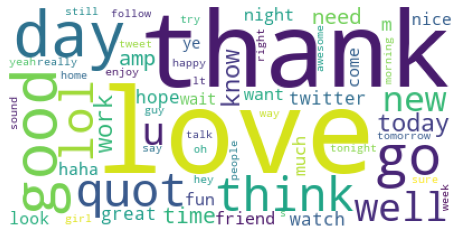

In [181]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_lemma_join"])

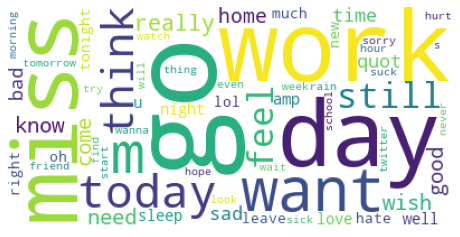

In [182]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_lemma_join"])

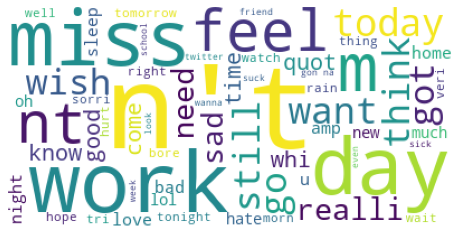

In [183]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_stem_join"])

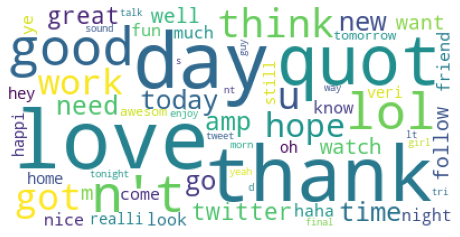

In [184]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_stem_join"])

Nous conservons donc la méthode de lemmatisation. Nous pouvons supprimer les colonnes contenant les données de stemming.

In [200]:
df = df.drop(["tweet_stem", "tweet_stem_join"], axis=1)

In [201]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet target_lib  \
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative   
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative   

                                        tweet_clean  \
0  (wife, confiscated, 3, G, S., Maybe, later, :-P)   
1                          (nm, walk, 3miles, rain)   

                                       tweet_lemma  \
0  [wife, confiscate, 3, g, S., maybe, later, :-P]   
1                         [nm, walk, 3miles, rain]   

                         tweet_lemma_join  
0  wife confiscate 3 g S. maybe later :-P  
1                     nm walk 3miles rain

La technique de lemmatization supprime surement des commentaires qui n'ont pas de sens tel que "I will go".
Nous supprimons donc les lignes vides.

In [202]:
df = df.loc[df["tweet_lemma"] != np.array(0)]

In [203]:
df.shape

(5978, 9)

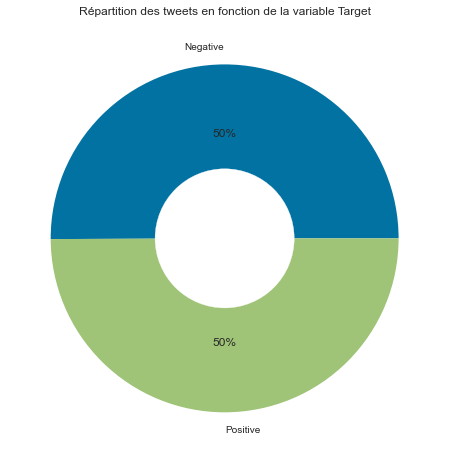

In [206]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

Pour que la target soit plus parlant, on va mettre 1 = positif et 0 = négatif

In [271]:
df['target'] = (df['target'] == 4).astype(int)

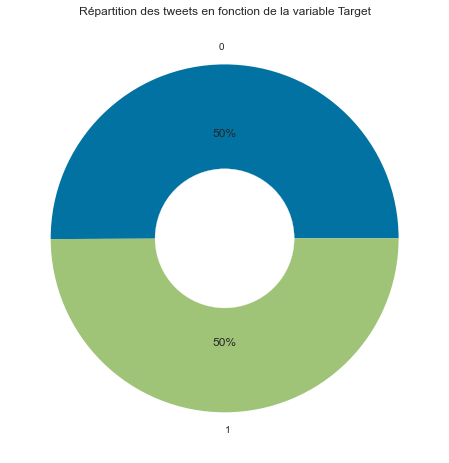

In [272]:
graph_circle(df["target"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

In [275]:
df.tail(2)

target    identity                          date       username  \
5998       1  2054918819  Sat Jun 06 08:20:37 PDT 2009         bonach   
5999       1  2188284325  Mon Jun 15 21:37:11 PDT 2009  DonniesGirl69   

                                                  tweet target_lib  \
5998  @jeffreyrowe Wow! You speak Japanese like nati...   Positive   
5999  @Sweetangel69 Oh, I didn't know she was doing ...   Positive   

                                            tweet_clean  \
5998  (Wow, speak, Japanese, like, native, speaker, ...   
5999                           (Oh, n't, know, Wichita)   

                                            tweet_lemma  \
5998  [wow, speak, japanese, like, native, speaker, ...   
5999                           [oh, not, know, Wichita]   

                                       tweet_lemma_join  
5998  wow speak japanese like native speaker long le...  
5999                                oh not know Wichita

In [276]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet target_lib  \
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative   
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative   

                                        tweet_clean  \
0  (wife, confiscated, 3, G, S., Maybe, later, :-P)   
1                          (nm, walk, 3miles, rain)   

                                       tweet_lemma  \
0  [wife, confiscate, 3, g, S., maybe, later, :-P]   
1                         [nm, walk, 3miles, rain]   

                         tweet_lemma_join  
0  wife confiscate 3 g S. maybe later :-P  
1                     nm walk 3miles rain

## Feature engineering

Deux méthodes : Glove, Fasttext

### Commençons par Glove

- Algorithme pour l'incorporation de mots :
- Prétraitez les données textuelles.
- Créé le dictionnaire.
- Parcourir le fichier glove d'une dimension précise et comparer chaque mot avec tous les mots du dictionnaire,
- si une correspondance se produit, copiez le vecteur équivalent du gant et collez-le dans embedding_matrix à l'index correspondant.

La matrice d'intégration est une matrice dont la taille de ligne est égale au nombre de mots uniques dans le document et dont la taille de colonne correspond à la dimension du vecteur d'intégration. Ainsi, afin de construire une matrice d'intégration, il faut soit créer les vecteurs d'intégration de mots, soit utiliser des intégrations de mots pré-formés. Dans cet exemple, nous allons lire un fichier d'incorporation de mots fictifs et construire la matrice.

In [207]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet target_lib  \
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative   
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative   

                                        tweet_clean  \
0  (wife, confiscated, 3, G, S., Maybe, later, :-P)   
1                          (nm, walk, 3miles, rain)   

                                       tweet_lemma  \
0  [wife, confiscate, 3, g, S., maybe, later, :-P]   
1                         [nm, walk, 3miles, rain]   

                         tweet_lemma_join  
0  wife confiscate 3 g S. maybe later :-P  
1                     nm walk 3miles rain

In [208]:
df["tweet_lemma"][0]

['wife', 'confiscate', '3', 'g', 'S.', 'maybe', 'later', ':-P']

In [209]:
import numpy as np


class Embeddings():
    """
    A class to read the word embedding file and to create the word embedding matrix
    """

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        A method to create the embedding matrix
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [210]:
def ml_pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()  
    X=data2[["tweet_lemma_join"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

In [211]:
X_train = df["tweet_lemma_join"]# Texte 


In [212]:
X_train

0                  wife confiscate 3 g S. maybe later :-P
1                                     nm walk 3miles rain
2                                 guess miss good workout
3                   seriously not believe Rafa lose night
4        need hug junior cert week totally stress out cry
                              ...                        
5995    loove idea answer ur question coz absolutely n...
5996                                      thank much well
5997                                   must stay positive
5998    wow speak japanese like native speaker long le...
5999                                  oh not know Wichita
Name: tweet_lemma_join, Length: 5978, dtype: object

In [213]:
Y_train = df["target"] # Libellé

In [214]:
X_train.shape

(5978,)

In [215]:
Y_train.shape

(5978,)

In [216]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [217]:
embed_path = 'Input\\embeddings\\glove.6B\\glove.6B.300d.txt' #glove.6B.300d
embed_dim = 300


In [218]:
# Creating the embedding matrix
embedding = Embeddings(embed_path, embed_dim)
embedding_matrix_glove = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

In [226]:
embedding_matrix_glove.shape

(8646, 300)

### Passons à Fasttext

In [222]:
fasttext = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

In [223]:
class Embeddings_Model():
    """
    A class to read the word embedding model and to create the word embedding matrix
    """

    def __init__(self, model, vector_dimension):
        self.model = model 
        self.vector_dimension = vector_dimension

    def get_embedding_index(self):
        embeddings_index = self.model
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        A method to create the embedding matrix
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [224]:
# Creating the embedding matrix
embedding = Embeddings_Model(fasttext, embedding_dim)
embedding_matrix_fasttext = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

In [225]:
embedding_matrix_fasttext.shape

(8646, 300)

Nous avons créé deux embeddings, nous pouvons donc essayer à présent de trouver un modèle.

## Recherche d'un modèle avancé

Commençons par réaliser un modèle simple

### Réseau de neurone simple

In [227]:
X_train

0                  wife confiscate 3 g S. maybe later :-P
1                                     nm walk 3miles rain
2                                 guess miss good workout
3                   seriously not believe Rafa lose night
4        need hug junior cert week totally stress out cry
                              ...                        
5995    loove idea answer ur question coz absolutely n...
5996                                      thank much well
5997                                   must stay positive
5998    wow speak japanese like native speaker long le...
5999                                  oh not know Wichita
Name: tweet_lemma_join, Length: 5978, dtype: object

In [228]:
vocab_size = len(tokenizer.word_index) + 1

Notre modèle simple sera composé :
- des poids de l'embedding sans entrainement, 
- d'une couche dense, 
- d'une couche dropout avec un taux à 0.2/0.5, 
- d'une couche Flatten (pour créer un vecteur de caractéristiques unique)
- et d'une couche dense avec une fonction d'activation sigmoid.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Pour rappel :
- Une couche dense est un vecteur de dimension « m ». Ainsi, la couche dense est essentiellement utilisée pour modifier les dimensions du vecteur. Les couches denses appliquent également des opérations telles que la rotation, la mise à l'échelle, la translation sur le vecteur.
- Une couche dropout permet de reguler overffiting en desactivant certains neurones
- La fonction d'activation permet de modifier spatialement la représentation des données

In [493]:
# dense(activation), dropout(%), flatten, dense
model = Sequential()
model.add(Embedding( 
  input_dim=8646, 
  output_dim=300, 
  input_length=190, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Dense(32, input_dim=8646, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])

In [984]:
# dense(activation), dropout(%), flatten, dense
model = Sequential()
model.add(Embedding( 
  input_dim=8646, 
  output_dim=300, 
  input_length=190, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Dense(units=32, input_dim=8646, activation='tanh'))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss ='binary_crossentropy',metrics=['AUC'])

In [809]:
model.summary()

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_89 (Embedding)    (None, 190, 300)          2593800   
                                                                 
 dense_215 (Dense)           (None, 190, 32)           9632      
                                                                 
 dropout_9 (Dropout)         (None, 190, 32)           0         
                                                                 
 flatten_92 (Flatten)        (None, 6080)              0         
                                                                 
 dense_216 (Dense)           (None, 1)                 6081      
                                                                 
Total params: 2,609,513
Trainable params: 15,713
Non-trainable params: 2,593,800
_________________________________________________________________


In [797]:
def ml_pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()  
    X=data2["tweet_lemma_join"].loc[pd.isna(data["target"])==False]
    del data2["target"]
    Y=data["target"].loc[pd.isna(data["target"])==False]
    return X,Y

from keras_preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences

class TextToTensor():

    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def string_to_tensor(self, string_list: list) -> list:
        """
        A method to convert a string list to a tensor for a deep learning model
        """    
        string_list = self.tokenizer.texts_to_sequences(string_list)
        string_list = pad_sequences(string_list, maxlen=self.max_len)
        
        return string_list

def ml_step1_ech(df):
        X, Y = ml_pipeline_divide_data(df)
        X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
        return X_train, X_test, y_train, y_test

def ml_step2_ech(X_train, X_test, y_train, y_test):
    max_len = np.max([len(text) for text in X_train])
    TextToTensor_instance = TextToTensor(
            tokenizer=tokenizer,
            max_len=max_len
            )
    X_train = TextToTensor_instance.string_to_tensor(X_train)
    # Creating the padded input for the deep learning model
    # X_train = ml_transform(X_train)
    X_test = TextToTensor_instance.string_to_tensor(X_test)
    # X_test = TextToTensor_instance.string_to_tensor(X_test)
    return X_train, X_test, np.array(y_train), np.array(y_test)
    
def ml_ech(df):
    X_train, X_test, y_train, y_test = ml_step1_ech(df)
    X_train, X_test, y_train, y_test = ml_step2_ech(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test


In [798]:
X_train, X_test, y_train, y_test = ml_ech(df)

In [799]:
X_train_ech, X_test_ech, y_train_ech, y_test_ech = pk_multi_sup.pipelineModel_TrainingSet(X_train, y_train, 0, 0.3)

In [800]:
X_train.shape

(4184, 190)

In [1031]:
history = model.fit(X_train_ech, y_train_ech, validation_data=(X_test_ech, y_test_ech), epochs=10, batch_size=113)

Epoch 1/10
26/26 [==============================] - 1s 37ms/step - loss: 0.5076 - auc: 0.8376 - val_loss: 0.5181 - val_auc: 0.8255
Epoch 2/10
26/26 [==============================] - 1s 33ms/step - loss: 0.4972 - auc: 0.8460 - val_loss: 0.5165 - val_auc: 0.8260
Epoch 3/10
26/26 [==============================] - 1s 32ms/step - loss: 0.4900 - auc: 0.8505 - val_loss: 0.5171 - val_auc: 0.8269
Epoch 4/10
26/26 [==============================] - 1s 32ms/step - loss: 0.4865 - auc: 0.8524 - val_loss: 0.5148 - val_auc: 0.8269
Epoch 5/10
26/26 [==============================] - 1s 31ms/step - loss: 0.4800 - auc: 0.8573 - val_loss: 0.5158 - val_auc: 0.8261
Epoch 6/10
26/26 [==============================] - 1s 31ms/step - loss: 0.4769 - auc: 0.8583 - val_loss: 0.5213 - val_auc: 0.8268
Epoch 7/10
26/26 [==============================] - 1s 31ms/step - loss: 0.4738 - auc: 0.8604 - val_loss: 0.5189 - val_auc: 0.8251
Epoch 8/10
26/26 [==============================] - 1s 31ms/step - loss: 0.4633 - a

In [783]:
def graph_history_train(history):
    loss_curve = history.history["loss"]
    acc_curve = history.history["auc"]

    loss_val_curve = history.history["val_loss"]
    acc_val_curve = history.history["val_auc"]

    plt.plot(loss_curve, label="Train")
    plt.plot(loss_val_curve, label="Val")
    plt.legend(loc='upper left')
    plt.title("Loss")
    plt.show()

    plt.plot(acc_curve, label="Train")
    plt.plot(acc_val_curve, label="Val")
    plt.legend(loc='upper left')
    plt.title("AUC")
    plt.show()

In [802]:
results = model.evaluate(X_test,y_test)

57/57 [==============================] - 0s 4ms/step - loss: 0.5516 - auc: 0.7946


In [1032]:
preds = model.predict(X_test)

57/57 [==============================] - 0s 4ms/step


In [804]:
X_test.shape

(1794, 190)

In [995]:
preds

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [998]:
preds

array([[0.78500485],
       [0.6256782 ],
       [0.19647   ],
       ...,
       [0.34610084],
       [0.4857956 ],
       [0.29875088]], dtype=float32)

0.7234943632068418


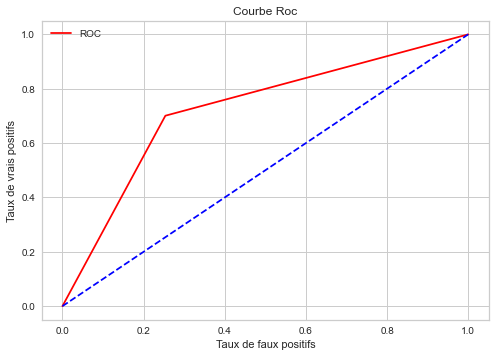

FULL Métrique Métier :  0.14124860646599777
Mean Absolute Error: 0.2753623188405797
Mean Squared Error: 0.2753623188405797
Root Mean Squared Error: 0.5247497678328021


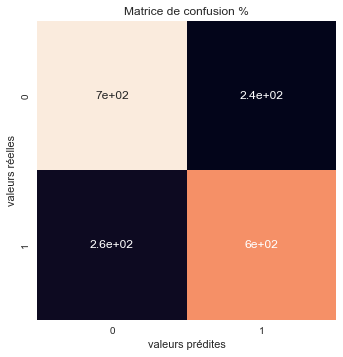

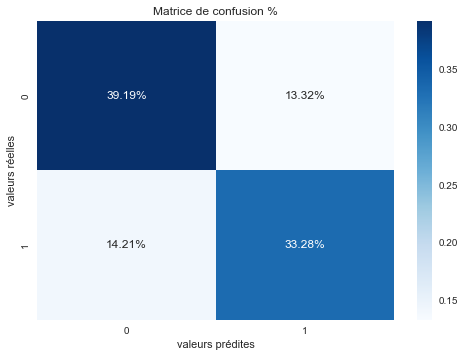


Sur le jeu de test auc : 0.723

Sur le jeu de test f1_score : 0.707

Sur le jeu de test precision : 0.714

Sur le jeu de test recall : 0.701


In [1033]:
pipeline_training_metrics(preds, y_test)

Créons un pipeline afin de pouvoir tester différentes méthodes et les deux embeddings.

In [338]:
def funct_model_simple(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=8646, 
    output_dim=300, 
    input_length=190, 
    weights= [embed],
    trainable = False,
    mask_zero= True )) 
    model.add(Dense(32, input_dim=8646, activation='relu'))
    model.add(Dropout(rate=param))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
    return model

In [339]:
params_model1 = []
params_model1.append(0.2)
params_model1.append(0.5)

In [340]:
models = []
models.append({"method":1, "function":funct_model_simple, "parameters":params_model1})
#models.append({"method":2, model2})

In [341]:
models = pd.DataFrame(models)

In [342]:
models

method                                           function  parameters
0       1  <function funct_model_simple at 0x000001A0F581...  [0.2, 0.5]

In [343]:
gc.collect()

15619

In [1026]:
####score pour fonction metier
from sklearn import metrics

def fmetric_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier

metric_history = []
best_metric_history_n = []

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe Roc')
    plt.legend()
    plt.show()


def pipeline_training_metrics(preds, y_test):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(preds > 0.5, 1, 0) 
    #y_pred = preds.argmax(axis=1)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #


Création d'un pipeline avec optimisation des hyperparametres

Commençons par créer les fonctions des différents modèles choisis

In [ ]:
def build_model(hp):
    model_type = hp.Choice('model_type', ['random_forest', 'ridge'])
    if model_type == 'random_forest':
        with hp.conditional_scope('model_type', 'random_forest'):
            model = ensemble.RandomForestClassifier(
                n_estimators=hp.Int('n_estimators', 10, 50, step=10),
                max_depth=hp.Int('max_depth', 3, 10))
    elif model_type == 'ridge':
        with hp.conditional_scope('model_type', 'ridge'):
            model = linear_model.RidgeClassifier(
                alpha=hp.Float('alpha', 1e-3, 1, sampling='log'))
    else:
        raise ValueError('Unrecognized model_type')
    return model

In [ ]:
tuner = kt.tuners.Sklearn(
        oracle=kt.oracles.BayesianOptimization(
            objective=kt.Objective('score', 'max'),
            max_trials=10),
        hypermodel=build_model,
        directory=tmp_dir)
X, y = ...
tuner.search(X, y)

In [ ]:
tuner = kt.tuners.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2)

In [ ]:
best_model = tuner.get_best_models(1)[0]

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [1020]:
# dense(activation), dropout(%), flatten, dense
model = Sequential()
model.add(Embedding( 
  input_dim=8646, 
  output_dim=300, 
  input_length=190, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Dense(units=32, input_dim=8646, activation='tanh'))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss ='binary_crossentropy',metrics=['AUC'])

In [940]:
from keras_tuner import HyperModel, tuners, Objective
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

class RNNHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        gc.collect()
        model = tf.keras.Sequential()
        if hp.Choice('embedding_0', ['embed', 'ssembed']) == 'embed':
            if hp.Choice('embedding_choice_1', ['glove', 'fasttext']) == 'fasttext':
                model.add(
                    Embedding( 
                                input_dim=8646, 
                                output_dim=300, 
                                input_length=190, 
                                weights=[embedding_matrix_fasttext],
                                trainable = False,
                                mask_zero= True)
                        )
            else:
                model.add(
                    Embedding( 
                                input_dim=8646, 
                                output_dim=300, 
                                input_length=190, 
                                weights= [embedding_matrix_glove],
                                trainable = False,
                                mask_zero= True)
                        )
        else:
            model.add(
                Embedding( 
                            input_dim=8646, 
                            output_dim=300, 
                            input_length=190, 
                            trainable = True,
                            mask_zero= True)
                    )
        model.add(
                Dense(
                    units=hp.Int(
                        'units',
                        min_value=32,
                        max_value=512,
                        step=32,
                        default=32
                    ),
                    activation=hp.Choice(
                        'dense_activation',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='tanh'
                    )
                )
            )
        model.add(
                Dropout(rate=hp.Float(
                    'dropout_1',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.2,
                    step=0.05,
                ))
            )
        model.add(Flatten())
        if hp.Choice('dense_2', ['1', '2']) == '2':
            model.add(
                Dense(
                    units=hp.Int(
                        'units',
                        min_value=32,
                        max_value=512,
                        step=32,
                        default=128
                    ),
                    activation=hp.Choice(
                        'dense_activation',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='tanh'
                    )
                )
            )
            model.add(
                Dropout(
                    rate=hp.Float(
                        'dropout_2',
                        min_value=0.0,
                        max_value=0.5,
                        default=0.2,
                        step=0.05
                    )
                )
            )
            
        model.add(Dense(self.num_classes, activation='sigmoid'))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    default=1e-3
                )
            ),
            loss='binary_crossentropy',
            metrics=['AUC']
        )
        return model

hypermodel = RNNHyperModel(num_classes=1)

In [951]:
hypermodel

In [1034]:
tuner = tuners.BayesianOptimization(
    hypermodel,
    objective=Objective("auc", direction="max"),
    max_trials=40,
    num_initial_points=2)


INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [877]:
tuner

In [1035]:
X_train, X_test, y_train, y_test = ml_ech(df)

In [1036]:
X_train_ech, X_test_ech, y_train_ech, y_test_ech = pk_multi_sup.pipelineModel_TrainingSet(X_train, y_train, 0, 0.3)

In [1049]:
def tuner_evaluation(tuner, X_train_ech, y_train_ech,X_test_ech, y_test_ech, X_test, y_test):
    #set_gpu_config()

    # Overview of the task
    tuner.search_space_summary()

    # Performs the hyperparameter tuning
    logger.info("Start hyperparameter tuning")
    search_start = time.time()
    tuner.search(X_train_ech, y_train_ech, batch_size=113, epochs=10, validation_data=(X_test_ech, y_test_ech))
    search_end = time.time()
    elapsed_time = search_end - search_start

    # Show a summary of the search
    tuner.results_summary()

    # Retrieve the best model.
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the best model.
    loss, auc = best_model.evaluate(X_test, y_test)
    y_pred = best_model.predict(X_test)
    pipeline_training_metrics(y_pred, y_test)
    return elapsed_time, loss, auc, best_model

In [946]:
from loguru import logger

results = []
elapsed_time, loss, auc = tuner_evaluation(
    tuner, X_train_ech, y_train_ech,X_test_ech, y_test_ech, X_test, y_test
)
logger.info(
    f"Elapsed time = {elapsed_time:10.4f} s, accuracy = {auc}, loss = {loss}"
)
results.append([elapsed_time, loss, auc])

Trial 50 Complete [00h 01m 25s]
auc: 0.993545413017273

Best auc So Far: 0.9999895095825195
Total elapsed time: 00h 48m 01s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
embedding_0: ssembed
embedding_choice_1: glove
trainable: True
units: 128
dense_activation: relu
dropout_1: 0.0
dense_2: 1
learning_rate: 0.01
dropout_2: 0.5
Score: 0.9999895095825195
Trial summary
Hyperparameters:
embedding_0: ssembed
embedding_choice_1: glove
trainable: True
units: 512
dense_activation: relu
dropout_1: 0.30000000000000004
dense_2: 1
learning_rate: 0.001993367968414686
dropout_2: 0.5
Score: 0.9999840259552002
Trial summary
Hyperparameters:
embedding_0: ssembed
embedding_choice_1: fasttext
trainable: False
units: 512
dense_activation: relu
dropout_1: 0.2
dense_2: 1
learning_rate: 0.01
dropout_2: 0.5
Score: 0.9999818205833435
Trial summary
Hyperparameters:
embedding_0: ssembed
embedding_choice_1: fasttext
trainab

57/57 [==============================] - 1s 10ms/step - loss: 1.9631 - auc: 0.7132


2022-07-12 10:51:46.332 | INFO     | __main__:<module>:8 - Elapsed time =  2881.5039 s, accuracy = 0.7131670713424683, loss = 1.9630963802337646


In [947]:
results = pd.DataFrame(results, columns=["elapsed_time", "loss", "auc"])
results.index = ['Baseline']

In [948]:
results

elapsed_time      loss       auc
Baseline   2881.503911  1.963096  0.713167

In [1050]:
gc.collect()

13530

In [347]:
df.shape

(5978, 9)

Autre modele simple avec embedding

In [507]:
gc.collect()

70298

In [718]:
#dense, activation, flatten, dense
model = Sequential()
model.add(Embedding( 
  input_dim=8646, 
  output_dim=300, 
  input_length=190, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Dense(180, input_dim=8646))
###model.add(Flatten())
model.add(Activation('relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
model.add(Dense(140,kernel_initializer='normal',activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss ='binary_crossentropy',metrics=['AUC'])


In [719]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 190) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
embedding_76 (None, 190) float32
dense_190 (None, 190, 300) float32
activation_63 (None, 190, 180) float32
dense_191 (None, 190, 180) float32
flatten_78 (None, 190, 140) float32
dense_192 (None, 26600) float32


[None, None, None, None, None, None]

In [720]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet target_lib  \
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative   
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative   

                                        tweet_clean  \
0  (wife, confiscated, 3, G, S., Maybe, later, :-P)   
1                          (nm, walk, 3miles, rain)   

                                       tweet_lemma  \
0  [wife, confiscate, 3, g, S., maybe, later, :-P]   
1                         [nm, walk, 3miles, rain]   

                         tweet_lemma_join  
0  wife confiscate 3 g S. maybe later :-P  
1                     nm walk 3miles rain

In [721]:
df.shape

(5978, 9)

In [722]:
df.head(2)

target    identity                          date       username  \
0       0  2246208061  Fri Jun 19 17:15:08 PDT 2009       MrBlippy   
1       0  2221102007  Thu Jun 18 04:42:09 PDT 2009  nymetsfan4evr   

                                               tweet target_lib  \
0  My wife, @Birdro just confiscated my 3G S.  Ma...   Negative   
1  @STAWPITemily nm about to walk 3miles  in the ...   Negative   

                                        tweet_clean  \
0  (wife, confiscated, 3, G, S., Maybe, later, :-P)   
1                          (nm, walk, 3miles, rain)   

                                       tweet_lemma  \
0  [wife, confiscate, 3, g, S., maybe, later, :-P]   
1                         [nm, walk, 3miles, rain]   

                         tweet_lemma_join  
0  wife confiscate 3 g S. maybe later :-P  
1                     nm walk 3miles rain

In [723]:
model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_76 (Embedding)    (None, 190, 300)          2593800   
                                                                 
 dense_190 (Dense)           (None, 190, 180)          54180     
                                                                 
 activation_63 (Activation)  (None, 190, 180)          0         
                                                                 
 dense_191 (Dense)           (None, 190, 140)          25340     
                                                                 
 flatten_78 (Flatten)        (None, 26600)             0         
                                                                 
 dense_192 (Dense)           (None, 1)                 26601     
                                                                 
Total params: 2,699,921
Trainable params: 106,121
Non

In [752]:
X_train, X_test, y_train, y_test = ml_ech(df)

In [753]:
X_train_ech, X_test_ech, y_train_ech, y_test_ech = pk_multi_sup.pipelineModel_TrainingSet(X_train, y_train, 0, 0.3)

In [726]:
history = model.fit(X_train_ech, y_train_ech, validation_data=(X_test_ech, y_test_ech), epochs=10, batch_size=113)

Epoch 1/10
26/26 [==============================] - 3s 92ms/step - loss: 0.6911 - auc: 0.5427 - val_loss: 0.6814 - val_auc: 0.6704
Epoch 2/10
26/26 [==============================] - 2s 77ms/step - loss: 0.6500 - auc: 0.6977 - val_loss: 0.5911 - val_auc: 0.7957
Epoch 3/10
26/26 [==============================] - 2s 75ms/step - loss: 0.5584 - auc: 0.7930 - val_loss: 0.5322 - val_auc: 0.8288
Epoch 4/10
26/26 [==============================] - 2s 77ms/step - loss: 0.5279 - auc: 0.8170 - val_loss: 0.5451 - val_auc: 0.8280
Epoch 5/10
26/26 [==============================] - 2s 75ms/step - loss: 0.4919 - auc: 0.8478 - val_loss: 0.5085 - val_auc: 0.8367
Epoch 6/10
26/26 [==============================] - 2s 82ms/step - loss: 0.4706 - auc: 0.8625 - val_loss: 0.5045 - val_auc: 0.8370
Epoch 7/10
26/26 [==============================] - 2s 72ms/step - loss: 0.4563 - auc: 0.8722 - val_loss: 0.5096 - val_auc: 0.8363
Epoch 8/10
26/26 [==============================] - 2s 73ms/step - loss: 0.4390 - a

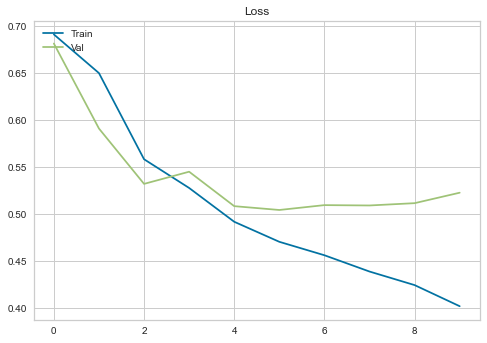

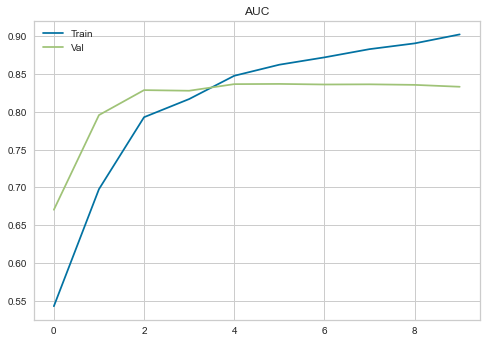

In [727]:
loss_curve = history.history["loss"]
acc_curve = history.history["auc"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

In [728]:
results = model.evaluate(X_test,y_test)

57/57 [==============================] - 1s 9ms/step - loss: 0.5751 - auc: 0.7990


In [729]:
results

[0.575120747089386, 0.798963725566864]

In [730]:
y_prob = model.predict(X_test)

57/57 [==============================] - 1s 8ms/step


0.7195508507520707


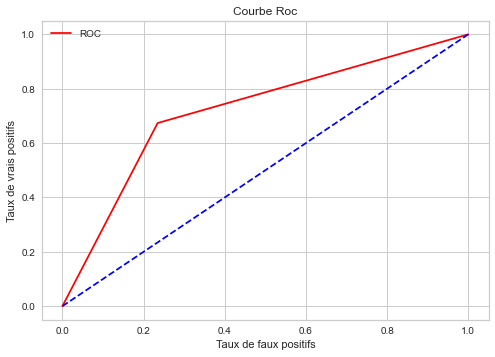

FULL Métrique Métier :  0.15178372352285396
Mean Absolute Error: 0.27814938684503904
Mean Squared Error: 0.27814938684503904
Root Mean Squared Error: 0.5273986981829203


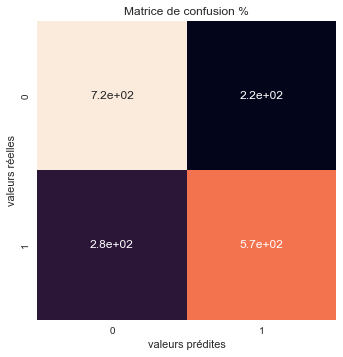

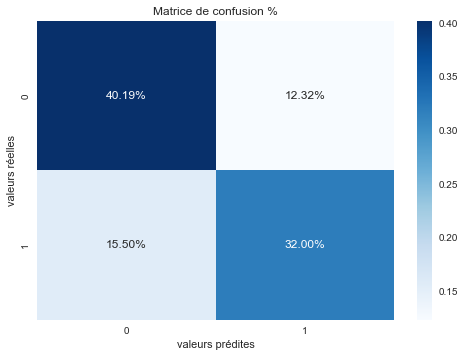


Sur le jeu de test auc : 0.720

Sur le jeu de test f1_score : 0.697

Sur le jeu de test precision : 0.722

Sur le jeu de test recall : 0.674


In [731]:
pipeline_training_metrics(y_prob, y_test)

Autre modèle simple sans embedding

In [542]:
df.shape

(5978, 9)

In [681]:
embedding_matrix_fasttext.shape

(8646, 300)

In [756]:
model = Sequential()
model.add(Embedding( 
  input_dim=8646, 
  output_dim=300, 
  input_length=190,
  trainable = True,
  mask_zero= True )) 
model.add(Dense(32, input_dim=8646))
###model.add(Flatten())
model.add(Activation('relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(113,activation='softmax'))binary_crossentropy
#model.compile(loss='mse',optimizer ='adam',metrics=['AUC'])
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss ='binary_crossentropy',metrics=['AUC'])

In [758]:
X_train, X_test, y_train, y_test = ml_ech(df)

In [759]:
X_train_ech, X_test_ech, y_train_ech, y_test_ech = pk_multi_sup.pipelineModel_TrainingSet(X_train, y_train, 0, 0.3)

In [750]:

model.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_80 (Embedding)    (None, 190, 300)          2593800   
                                                                 
 dense_199 (Dense)           (None, 190, 32)           9632      
                                                                 
 activation_67 (Activation)  (None, 190, 32)           0         
                                                                 
 flatten_82 (Flatten)        (None, 6080)              0         
                                                                 
 dense_200 (Dense)           (None, 1)                 6081      
                                                                 
Total params: 2,609,513
Trainable params: 2,609,513
Non-trainable params: 0
_________________________________________________________________


In [760]:
history = model.fit(X_train_ech, y_train_ech, validation_data=(X_test_ech, y_test_ech), epochs=10, batch_size=113)

Epoch 1/10
26/26 [==============================] - 2s 58ms/step - loss: 0.0278 - auc: 0.9998 - val_loss: 0.8852 - val_auc: 0.7829
Epoch 2/10
26/26 [==============================] - 2s 60ms/step - loss: 0.0223 - auc: 0.9999 - val_loss: 0.9362 - val_auc: 0.7777
Epoch 3/10
26/26 [==============================] - 1s 55ms/step - loss: 0.0185 - auc: 0.9999 - val_loss: 0.9789 - val_auc: 0.7744
Epoch 4/10
26/26 [==============================] - 1s 53ms/step - loss: 0.0161 - auc: 0.9999 - val_loss: 1.0253 - val_auc: 0.7728
Epoch 5/10
26/26 [==============================] - 1s 52ms/step - loss: 0.0132 - auc: 1.0000 - val_loss: 1.0661 - val_auc: 0.7709
Epoch 6/10
26/26 [==============================] - 2s 60ms/step - loss: 0.0118 - auc: 1.0000 - val_loss: 1.1049 - val_auc: 0.7712
Epoch 7/10
26/26 [==============================] - 1s 50ms/step - loss: 0.0107 - auc: 1.0000 - val_loss: 1.1448 - val_auc: 0.7692
Epoch 8/10
26/26 [==============================] - 1s 52ms/step - loss: 0.0093 - a

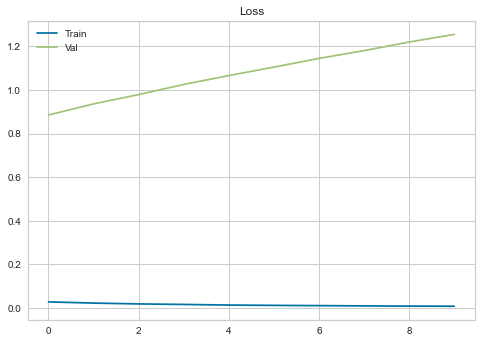

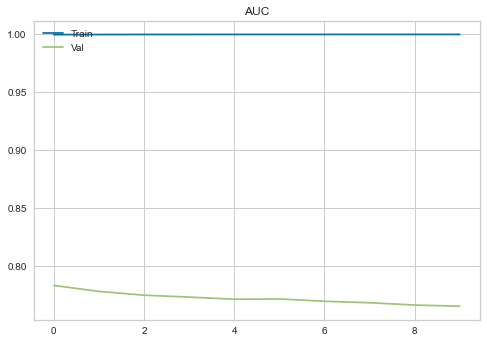

In [761]:
loss_curve = history.history["loss"]
acc_curve = history.history["auc"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

In [762]:
results = model.evaluate(X_test,y_test)

57/57 [==============================] - 0s 4ms/step - loss: 1.3279 - auc: 0.7389


In [763]:
y_prob = model.predict(X_test)


57/57 [==============================] - 0s 4ms/step


0.6809231183278012


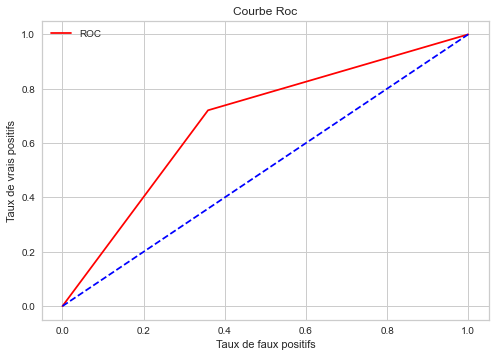

FULL Métrique Métier :  0.13823857302118173
Mean Absolute Error: 0.3210702341137124
Mean Squared Error: 0.3210702341137124
Root Mean Squared Error: 0.5666305975798628


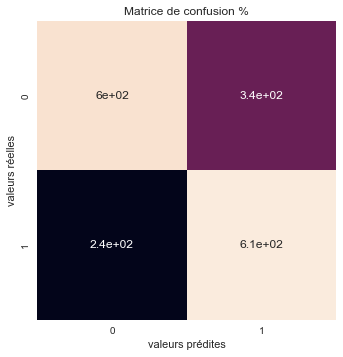

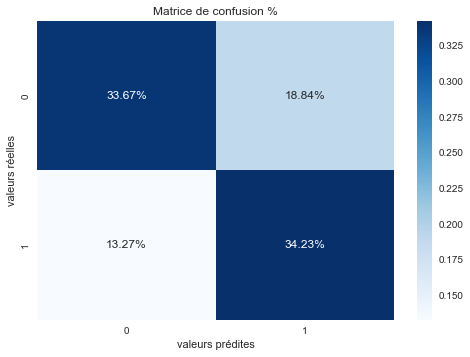


Sur le jeu de test auc : 0.681

Sur le jeu de test f1_score : 0.681

Sur le jeu de test precision : 0.645

Sur le jeu de test recall : 0.721


In [764]:
pipeline_training_metrics(y_prob, y_test)

Créons une fonction pour pouvoir utiliser ce modèle dans le pipeline

In [737]:
def funct_model_simple_ss_embed(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=8646, 
    output_dim=300, 
    input_length=190,
    trainable = True,
    mask_zero= True )) 
    model.add(Dense(32, input_dim=8646))
    ###model.add(Flatten())
    model.add(Activation('relu'))
    #model.add(Dense(25,kernel_initializer='normal',activation='relu'))
    #model.add(Dense(25,kernel_initializer='normal',activation='relu'))
    #model.add(Dense(113,activation='softmax'))binary_crossentropy
    #model.compile(loss='mse',optimizer ='adam',metrics=['AUC'])
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',loss ='binary_crossentropy',metrics=['AUC'])
    return model

In [38]:
models

method                                           function  parameters
0       1  <function funct_model_simple at 0x0000027C4A6F...  [0.2, 0.5]

In [42]:
params_model1 = []
params_model1.append(0.2)
params_model1.append(0.4)
params_model1.append(0.5)
params_model1.append(0.7)


In [55]:
#models = []
models.append([{"method":2, "function":funct_model_simple_ss_embed, "parameters":params_model1}])
#models.append({"method":2, model2})

method                                           function  \
0       1  <function funct_model_simple at 0x0000027C4A6F...   
0       2  <function funct_model_simple_ss_embed at 0x000...   

             parameters  
0            [0.2, 0.5]  
0  [0.2, 0.4, 0.5, 0.7]

## BILSTM

In [767]:
model = Sequential()
model.add(Embedding( 
  input_dim=8646, 
  output_dim=300, 
  input_length=190, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Bidirectional(LSTM(20, return_sequences=True), input_dim=8646))
model.add(Dense(30, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())
model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [242]:
from tensorflow.keras.optimizers import Adam

def funct_model_bilstm_embed_2(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=3622, 
    output_dim=300, 
    input_length=115, 
    weights= [embed],
    trainable = False,
    mask_zero= True )) 
    model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.01)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
        optimizer=adam, 
        metrics=['AUC']
    )
    return model

In [243]:
model_bilstm_Test = funct_model_bilstm_embed_2(embedding_matrix_fasttext, [0])

In [244]:
model_bilstm_Test.summary()

Model: "sequential_833"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_833 (Embedding)   (None, 115, 300)          1086600   
                                                                 
 bidirectional_127 (Bidirect  (None, 115, 128)         186880    
 ional)                                                          
                                                                 
 dropout_748 (Dropout)       (None, 115, 128)          0         
                                                                 
 bidirectional_128 (Bidirect  (None, 64)               41216     
 ional)                                                          
                                                                 
 dropout_749 (Dropout)       (None, 64)                0         
                                                                 
 dense_1553 (Dense)          (None, 64)             

In [222]:
def funct_model_bilstm_embed(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=3622, 
    output_dim=300, 
    input_length=115, 
    weights= [embed],
    trainable = False,
    mask_zero= True )) 
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_dim=3622))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.add(Flatten())
    model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
    return model

In [769]:
history_bilstm = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20,batch_size=113)

Epoch 1/20
38/38 [==============================] - 20s 527ms/step - loss: 0.4533 - auc: 0.8695 - val_loss: 0.5878 - val_auc: 0.7997
Epoch 2/20
38/38 [==============================] - 19s 508ms/step - loss: 0.4418 - auc: 0.8767 - val_loss: 0.6352 - val_auc: 0.7896
Epoch 3/20
38/38 [==============================] - 21s 543ms/step - loss: 0.4358 - auc: 0.8807 - val_loss: 0.6610 - val_auc: 0.7902
Epoch 4/20
38/38 [==============================] - 20s 521ms/step - loss: 0.4307 - auc: 0.8832 - val_loss: 0.7843 - val_auc: 0.7793
Epoch 5/20
38/38 [==============================] - 20s 538ms/step - loss: 0.4230 - auc: 0.8880 - val_loss: 0.8493 - val_auc: 0.7722
Epoch 6/20
38/38 [==============================] - 20s 536ms/step - loss: 0.4238 - auc: 0.8871 - val_loss: 0.6428 - val_auc: 0.7772
Epoch 7/20
38/38 [==============================] - 20s 529ms/step - loss: 0.4127 - auc: 0.8941 - val_loss: 0.7869 - val_auc: 0.7812
Epoch 8/20
38/38 [==============================] - 20s 526ms/step - 

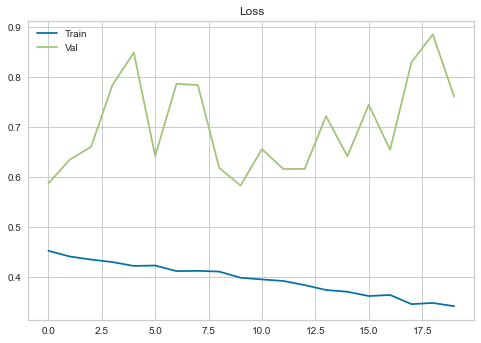

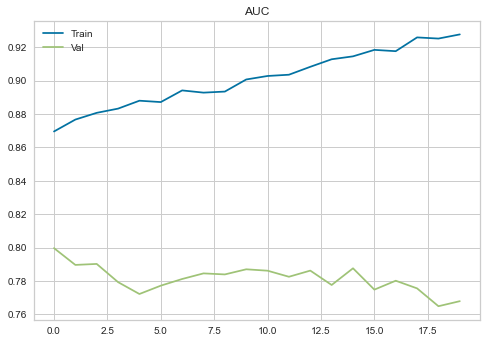

In [770]:
loss_curve = history_bilstm.history["loss"]
acc_curve = history_bilstm.history["auc"]

loss_val_curve = history_bilstm.history["val_loss"]
acc_val_curve = history_bilstm.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

In [771]:
y_prob = model.predict(X_test)

57/57 [==============================] - 9s 112ms/step


In [772]:
y_prob

array([[0.96531713],
       [0.9999841 ],
       [0.0408191 ],
       ...,
       [0.08780337],
       [0.49200505],
       [0.19176464]], dtype=float32)

0.7076119135193326


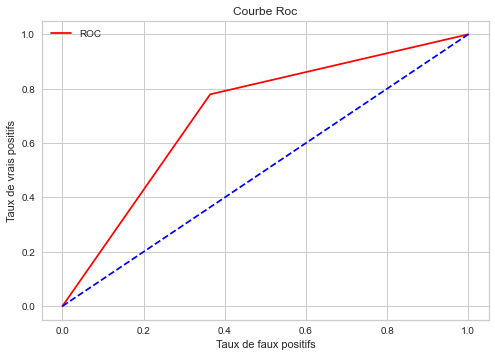

FULL Métrique Métier :  0.11343366778149389
Mean Absolute Error: 0.2959866220735786
Mean Squared Error: 0.2959866220735786
Root Mean Squared Error: 0.5440465256516014


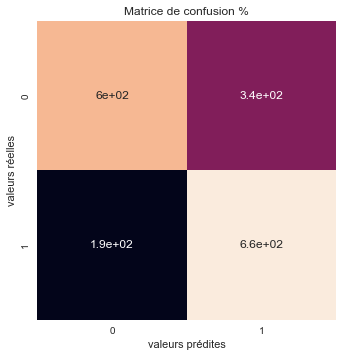

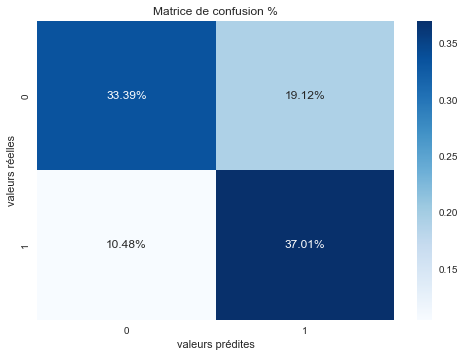


Sur le jeu de test auc : 0.708

Sur le jeu de test f1_score : 0.714

Sur le jeu de test precision : 0.659

Sur le jeu de test recall : 0.779


In [773]:
pipeline_training_metrics(y_prob, y_test)

Lancement du pipeline Modèle simple :

In [300]:
params_model1 = []
params_model1.append(0.2)
params_model1.append(0.4)
params_model1.append(0.6)

models = []
models.append({"method":1, "function":funct_model_simple, "parameters":params_model1})
models.append({"method":2, "function":funct_model_simple_ss_embed, "parameters":params_model1})
models.append({"method":3, "function":funct_model_bilstm_embed, "parameters":[0]})
models.append({"method":4, "function":funct_model_bilstm_embed_2, "parameters":[0]})
models = pd.DataFrame(models)

embeddings = []
embeddings.append({"name_embed":"fast text", "embed":embedding_matrix_fasttext})
embeddings.append({"name_embed":"glove", "embed":embedding_matrix_glove})
#models.append({"method":2, model2})
embeddings = pd.DataFrame(embeddings)

In [240]:
models

method                                           function parameters
0       4  <function funct_model_bilstm_embed_2 at 0x0000...        [0]

In [ ]:
y_train.values_count()

----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  fast text
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 7s 291ms/step - loss: 1.0746 - auc: 0.5010 - val_loss: 0.8275 - val_auc: 0.5407
Epoch 2/15
7/7 [==============================] - 1s 150ms/step - loss: 0.8577 - auc: 0.4854 - val_loss: 0.6925 - val_auc: 0.5223
Epoch 3/15
7/7 [==============================] - 1s 103ms/step - loss: 0.7701 - auc: 0.5152 - val_loss: 0.6924 - val_auc: 0.5895
Epoch 4/15
7/7 [==============================] - 1s 130ms/step - loss: 0.7341 - auc: 0.4892 - val_loss: 1.4275 - val_auc: 0.5026
Epoch 5/15
7/7 [==============================] - 1s 127ms/step - loss: 0.9318 - auc: 0.4815 - val_loss: 0.8169 - val_auc: 0.6053
Epoch 6/15
7

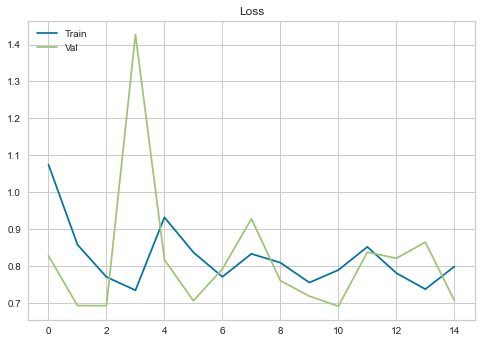

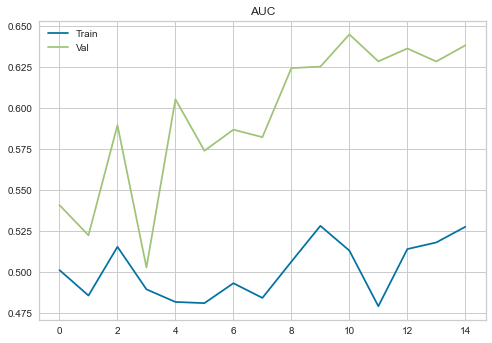

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 15s 509ms/step - loss: 1.1633 - auc: 0.4912 - val_loss: 0.9070 - val_auc: 0.5101
Epoch 2/15
7/7 [==============================] - 1s 209ms/step - loss: 0.7449 - auc: 0.5331 - val_loss: 0.7255 - val_auc: 0.5226
Epoch 3/15
7/7 [==============================] - 1s 163ms/step - loss: 0.8151 - auc: 0.4955 - val_loss: 0.8891 - val_auc: 0.5382
Epoch 4/15
7/7 [==============================] - 1s 87ms/step - loss: 0.7761 - auc: 0.5173 - val_loss: 0.6925 - val_auc: 0.5464
Epoch 5/15
7/7 [==============================] - 1s 123ms/step - loss: 0.7570 - auc: 0.5324 - val_loss: 0.7823 - val_auc: 0.5390
Epoch 6/15
7/7 [==============================] - 1s 133ms/step - loss: 0.7661 - auc: 0.5269 - val_loss: 0.7665 - val_auc: 0.5844
Epoch 7/15
7/7 [==============================] - 1

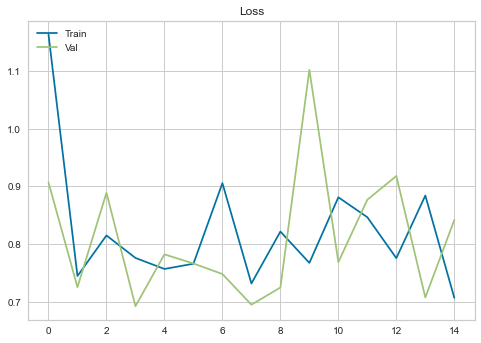

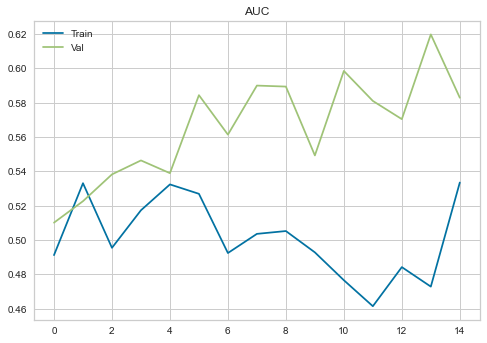

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 8s 375ms/step - loss: 1.0149 - auc: 0.5282 - val_loss: 0.7893 - val_auc: 0.5358
Epoch 2/15
7/7 [==============================] - 1s 78ms/step - loss: 0.8212 - auc: 0.5140 - val_loss: 0.9256 - val_auc: 0.5484
Epoch 3/15
7/7 [==============================] - 1s 87ms/step - loss: 0.9065 - auc: 0.4698 - val_loss: 0.7616 - val_auc: 0.5540
Epoch 4/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8094 - auc: 0.4826 - val_loss: 0.6930 - val_auc: 0.5761
Epoch 5/15
7/7 [==============================] - 1s 77ms/step - loss: 0.7400 - auc: 0.5181 - val_loss: 0.7146 - val_auc: 0.5870
Epoch 6/15
7/7 [==============================] - 1s 81ms/step - loss: 0.7446 - auc: 0.5172 - val_loss: 1.0477 - val_auc: 0.5589
Epoch 7/15
7/7 [==============================] - 0s 70m

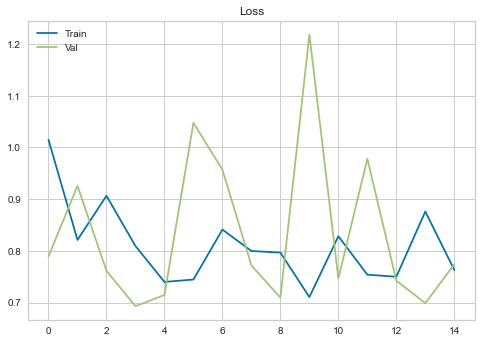

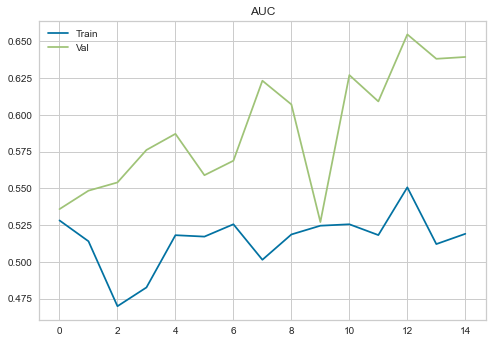

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed fast text
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 652.6704750061035
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 13ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


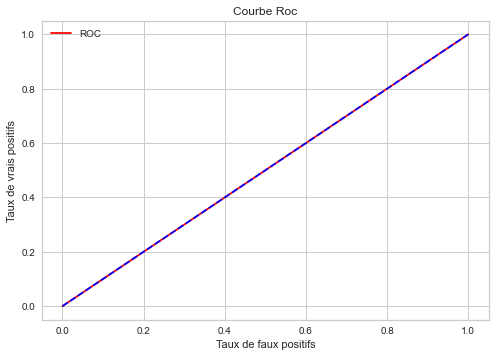

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


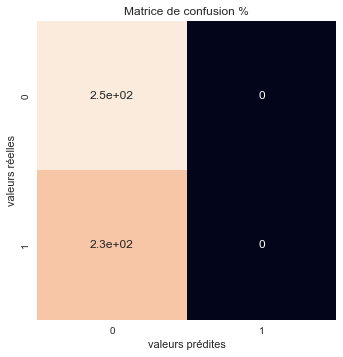

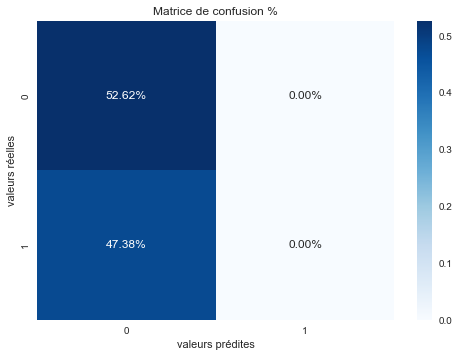


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  glove
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 9s 571ms/step - loss: 1.0094 - auc: 0.5371 - val_loss: 0.9473 - val_auc: 0.5722
Epoch 2/15
7/7 [==============================] - 0s 71ms/step - loss: 0.8848 - auc: 0.5010 - val_loss: 0.7618 - val_auc: 0.5867
Epoch 3/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7711 - auc: 0.5032 - val_loss: 0.9694 - val_auc: 0.6149
Epoch 4/15
7/7 [==============================] - 0s 73ms/step - loss: 0.8422 - auc: 0.4969 - val_loss: 0.6976 - val_auc: 0.6281
Epoch 5/15
7/7 [==============================] - 1s 76ms/step - loss: 0.6981 - auc: 0.5513 - val_loss: 0.7823 - val_auc: 0.6413
Epoch 6/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8583 - auc: 0.4976 - val_loss: 0.6899 - val_auc: 0.6405
Epoch 7/15
7/7 [==============================] - 1s 105ms/step - loss: 0.7988 - auc: 0.5017 - val_loss: 0.8338 - val_auc: 0.6546
Epoch 8/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8163 - auc: 0.5048 - v

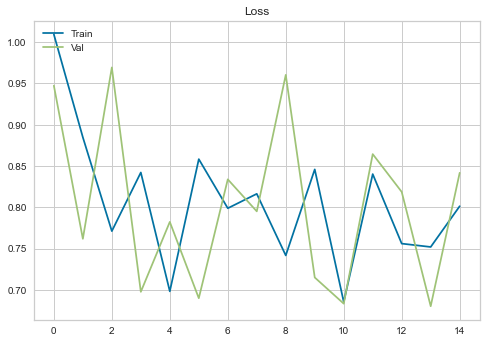

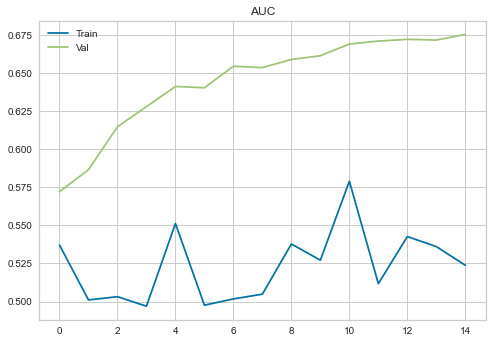

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 18s 963ms/step - loss: 1.0500 - auc: 0.5214 - val_loss: 0.7699 - val_auc: 0.5666
Epoch 2/15
7/7 [==============================] - 0s 73ms/step - loss: 0.7967 - auc: 0.5141 - val_loss: 0.8233 - val_auc: 0.5967
Epoch 3/15
7/7 [==============================] - 1s 88ms/step - loss: 0.7687 - auc: 0.5200 - val_loss: 0.8595 - val_auc: 0.6151
Epoch 4/15
7/7 [==============================] - 1s 89ms/step - loss: 0.8258 - auc: 0.5009 - val_loss: 0.7555 - val_auc: 0.6270
Epoch 5/15
7/7 [==============================] - 1s 78ms/step - loss: 0.7688 - auc: 0.5345 - val_loss: 0.6905 - val_auc: 0.6288
Epoch 6/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8076 - auc: 0.5112 - val_loss: 0.7299 - val_auc: 0.6387
Epoch 7/15
7/7 [==============================] - 0s 69

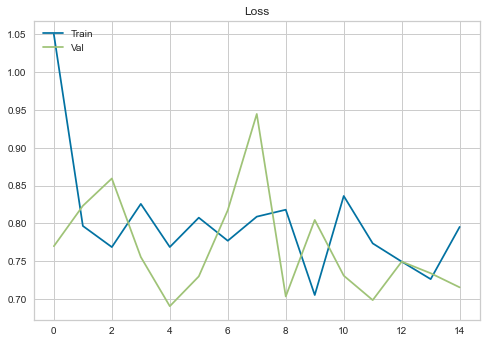

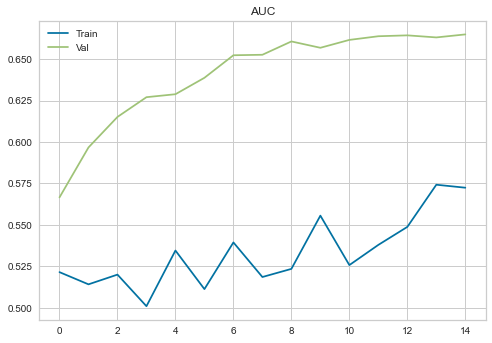

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 9s 479ms/step - loss: 1.1022 - auc: 0.4986 - val_loss: 0.9293 - val_auc: 0.5347
Epoch 2/15
7/7 [==============================] - 0s 68ms/step - loss: 0.7395 - auc: 0.5184 - val_loss: 0.7309 - val_auc: 0.5544
Epoch 3/15
7/7 [==============================] - 1s 75ms/step - loss: 0.7932 - auc: 0.5190 - val_loss: 0.9673 - val_auc: 0.5635
Epoch 4/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8162 - auc: 0.5284 - val_loss: 0.6987 - val_auc: 0.5756
Epoch 5/15
7/7 [==============================] - 0s 67ms/step - loss: 0.7778 - auc: 0.5174 - val_loss: 0.8337 - val_auc: 0.5941
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7826 - auc: 0.5276 - val_loss: 0.8821 - val_auc: 0.6044
Epoch 7/15
7/7 [==============================] - 0s 72m

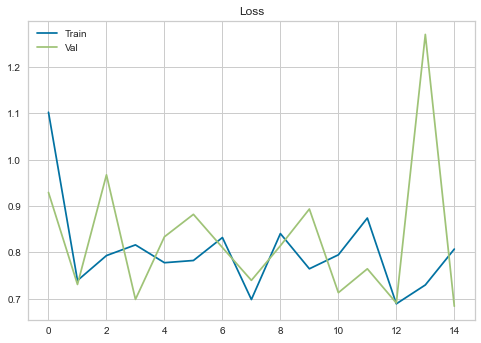

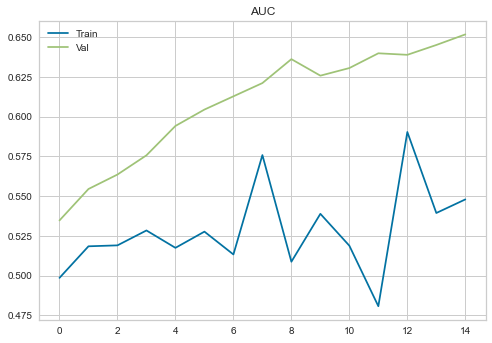

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed glove
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 77.9743287563324
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


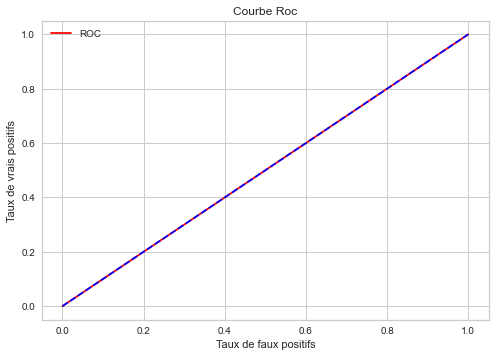

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


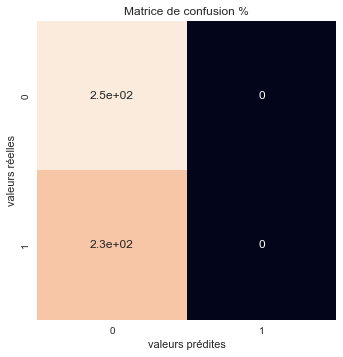

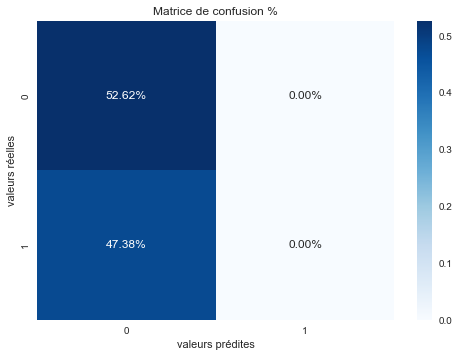


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  fast text
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 6s 267ms/step - loss: 1.0705 - auc: 0.4691 - val_loss: 0.9504 - val_auc: 0.5419
Epoch 2/15
7/7 [==============================] - 1s 89ms/step - loss: 0.7649 - auc: 0.5303 - val_loss: 0.7100 - val_auc: 0.5703
Epoch 3/15
7/7 [==============================] - 1s 76ms/step - loss: 0.8348 - auc: 0.5062 - val_loss: 0.7405 - val_auc: 0.5666
Epoch 4/15
7/7 [==============================] - 0s 73ms/step - loss: 0.7789 - auc: 0.5180 - val_loss: 0.9392 - val_auc: 0.5356
Epoch 5/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8435 - auc: 0.5237 - val_loss: 0.7539 - val_auc: 0.5919
Epoch 6/15
7/7 [==============================] - 0s 73ms/step - loss: 0.8732 - auc: 0.4692 - val_loss: 0.7012 - val_auc: 0.5869
Epoch 7/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8495 - auc: 0.4686 - val_loss: 0.7991 - val_auc: 0.5780
Epoch 8/15
7/7 [==============================] - 0s 67ms/step - loss: 0.7685 - auc: 0.4908 - va

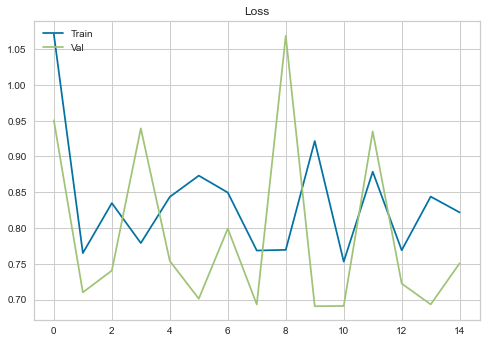

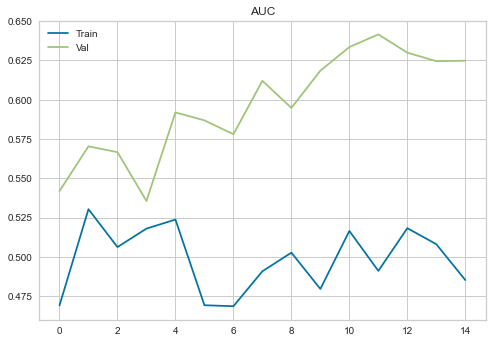

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 7s 441ms/step - loss: 1.0708 - auc: 0.5132 - val_loss: 1.0314 - val_auc: 0.5131
Epoch 2/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8720 - auc: 0.5047 - val_loss: 0.7570 - val_auc: 0.5435
Epoch 3/15
7/7 [==============================] - 0s 67ms/step - loss: 0.7791 - auc: 0.4951 - val_loss: 0.9006 - val_auc: 0.5459
Epoch 4/15
7/7 [==============================] - 0s 68ms/step - loss: 0.7751 - auc: 0.5177 - val_loss: 0.8711 - val_auc: 0.5579
Epoch 5/15
7/7 [==============================] - 1s 77ms/step - loss: 0.9455 - auc: 0.4694 - val_loss: 0.7084 - val_auc: 0.5817
Epoch 6/15
7/7 [==============================] - 0s 67ms/step - loss: 0.8046 - auc: 0.4834 - val_loss: 0.7338 - val_auc: 0.5799
Epoch 7/15
7/7 [==============================] - 0s 69m

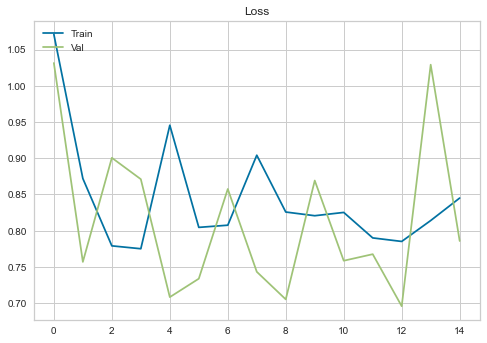

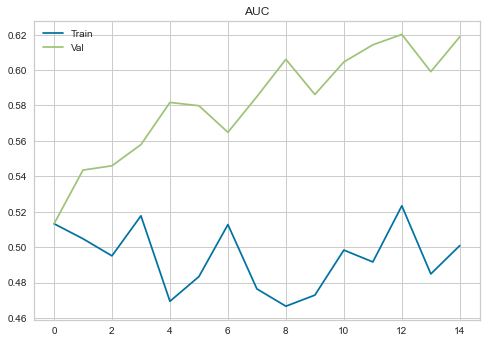

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 6s 316ms/step - loss: 1.2198 - auc: 0.4525 - val_loss: 0.8150 - val_auc: 0.5165
Epoch 2/15
7/7 [==============================] - 0s 68ms/step - loss: 0.7577 - auc: 0.5200 - val_loss: 0.7101 - val_auc: 0.5318
Epoch 3/15
7/7 [==============================] - 0s 70ms/step - loss: 0.9233 - auc: 0.4609 - val_loss: 0.8040 - val_auc: 0.5300
Epoch 4/15
7/7 [==============================] - 1s 81ms/step - loss: 0.7991 - auc: 0.4887 - val_loss: 0.7005 - val_auc: 0.5329
Epoch 5/15
7/7 [==============================] - 0s 67ms/step - loss: 0.8845 - auc: 0.4767 - val_loss: 0.6926 - val_auc: 0.5591
Epoch 6/15
7/7 [==============================] - 1s 87ms/step - loss: 0.8019 - auc: 0.5164 - val_loss: 0.8108 - val_auc: 0.5699
Epoch 7/15
7/7 [==============================] - 0s 68m

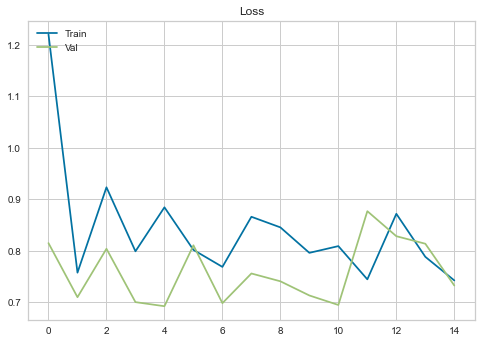

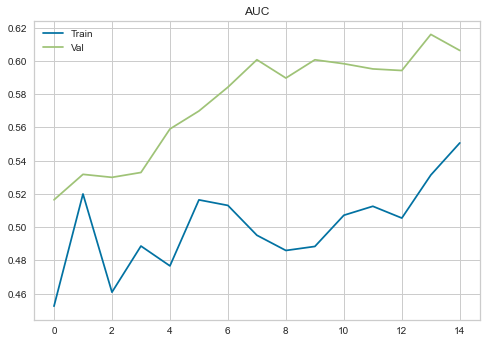

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed fast text
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 51.262563705444336
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


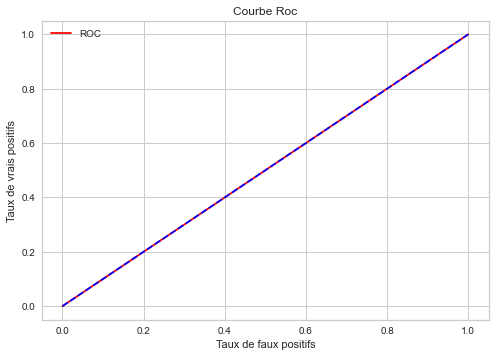

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


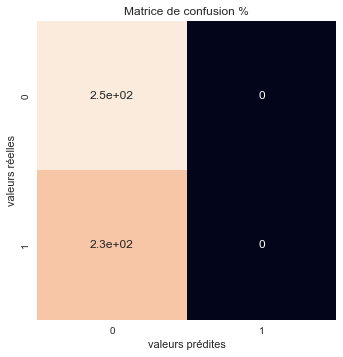

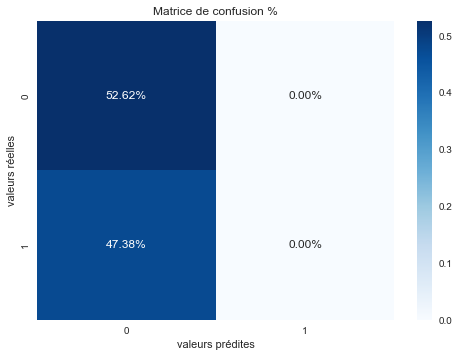


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  glove
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 4s 213ms/step - loss: 1.1122 - auc: 0.4885 - val_loss: 0.8103 - val_auc: 0.5281
Epoch 2/15
7/7 [==============================] - 1s 149ms/step - loss: 0.7393 - auc: 0.5256 - val_loss: 0.8319 - val_auc: 0.5388
Epoch 3/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8685 - auc: 0.5093 - val_loss: 0.7843 - val_auc: 0.5602
Epoch 4/15
7/7 [==============================] - 0s 72ms/step - loss: 0.7720 - auc: 0.5105 - val_loss: 0.7400 - val_auc: 0.5797
Epoch 5/15
7/7 [==============================] - 0s 73ms/step - loss: 0.8731 - auc: 0.4879 - val_loss: 0.6959 - val_auc: 0.5912
Epoch 6/15
7/7 [==============================] - 0s 69ms/step - loss: 0.7199 - auc: 0.5450 - val_loss: 0.7301 - val_auc: 0.6016
Epoch 7/15
7/7 [==============================] - 0s 69ms/step - loss: 0.9270 - auc: 0.4856 - val_loss: 0.6954 - val_auc: 0.6149
Epoch 8/15
7/7 [==============================] - 1s 81ms/step - loss: 0.8129 - auc: 0.4978 - v

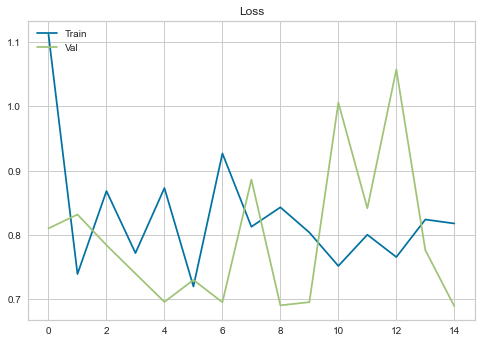

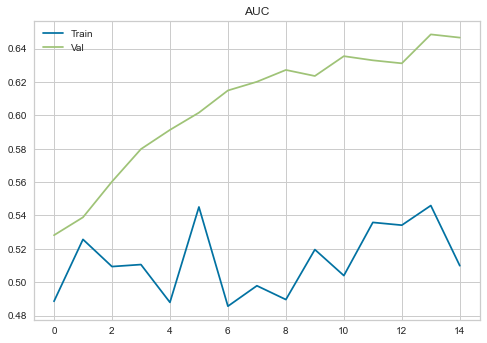

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 6s 270ms/step - loss: 1.0992 - auc: 0.5007 - val_loss: 0.9161 - val_auc: 0.5336
Epoch 2/15
7/7 [==============================] - 1s 68ms/step - loss: 0.8896 - auc: 0.4924 - val_loss: 0.9705 - val_auc: 0.5616
Epoch 3/15
7/7 [==============================] - 1s 82ms/step - loss: 0.7632 - auc: 0.5297 - val_loss: 0.7685 - val_auc: 0.5779
Epoch 4/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8290 - auc: 0.4999 - val_loss: 0.6951 - val_auc: 0.5839
Epoch 5/15
7/7 [==============================] - 1s 78ms/step - loss: 0.8688 - auc: 0.5007 - val_loss: 0.7133 - val_auc: 0.5867
Epoch 6/15
7/7 [==============================] - 0s 69ms/step - loss: 0.7357 - auc: 0.5360 - val_loss: 0.7434 - val_auc: 0.5988
Epoch 7/15
7/7 [==============================] - 0s 67m

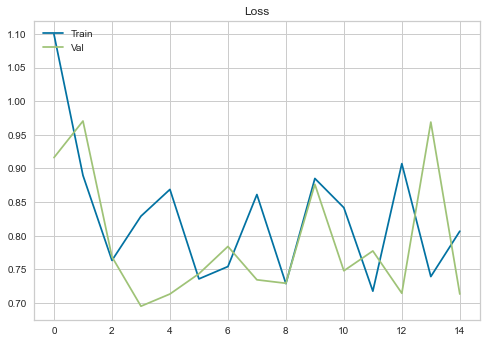

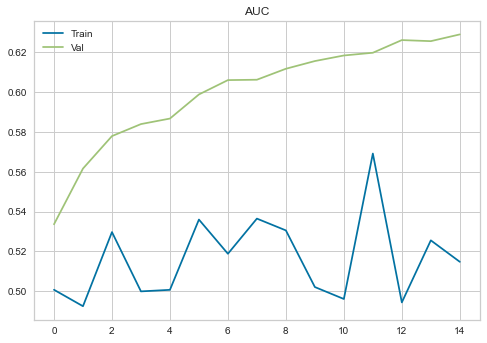

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 4s 183ms/step - loss: 1.0932 - auc: 0.4925 - val_loss: 0.7803 - val_auc: 0.5839
Epoch 2/15
7/7 [==============================] - 0s 73ms/step - loss: 0.8683 - auc: 0.4922 - val_loss: 0.7512 - val_auc: 0.6010
Epoch 3/15
7/7 [==============================] - 1s 77ms/step - loss: 0.8094 - auc: 0.4771 - val_loss: 0.9188 - val_auc: 0.6100
Epoch 4/15
7/7 [==============================] - 1s 76ms/step - loss: 0.7824 - auc: 0.5460 - val_loss: 0.7317 - val_auc: 0.6359
Epoch 5/15
7/7 [==============================] - 0s 71ms/step - loss: 0.7875 - auc: 0.5356 - val_loss: 0.6877 - val_auc: 0.6547
Epoch 6/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8457 - auc: 0.4932 - val_loss: 0.8214 - val_auc: 0.6667
Epoch 7/15
7/7 [==============================] - 0s 68m

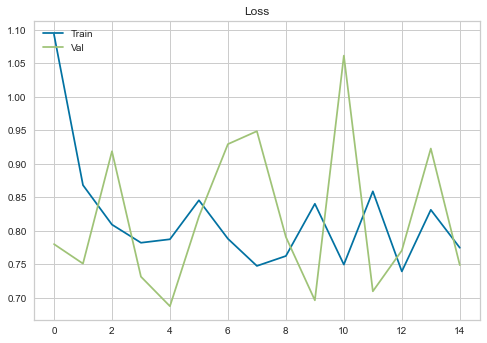

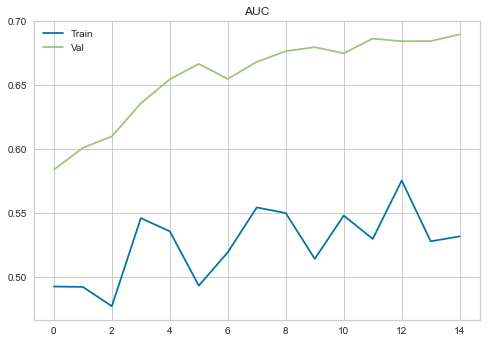

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed glove
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 45.83364129066467
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


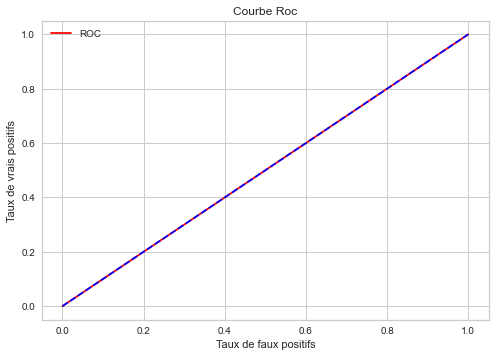

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


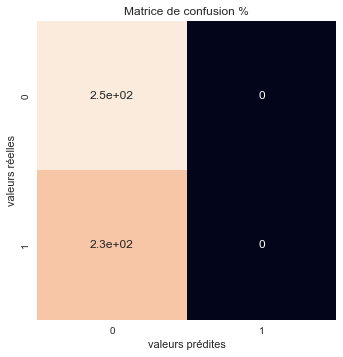

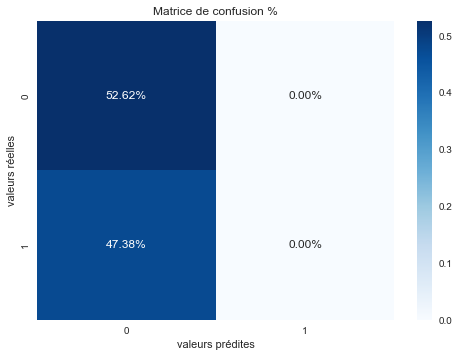


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  fast text
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 4s 175ms/step - loss: 1.1922 - auc: 0.4858 - val_loss: 0.7671 - val_auc: 0.5133
Epoch 2/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8574 - auc: 0.5052 - val_loss: 0.6997 - val_auc: 0.5337
Epoch 3/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8852 - auc: 0.4675 - val_loss: 0.8969 - val_auc: 0.5457
Epoch 4/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8329 - auc: 0.5080 - val_loss: 0.7128 - val_auc: 0.5635
Epoch 5/15
7/7 [==============================] - 0s 68ms/step - loss: 0.9136 - auc: 0.4774 - val_loss: 0.7551 - val_auc: 0.5641
Epoch 6/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8321 - auc: 0.4874 - val_loss: 0.7851 - val_auc: 0.5486
Epoch 7/15
7/7 [==============================] - 0s 67ms/step - loss: 0.8442 - auc: 0.5212 - val_loss: 0.6934 - val_auc: 0.5759
Epoch 8/15
7/7 [==============================] - 1s 77ms/step - loss: 0.8743 - auc: 0.4996 - va

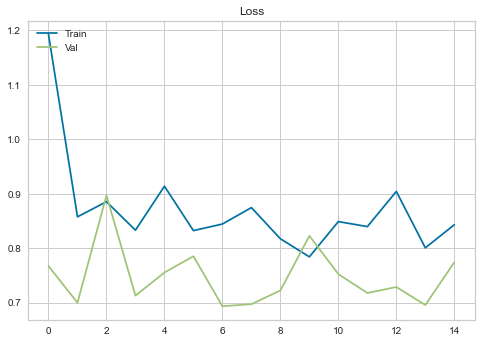

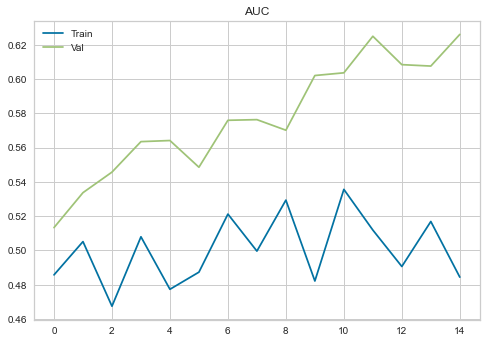

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 7s 805ms/step - loss: 1.0584 - auc: 0.5168 - val_loss: 0.9037 - val_auc: 0.4926
Epoch 2/15
7/7 [==============================] - 0s 68ms/step - loss: 0.9463 - auc: 0.4814 - val_loss: 0.6985 - val_auc: 0.5334
Epoch 3/15
7/7 [==============================] - 0s 71ms/step - loss: 0.7901 - auc: 0.5379 - val_loss: 0.6971 - val_auc: 0.5462
Epoch 4/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8052 - auc: 0.5213 - val_loss: 0.6987 - val_auc: 0.5626
Epoch 5/15
7/7 [==============================] - 0s 68ms/step - loss: 0.9395 - auc: 0.4685 - val_loss: 0.6927 - val_auc: 0.5648
Epoch 6/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8406 - auc: 0.5094 - val_loss: 0.6922 - val_auc: 0.5469
Epoch 7/15
7/7 [==============================] - 0s 67m

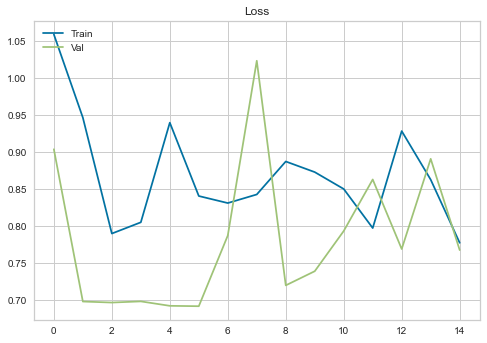

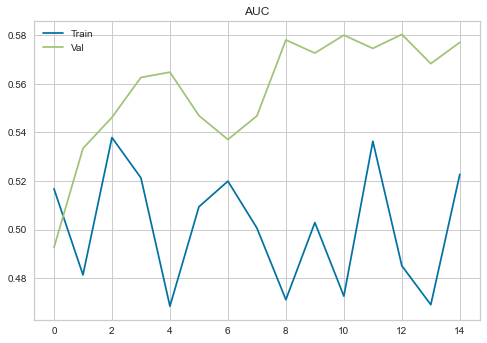

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 5s 158ms/step - loss: 1.1290 - auc: 0.4969 - val_loss: 0.7493 - val_auc: 0.4970
Epoch 2/15
7/7 [==============================] - 0s 66ms/step - loss: 0.8562 - auc: 0.4983 - val_loss: 0.7153 - val_auc: 0.5281
Epoch 3/15
7/7 [==============================] - 0s 68ms/step - loss: 0.7959 - auc: 0.5308 - val_loss: 0.7032 - val_auc: 0.5217
Epoch 4/15
7/7 [==============================] - 0s 66ms/step - loss: 0.7837 - auc: 0.5360 - val_loss: 0.9899 - val_auc: 0.5068
Epoch 5/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8188 - auc: 0.5517 - val_loss: 0.8310 - val_auc: 0.5542
Epoch 6/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8382 - auc: 0.5085 - val_loss: 0.8161 - val_auc: 0.5288
Epoch 7/15
7/7 [==============================] - 0s 72m

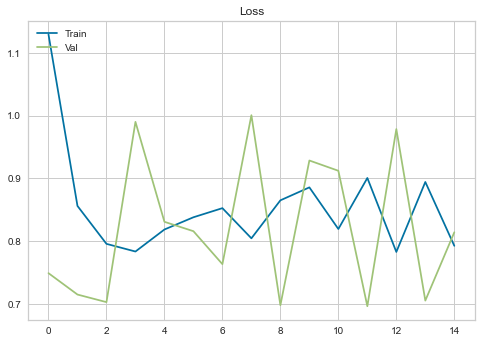

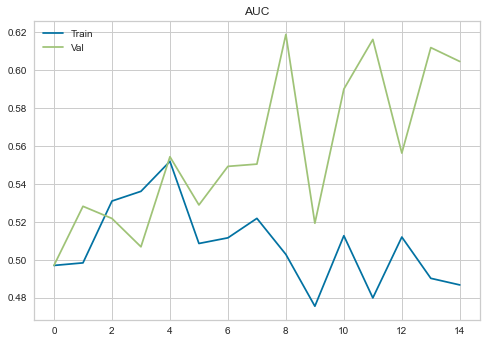

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed fast text
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 47.064223766326904
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


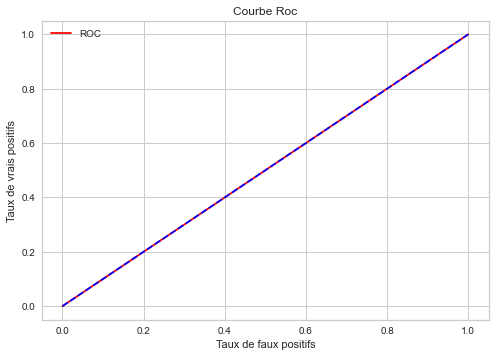

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


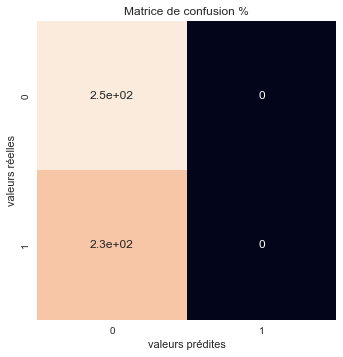

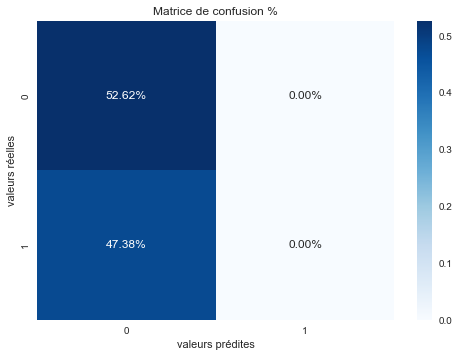


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  glove
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 3s 167ms/step - loss: 1.1526 - auc: 0.4827 - val_loss: 0.7536 - val_auc: 0.4884
Epoch 2/15
7/7 [==============================] - 1s 76ms/step - loss: 0.8732 - auc: 0.4764 - val_loss: 0.7280 - val_auc: 0.5359
Epoch 3/15
7/7 [==============================] - 0s 71ms/step - loss: 0.8036 - auc: 0.4879 - val_loss: 0.8888 - val_auc: 0.5759
Epoch 4/15
7/7 [==============================] - 1s 80ms/step - loss: 0.8540 - auc: 0.5239 - val_loss: 0.6961 - val_auc: 0.5867
Epoch 5/15
7/7 [==============================] - 1s 75ms/step - loss: 0.7807 - auc: 0.5259 - val_loss: 1.0007 - val_auc: 0.6194
Epoch 6/15
7/7 [==============================] - 1s 100ms/step - loss: 0.8701 - auc: 0.5173 - val_loss: 0.8350 - val_auc: 0.6258
Epoch 7/15
7/7 [==============================] - 1s 83ms/step - loss: 0.8070 - auc: 0.5400 - val_loss: 0.7199 - val_auc: 0.6430
Epoch 8/15
7/7 [==============================] - 1s 76ms/step - loss: 0.8289 - auc: 0.5181 - v

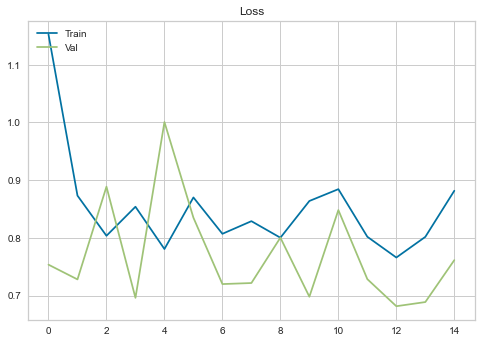

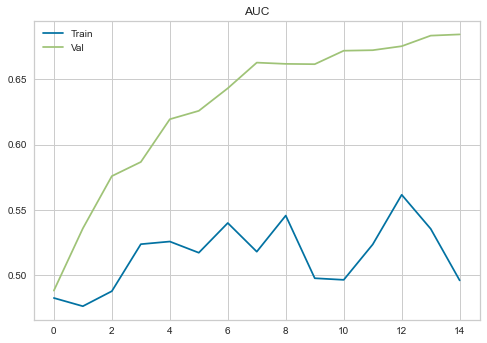

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 2s 166ms/step - loss: 1.1351 - auc: 0.4894 - val_loss: 0.7049 - val_auc: 0.5824
Epoch 2/15
7/7 [==============================] - 0s 73ms/step - loss: 0.8571 - auc: 0.4916 - val_loss: 0.8132 - val_auc: 0.6229
Epoch 3/15
7/7 [==============================] - 0s 74ms/step - loss: 0.8279 - auc: 0.5175 - val_loss: 0.7201 - val_auc: 0.6171
Epoch 4/15
7/7 [==============================] - 0s 72ms/step - loss: 0.9045 - auc: 0.4900 - val_loss: 0.7679 - val_auc: 0.6335
Epoch 5/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8469 - auc: 0.4947 - val_loss: 0.7097 - val_auc: 0.6238
Epoch 6/15
7/7 [==============================] - 0s 73ms/step - loss: 0.8590 - auc: 0.4921 - val_loss: 0.8603 - val_auc: 0.6356
Epoch 7/15
7/7 [==============================] - 0s 73m

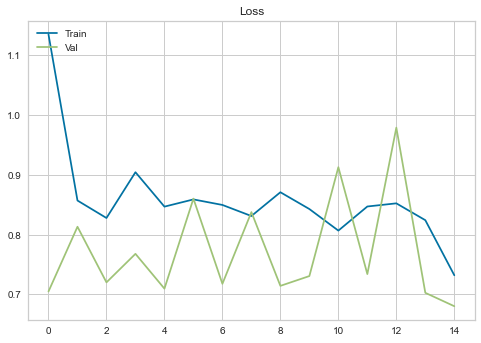

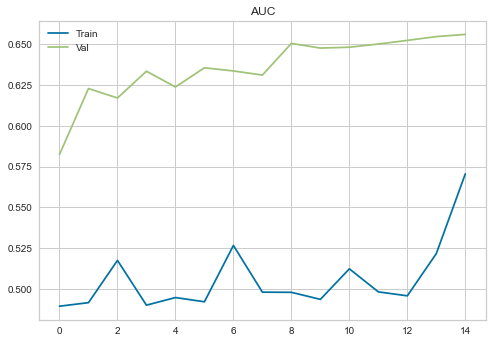

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 150ms/step - loss: 1.1737 - auc: 0.4807 - val_loss: 0.7387 - val_auc: 0.4961
Epoch 2/15
7/7 [==============================] - 0s 74ms/step - loss: 0.7864 - auc: 0.5036 - val_loss: 0.6928 - val_auc: 0.5057
Epoch 3/15
7/7 [==============================] - 1s 79ms/step - loss: 0.9660 - auc: 0.4619 - val_loss: 0.7769 - val_auc: 0.5360
Epoch 4/15
7/7 [==============================] - 0s 71ms/step - loss: 0.8468 - auc: 0.4960 - val_loss: 1.1406 - val_auc: 0.5519
Epoch 5/15
7/7 [==============================] - 1s 77ms/step - loss: 0.8845 - auc: 0.4764 - val_loss: 0.7078 - val_auc: 0.5472
Epoch 6/15
7/7 [==============================] - 0s 72ms/step - loss: 0.8962 - auc: 0.4919 - val_loss: 0.7090 - val_auc: 0.5605
Epoch 7/15
7/7 [==============================] - 0s 73m

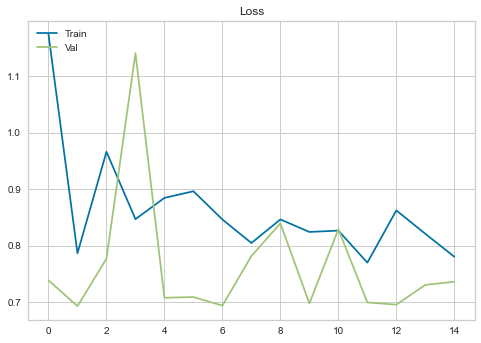

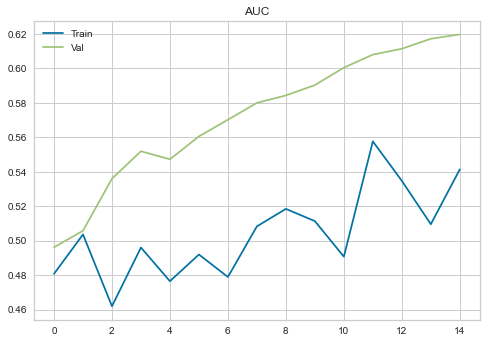

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed glove
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 40.1942195892334
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 10ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


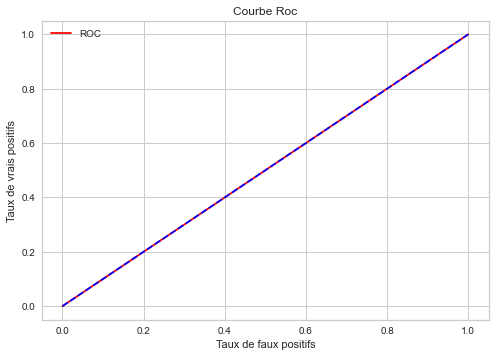

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


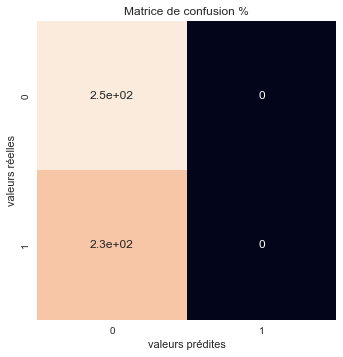

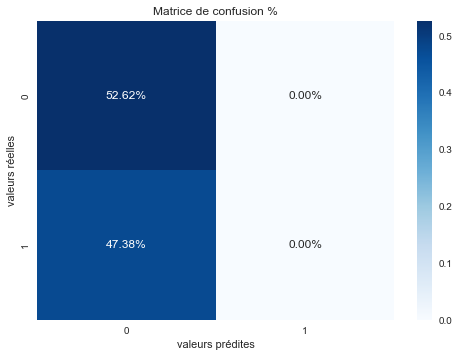


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  fast text
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 3s 177ms/step - loss: 1.0987 - auc: 0.5023 - val_loss: 0.6971 - val_auc: 0.5252
Epoch 2/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8353 - auc: 0.4926 - val_loss: 0.7019 - val_auc: 0.5122
Epoch 3/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7154 - auc: 0.5322 - val_loss: 0.7878 - val_auc: 0.6112
Epoch 4/15
7/7 [==============================] - 1s 97ms/step - loss: 0.8426 - auc: 0.5012 - val_loss: 0.7643 - val_auc: 0.5814
Epoch 5/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7188 - auc: 0.5376 - val_loss: 0.7871 - val_auc: 0.6201
Epoch 6/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7726 - auc: 0.5342 - val_loss: 0.6976 - val_auc: 0.6284
Epoch 7/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7373 - auc: 0.5358 - val_loss: 0.9061 - val_auc: 0.6109
Epoch 8/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8155 - auc: 0.5189 - va

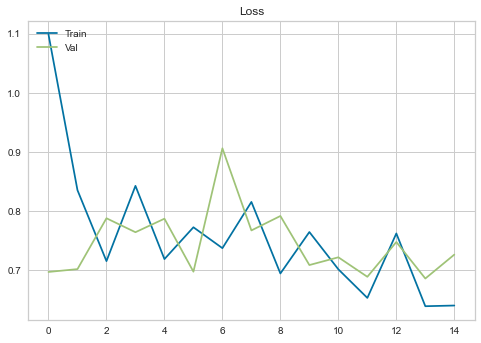

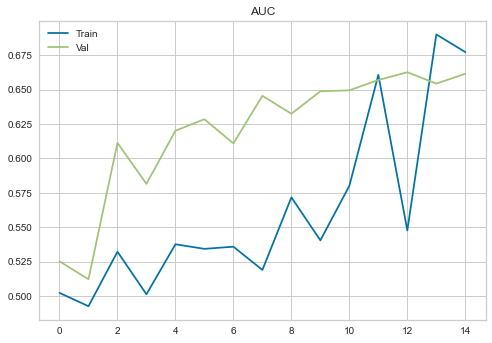

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 181ms/step - loss: 1.0111 - auc: 0.5388 - val_loss: 1.1406 - val_auc: 0.5000
Epoch 2/15
7/7 [==============================] - 1s 89ms/step - loss: 0.8634 - auc: 0.5227 - val_loss: 0.8475 - val_auc: 0.5598
Epoch 3/15
7/7 [==============================] - 1s 86ms/step - loss: 0.7853 - auc: 0.5140 - val_loss: 0.8634 - val_auc: 0.5655
Epoch 4/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8020 - auc: 0.5058 - val_loss: 0.7078 - val_auc: 0.5930
Epoch 5/15
7/7 [==============================] - 1s 88ms/step - loss: 0.7938 - auc: 0.4810 - val_loss: 0.8684 - val_auc: 0.5793
Epoch 6/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7576 - auc: 0.5312 - val_loss: 0.7416 - val_auc: 0.5718
Epoch 7/15
7/7 [==============================] - 1s 91m

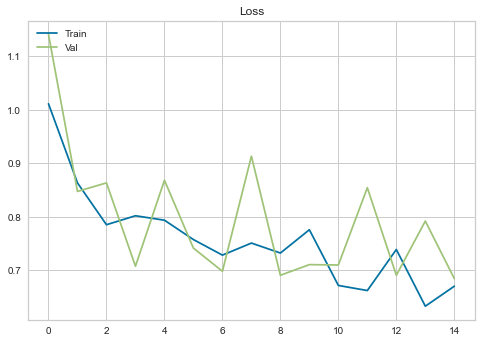

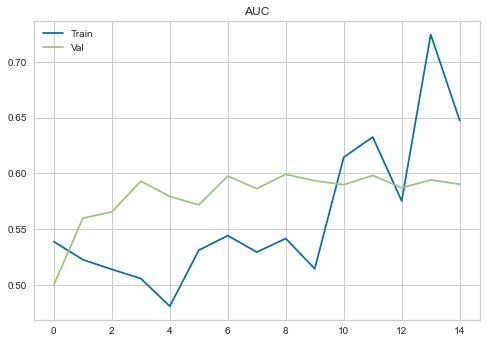

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 3s 157ms/step - loss: 1.0730 - auc: 0.5074 - val_loss: 0.8573 - val_auc: 0.5085
Epoch 2/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7769 - auc: 0.5038 - val_loss: 0.7302 - val_auc: 0.5680
Epoch 3/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8512 - auc: 0.4743 - val_loss: 0.9055 - val_auc: 0.5798
Epoch 4/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7590 - auc: 0.4977 - val_loss: 0.7017 - val_auc: 0.6134
Epoch 5/15
7/7 [==============================] - 1s 97ms/step - loss: 0.7171 - auc: 0.5582 - val_loss: 0.7220 - val_auc: 0.6195
Epoch 6/15
7/7 [==============================] - 1s 99ms/step - loss: 0.8342 - auc: 0.5026 - val_loss: 0.7423 - val_auc: 0.6238
Epoch 7/15
7/7 [==============================] - 1s 96m

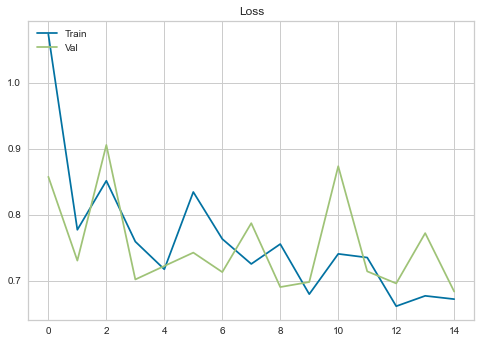

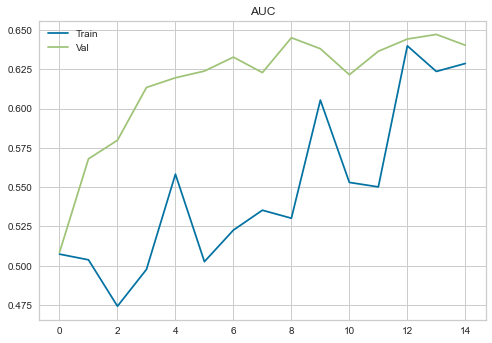

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed fast text
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 46.34656000137329
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


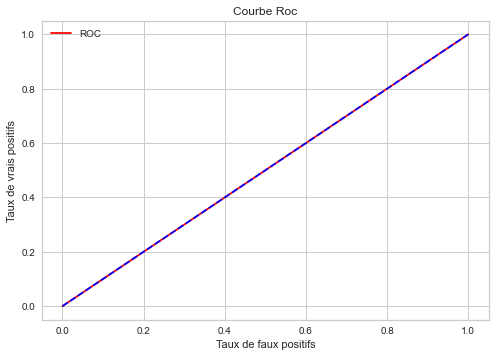

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


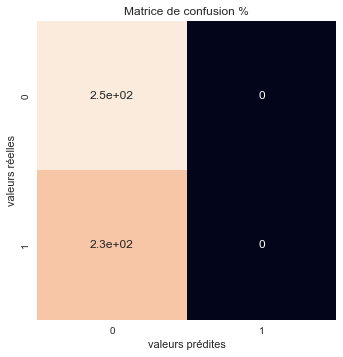

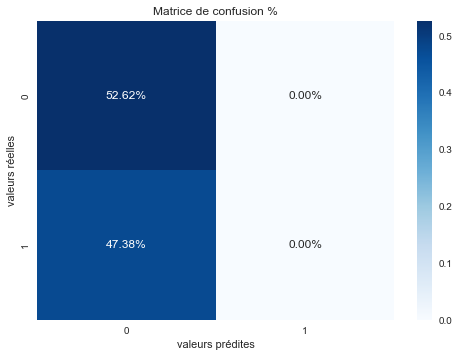


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  glove
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 [==============================] - 3s 145ms/step - loss: 1.1272 - auc: 0.4966 - val_loss: 0.8981 - val_auc: 0.4968
Epoch 2/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8148 - auc: 0.4785 - val_loss: 0.7533 - val_auc: 0.5185
Epoch 3/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8724 - auc: 0.4595 - val_loss: 0.7334 - val_auc: 0.5307
Epoch 4/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7179 - auc: 0.5342 - val_loss: 0.8352 - val_auc: 0.5264
Epoch 5/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8351 - auc: 0.5243 - val_loss: 0.6921 - val_auc: 0.5642
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7744 - auc: 0.5010 - val_loss: 0.8607 - val_auc: 0.5675
Epoch 7/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7911 - auc: 0.5004 - val_loss: 0.8168 - val_auc: 0.5634
Epoch 8/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7696 - auc: 0.5069 - val_loss: 0.9

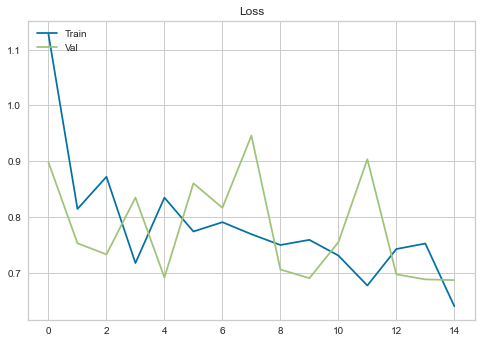

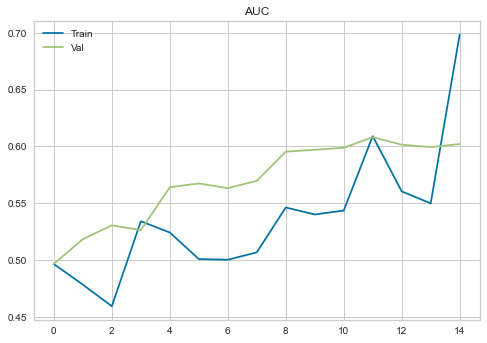

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 170ms/step - loss: 1.0735 - auc: 0.5051 - val_loss: 0.7327 - val_auc: 0.5140
Epoch 2/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7456 - auc: 0.5318 - val_loss: 0.7541 - val_auc: 0.5465
Epoch 3/15
7/7 [==============================] - 1s 111ms/step - loss: 0.8098 - auc: 0.5001 - val_loss: 0.8450 - val_auc: 0.5243
Epoch 4/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7558 - auc: 0.5250 - val_loss: 0.7613 - val_auc: 0.5650
Epoch 5/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7609 - auc: 0.5446 - val_loss: 0.8146 - val_auc: 0.5681
Epoch 6/15
7/7 [==============================] - 1s 97ms/step - loss: 0.7465 - auc: 0.5217 - val_loss: 0.8810 - val_auc: 0.5869
Epoch 7/15
7/7 [==============================] - 1s 91

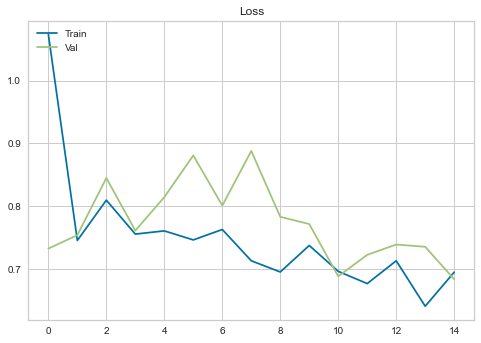

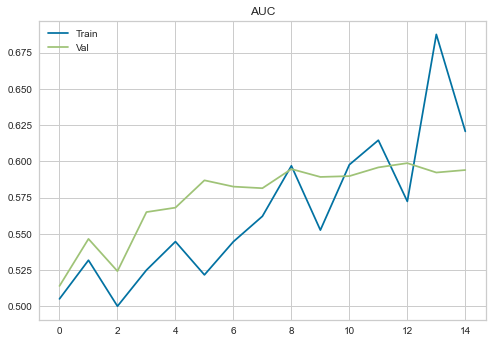

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 173ms/step - loss: 0.9810 - auc: 0.5117 - val_loss: 0.8857 - val_auc: 0.5425
Epoch 2/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8732 - auc: 0.5041 - val_loss: 0.7584 - val_auc: 0.5599
Epoch 3/15
7/7 [==============================] - 1s 114ms/step - loss: 0.7330 - auc: 0.5109 - val_loss: 0.7726 - val_auc: 0.5806
Epoch 4/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7960 - auc: 0.5319 - val_loss: 0.7544 - val_auc: 0.5970
Epoch 5/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7584 - auc: 0.5134 - val_loss: 0.9930 - val_auc: 0.5871
Epoch 6/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7665 - auc: 0.5427 - val_loss: 0.7235 - val_auc: 0.5951
Epoch 7/15
7/7 [==============================] - 1s 94

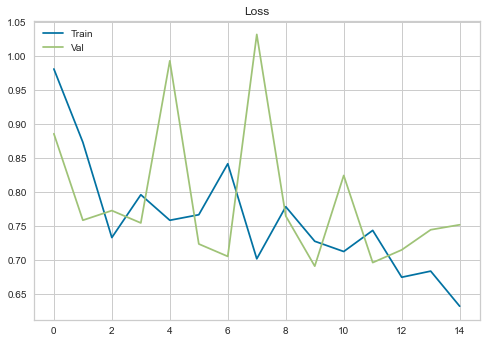

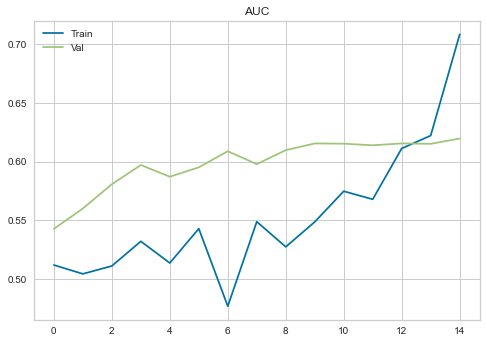

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed glove
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 44.80098271369934
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


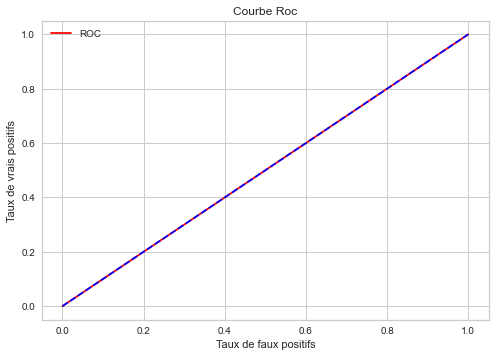

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


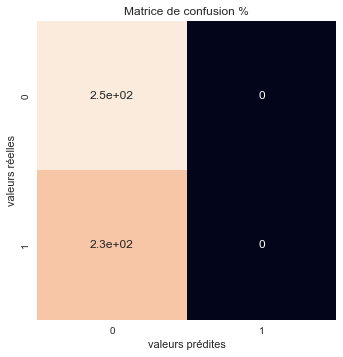

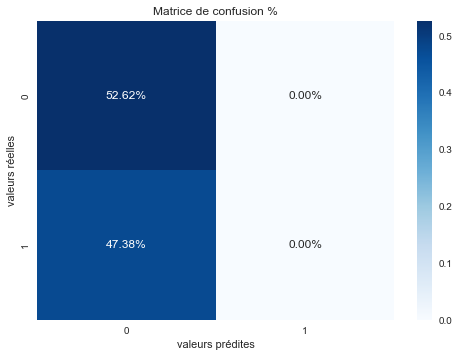


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  fast text
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 3s 191ms/step - loss: 1.0542 - auc: 0.5199 - val_loss: 0.9552 - val_auc: 0.5001
Epoch 2/15
7/7 [==============================] - 1s 98ms/step - loss: 0.8582 - auc: 0.4867 - val_loss: 0.6922 - val_auc: 0.5854
Epoch 3/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7518 - auc: 0.5109 - val_loss: 0.7833 - val_auc: 0.5922
Epoch 4/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7745 - auc: 0.5400 - val_loss: 0.7749 - val_auc: 0.6148
Epoch 5/15
7/7 [==============================] - 1s 94ms/step - loss: 0.8663 - auc: 0.5032 - val_loss: 0.7730 - val_auc: 0.6093
Epoch 6/15
7/7 [==============================] - 2s 376ms/step - loss: 0.7595 - auc: 0.5182 - val_loss: 0.7327 - val_auc: 0.6062
Epoch 7/15
7/7 [==============================] - 1s 97ms/step - loss: 0.7143 - auc: 0.5423 - val_loss: 0.7709 - val_auc: 0.6389
Epoch 8/15
7/7 [==============================] - 1s 104ms/step - loss: 0.7496 - auc: 0.5601 - 

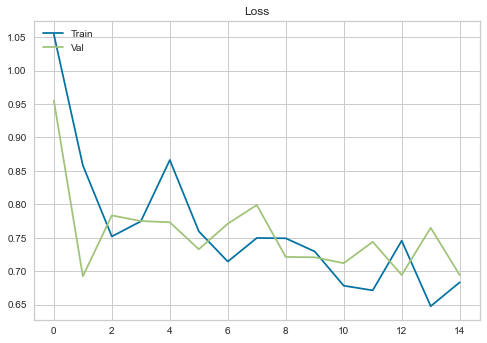

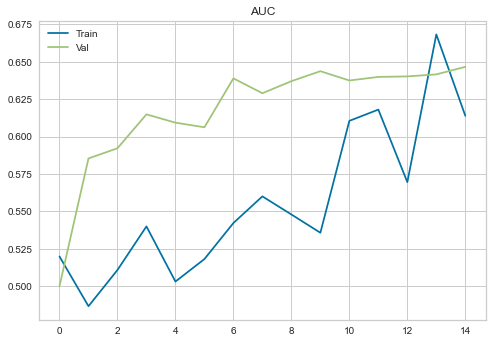

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 216ms/step - loss: 1.1073 - auc: 0.4869 - val_loss: 0.8169 - val_auc: 0.5448
Epoch 2/15
7/7 [==============================] - 1s 103ms/step - loss: 0.8332 - auc: 0.5168 - val_loss: 0.8204 - val_auc: 0.5780
Epoch 3/15
7/7 [==============================] - 1s 95ms/step - loss: 0.8115 - auc: 0.4807 - val_loss: 0.7363 - val_auc: 0.5988
Epoch 4/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7769 - auc: 0.5500 - val_loss: 0.7031 - val_auc: 0.5989
Epoch 5/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7158 - auc: 0.5446 - val_loss: 0.8972 - val_auc: 0.5628
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8430 - auc: 0.5104 - val_loss: 0.6913 - val_auc: 0.6046
Epoch 7/15
7/7 [==============================] - 1s 99

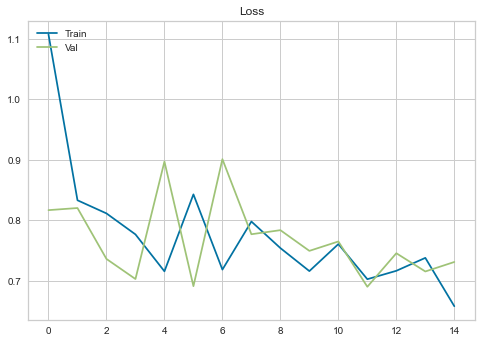

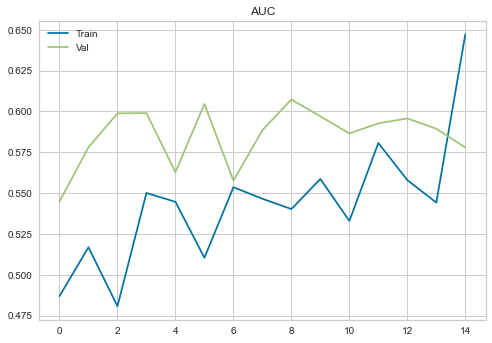

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 144ms/step - loss: 0.9935 - auc: 0.5206 - val_loss: 1.1870 - val_auc: 0.5000
Epoch 2/15
7/7 [==============================] - 1s 95ms/step - loss: 0.8745 - auc: 0.4705 - val_loss: 0.7101 - val_auc: 0.5024
Epoch 3/15
7/7 [==============================] - 1s 96ms/step - loss: 0.7196 - auc: 0.5458 - val_loss: 0.8683 - val_auc: 0.5178
Epoch 4/15
7/7 [==============================] - 1s 96ms/step - loss: 0.8146 - auc: 0.5535 - val_loss: 0.6932 - val_auc: 0.5140
Epoch 5/15
7/7 [==============================] - 1s 128ms/step - loss: 0.7912 - auc: 0.5183 - val_loss: 0.6924 - val_auc: 0.5708
Epoch 6/15
7/7 [==============================] - 1s 102ms/step - loss: 0.7506 - auc: 0.5156 - val_loss: 0.9205 - val_auc: 0.5792
Epoch 7/15
7/7 [==============================] - 1s 9

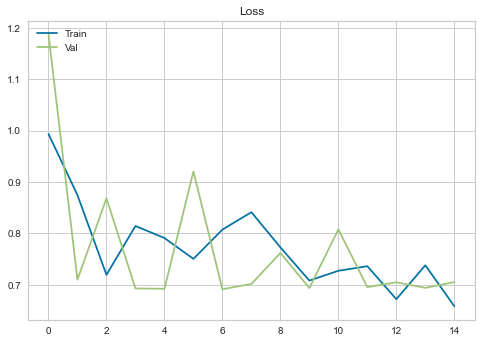

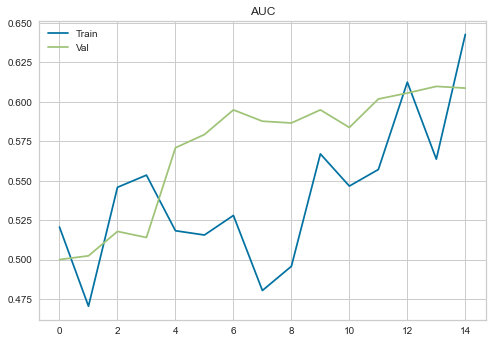

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed fast text
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 47.71163582801819
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 10ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


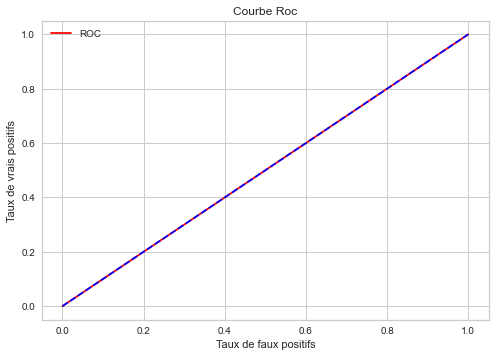

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


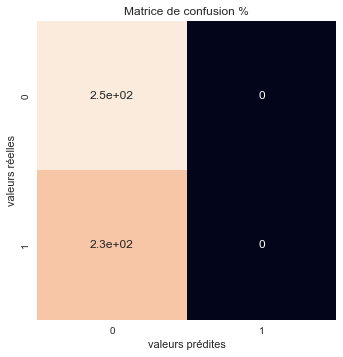

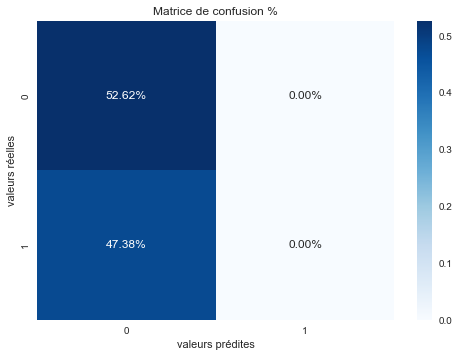


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  glove
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 2s 178ms/step - loss: 1.0677 - auc: 0.4914 - val_loss: 0.8286 - val_auc: 0.5458
Epoch 2/15
7/7 [==============================] - 1s 99ms/step - loss: 0.7604 - auc: 0.5330 - val_loss: 0.7228 - val_auc: 0.5123
Epoch 3/15
7/7 [==============================] - 1s 94ms/step - loss: 0.8400 - auc: 0.4950 - val_loss: 0.6966 - val_auc: 0.5516
Epoch 4/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7978 - auc: 0.5026 - val_loss: 0.7078 - val_auc: 0.5367
Epoch 5/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7213 - auc: 0.5533 - val_loss: 0.6973 - val_auc: 0.5493
Epoch 6/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7190 - auc: 0.5341 - val_loss: 0.8581 - val_auc: 0.5263
Epoch 7/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8632 - auc: 0.5215 - val_loss: 0.7931 - val_auc: 0.5558
Epoch 8/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7905 - auc: 0.5050 - va

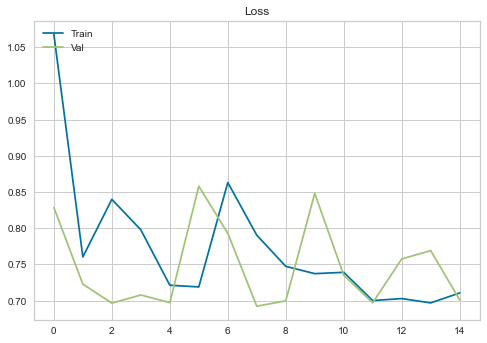

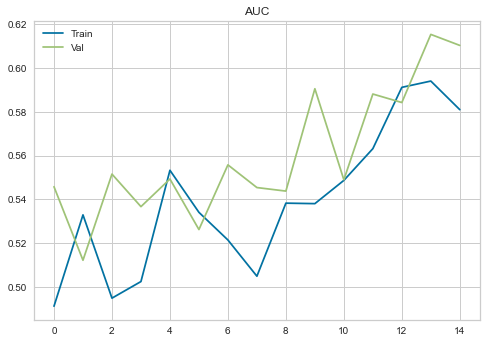

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 2s 165ms/step - loss: 1.0560 - auc: 0.5463 - val_loss: 0.6970 - val_auc: 0.5365
Epoch 2/15
7/7 [==============================] - 1s 96ms/step - loss: 0.8104 - auc: 0.4771 - val_loss: 0.9773 - val_auc: 0.5235
Epoch 3/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8083 - auc: 0.5105 - val_loss: 0.8053 - val_auc: 0.5368
Epoch 4/15
7/7 [==============================] - 1s 95ms/step - loss: 0.8095 - auc: 0.4933 - val_loss: 0.7338 - val_auc: 0.5681
Epoch 5/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7549 - auc: 0.5274 - val_loss: 0.7287 - val_auc: 0.5739
Epoch 6/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7868 - auc: 0.5213 - val_loss: 0.7765 - val_auc: 0.5700
Epoch 7/15
7/7 [==============================] - 1s 93m

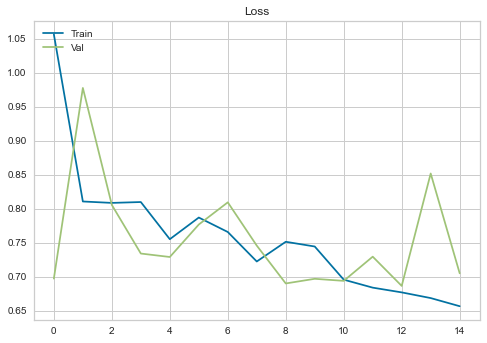

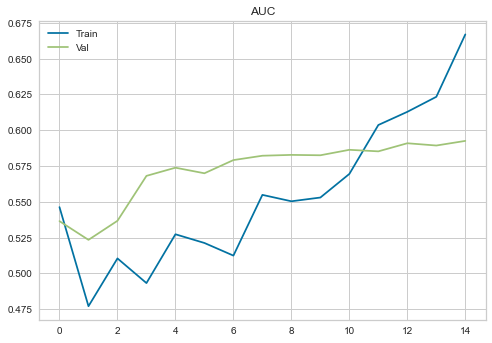

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 3s 166ms/step - loss: 1.1435 - auc: 0.4704 - val_loss: 0.9531 - val_auc: 0.5414
Epoch 2/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7856 - auc: 0.5250 - val_loss: 0.9154 - val_auc: 0.5327
Epoch 3/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8505 - auc: 0.4900 - val_loss: 0.9047 - val_auc: 0.4800
Epoch 4/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7930 - auc: 0.5110 - val_loss: 0.8349 - val_auc: 0.5116
Epoch 5/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7508 - auc: 0.5460 - val_loss: 0.6981 - val_auc: 0.5620
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8382 - auc: 0.4952 - val_loss: 0.8387 - val_auc: 0.4971
Epoch 7/15
7/7 [==============================] - 1s 93m

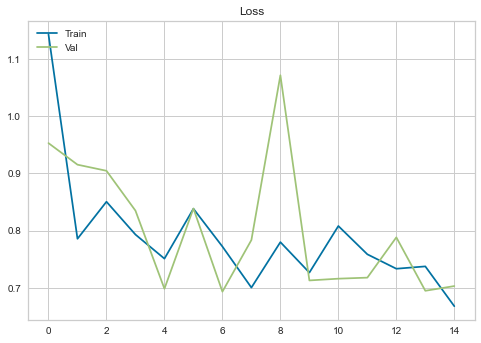

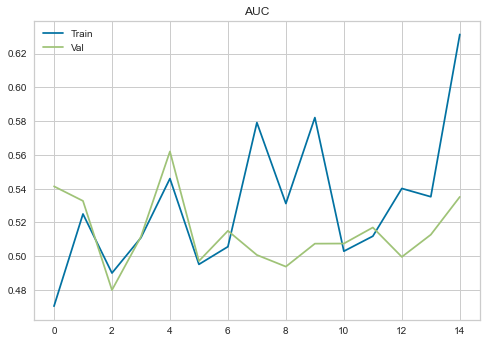

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed glove
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 46.65525197982788
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


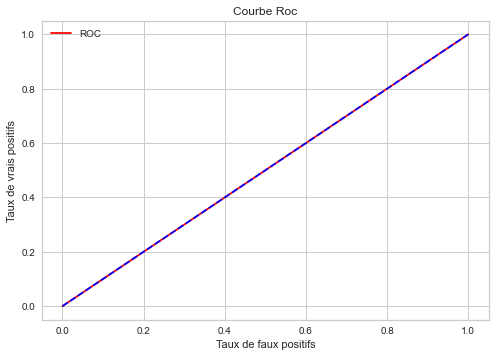

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


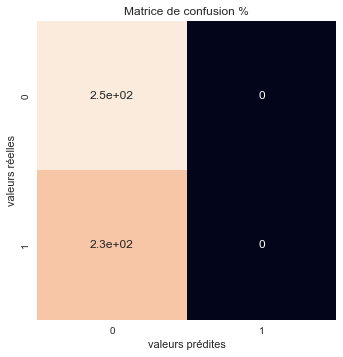

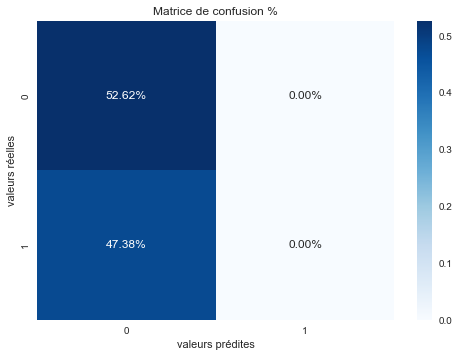


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  fast text
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 [==============================] - 2s 183ms/step - loss: 1.1502 - auc: 0.4917 - val_loss: 0.7652 - val_auc: 0.4888
Epoch 2/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8501 - auc: 0.5005 - val_loss: 0.6929 - val_auc: 0.5268
Epoch 3/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7971 - auc: 0.5190 - val_loss: 0.9586 - val_auc: 0.4593
Epoch 4/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7969 - auc: 0.5296 - val_loss: 0.8389 - val_auc: 0.5184
Epoch 5/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8374 - auc: 0.5128 - val_loss: 0.7531 - val_auc: 0.5404
Epoch 6/15
7/7 [==============================] - 1s 111ms/step - loss: 0.8453 - auc: 0.4854 - val_loss: 0.6994 - val_auc: 0.5387
Epoch 7/15
7/7 [==============================] - 1s 91ms/step - loss: 0.8275 - auc: 0.4647 - val_loss: 0.8247 - val_auc: 0.4853
Epoch 8/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7600 - auc: 0.5141 - val_loss: 0.

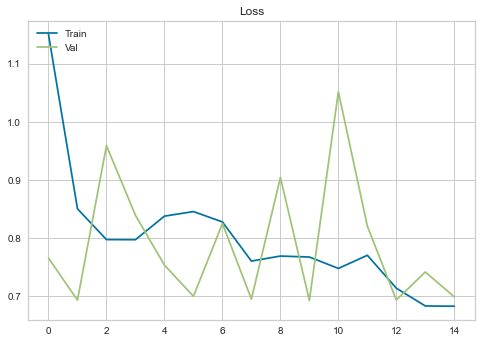

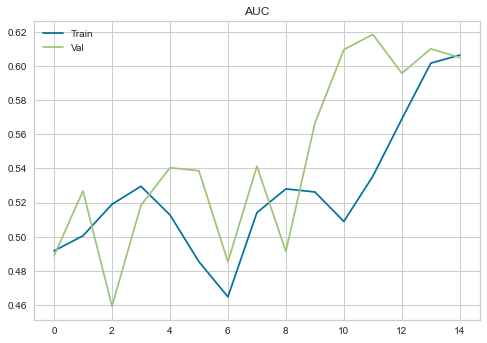

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 190ms/step - loss: 1.0264 - auc: 0.4971 - val_loss: 0.9031 - val_auc: 0.5058
Epoch 2/15
7/7 [==============================] - 1s 96ms/step - loss: 0.8703 - auc: 0.4905 - val_loss: 0.7029 - val_auc: 0.5608
Epoch 3/15
7/7 [==============================] - 1s 97ms/step - loss: 0.8343 - auc: 0.5125 - val_loss: 0.7086 - val_auc: 0.5420
Epoch 4/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7887 - auc: 0.5138 - val_loss: 0.7310 - val_auc: 0.5758
Epoch 5/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8522 - auc: 0.5043 - val_loss: 0.7847 - val_auc: 0.5666
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7819 - auc: 0.5171 - val_loss: 0.8021 - val_auc: 0.5586
Epoch 7/15
7/7 [==============================] - 1s 92m

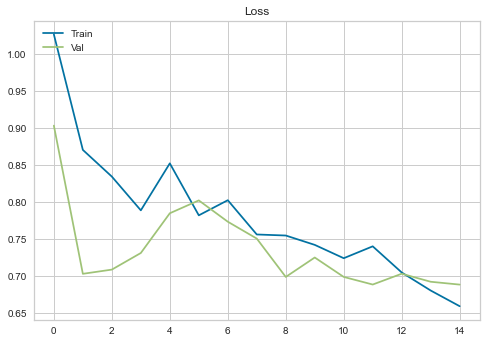

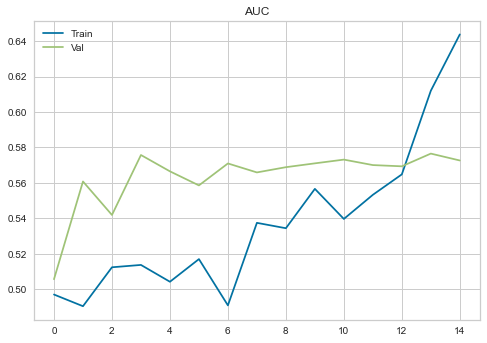

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 234ms/step - loss: 1.0209 - auc: 0.5291 - val_loss: 0.7053 - val_auc: 0.5178
Epoch 2/15
7/7 [==============================] - 1s 99ms/step - loss: 0.9880 - auc: 0.4619 - val_loss: 0.7554 - val_auc: 0.5553
Epoch 3/15
7/7 [==============================] - 1s 95ms/step - loss: 0.8953 - auc: 0.4645 - val_loss: 0.7012 - val_auc: 0.5501
Epoch 4/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7582 - auc: 0.5227 - val_loss: 0.7032 - val_auc: 0.5486
Epoch 5/15
7/7 [==============================] - 1s 94ms/step - loss: 0.8021 - auc: 0.5226 - val_loss: 0.8597 - val_auc: 0.5607
Epoch 6/15
7/7 [==============================] - 1s 94ms/step - loss: 0.8323 - auc: 0.4878 - val_loss: 0.7096 - val_auc: 0.5528
Epoch 7/15
7/7 [==============================] - 1s 96m

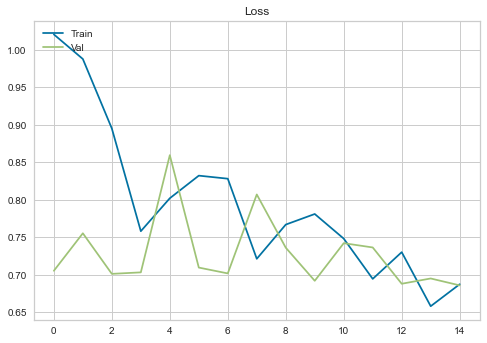

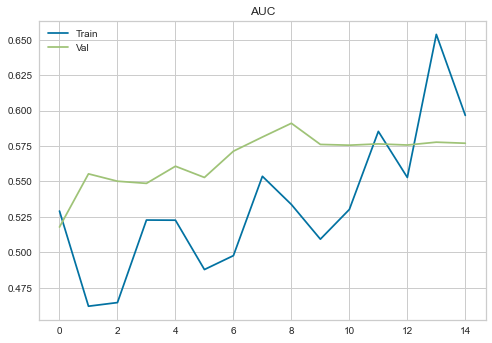

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed fast text
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 47.121323108673096
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


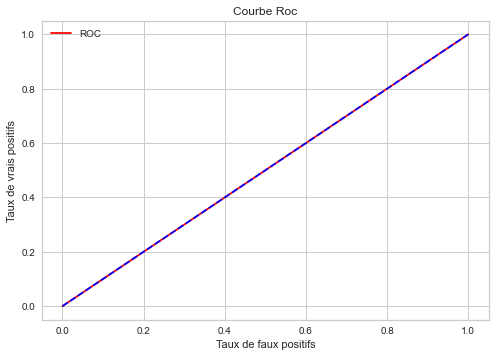

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


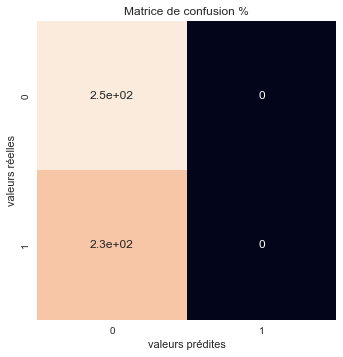

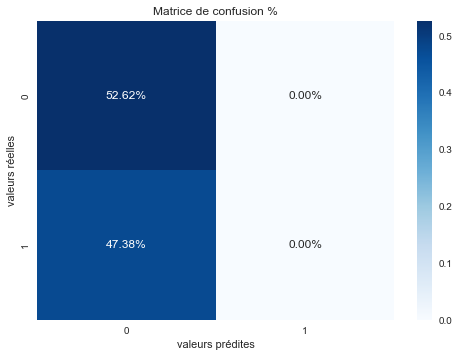


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  glove
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 [==============================] - 2s 157ms/step - loss: 1.1073 - auc: 0.4785 - val_loss: 0.9125 - val_auc: 0.5466
Epoch 2/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7972 - auc: 0.5217 - val_loss: 0.7525 - val_auc: 0.5437
Epoch 3/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8466 - auc: 0.4949 - val_loss: 0.8505 - val_auc: 0.5817
Epoch 4/15
7/7 [==============================] - 1s 150ms/step - loss: 0.8002 - auc: 0.5186 - val_loss: 0.7080 - val_auc: 0.5773
Epoch 5/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8768 - auc: 0.4913 - val_loss: 0.6976 - val_auc: 0.5944
Epoch 6/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7830 - auc: 0.5143 - val_loss: 0.7619 - val_auc: 0.5855
Epoch 7/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7941 - auc: 0.4864 - val_loss: 0.8598 - val_auc: 0.6040
Epoch 8/15
7/7 [==============================] - 1s 110ms/step - loss: 0.8044 - auc: 0.4977 - val_loss: 0

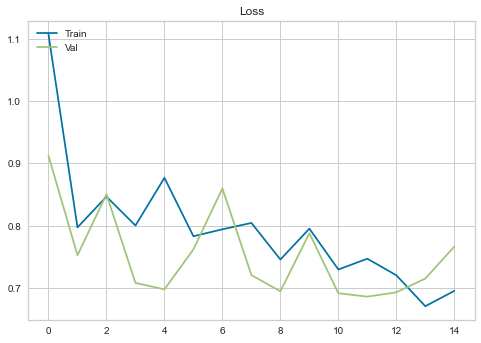

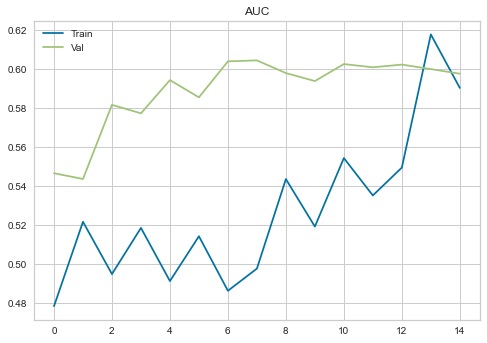

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 152ms/step - loss: 1.0728 - auc: 0.5231 - val_loss: 0.7575 - val_auc: 0.5354
Epoch 2/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7947 - auc: 0.5048 - val_loss: 0.8441 - val_auc: 0.4956
Epoch 3/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7901 - auc: 0.5354 - val_loss: 0.9170 - val_auc: 0.4847
Epoch 4/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8180 - auc: 0.5327 - val_loss: 0.7324 - val_auc: 0.5451
Epoch 5/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7749 - auc: 0.5233 - val_loss: 0.7509 - val_auc: 0.5106
Epoch 6/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8629 - auc: 0.5024 - val_loss: 0.6930 - val_auc: 0.5306
Epoch 7/15
7/7 [==============================] - 1s 91m

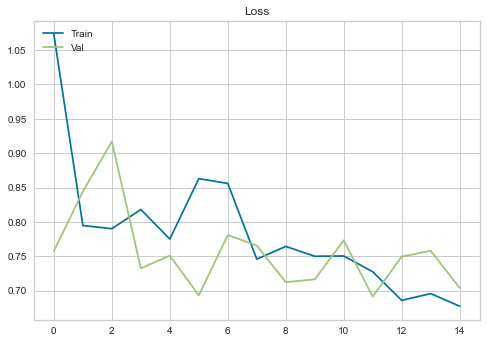

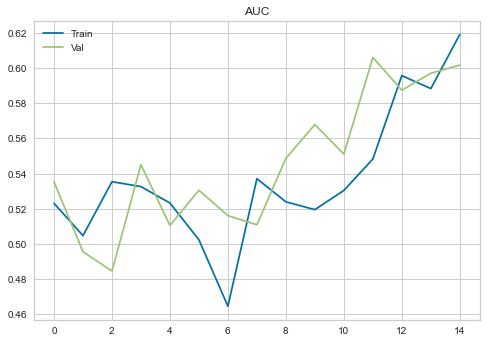

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 189ms/step - loss: 1.0748 - auc: 0.4953 - val_loss: 1.1120 - val_auc: 0.5808
Epoch 2/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8803 - auc: 0.5060 - val_loss: 0.7634 - val_auc: 0.5504
Epoch 3/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8118 - auc: 0.5100 - val_loss: 0.9768 - val_auc: 0.5687
Epoch 4/15
7/7 [==============================] - 1s 93ms/step - loss: 0.9228 - auc: 0.4723 - val_loss: 0.6982 - val_auc: 0.6024
Epoch 5/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7554 - auc: 0.5122 - val_loss: 0.7503 - val_auc: 0.5755
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7837 - auc: 0.5107 - val_loss: 0.8832 - val_auc: 0.5582
Epoch 7/15
7/7 [==============================] - 1s 93m

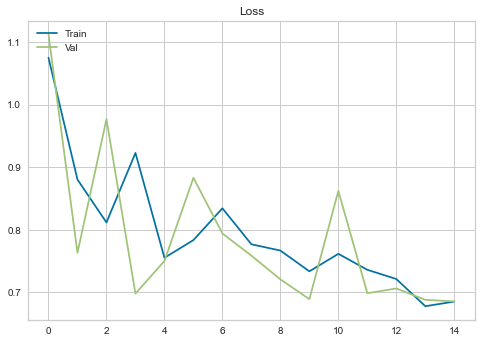

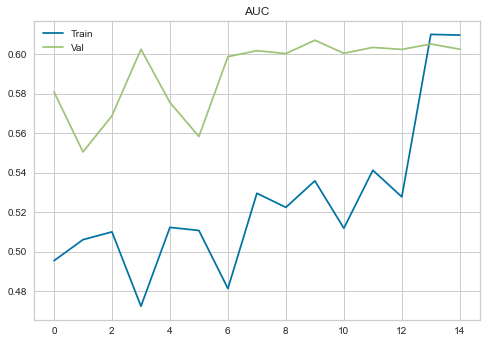

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed glove
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 45.44656944274902
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


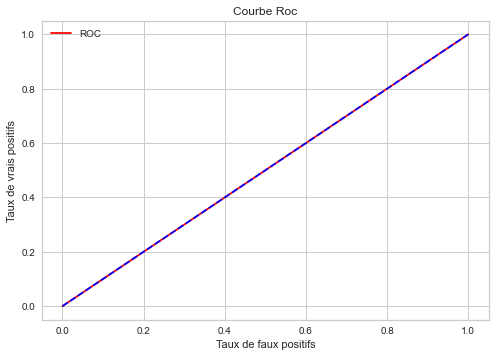

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


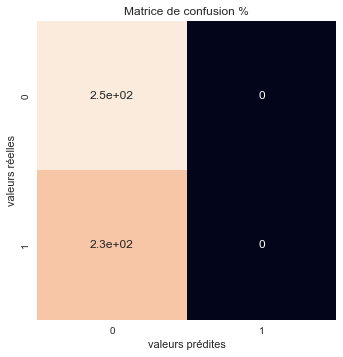

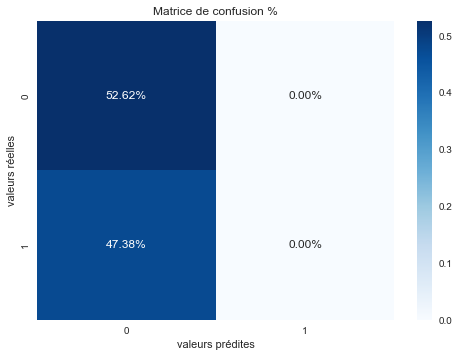


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed at 0x0000027F37157E58>
------------embeddings :  fast text
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 34s 3s/step - loss: 0.6919 - auc: 0.5656 - val_loss: 0.6885 - val_auc: 0.6396
Epoch 2/15
7/7 [==============================] - 13s 2s/step - loss: 0.6861 - auc: 0.6678 - val_loss: 0.6839 - val_auc: 0.6584
Epoch 3/15
7/7 [==============================] - 12s 2s/step - loss: 0.6799 - auc: 0.6923 - val_loss: 0.6781 - val_auc: 0.6715
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.6700 - auc: 0.7235 - val_loss: 0.6699 - val_auc: 0.6966
Epoch 5/15
7/7 [==============================] - 13s 2s/step - loss: 0.6575 - auc: 0.7576 - val_loss: 0.6603 - val_auc: 0.6945
Epoch 6/15
7/7 [==============================] - 13s 2s/step - loss: 0.6424 - auc: 0.7566 - val_loss: 0.6479 - val_auc: 0.7155
Epoch 7/15
7/7 [==============================] - 13s 2s/step - loss: 0.6250 - auc: 0.7815 - val_loss: 0.6431 - val_auc: 0.7083
Epoch 8/15
7/7 [==============================] - 13s 2s/step - loss: 0.6059 - auc: 0.7928 - val_loss: 0

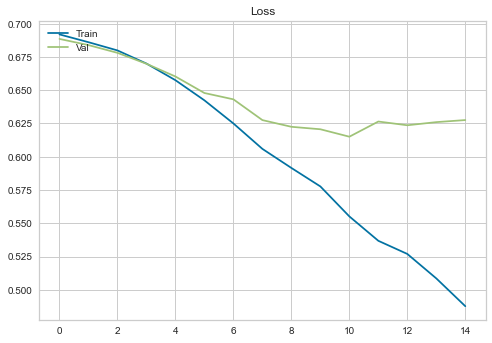

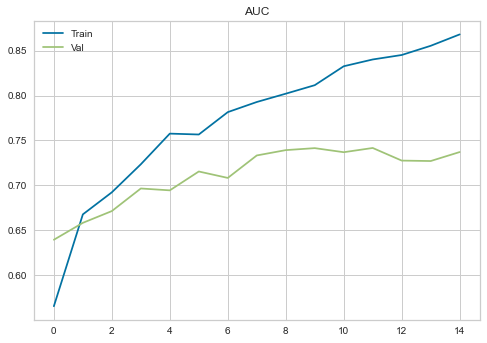

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 37s 3s/step - loss: 0.6901 - auc: 0.5900 - val_loss: 0.6887 - val_auc: 0.6033
Epoch 2/15
7/7 [==============================] - 13s 2s/step - loss: 0.6813 - auc: 0.6584 - val_loss: 0.6845 - val_auc: 0.6198
Epoch 3/15
7/7 [==============================] - 12s 2s/step - loss: 0.6709 - auc: 0.6889 - val_loss: 0.6785 - val_auc: 0.6507
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.6559 - auc: 0.7258 - val_loss: 0.6716 - val_auc: 0.6608
Epoch 5/15
7/7 [==============================] - 13s 2s/step - loss: 0.6415 - auc: 0.7365 - val_loss: 0.6663 - val_auc: 0.6671
Epoch 6/15
7/7 [==============================] - 12s 2s/step - loss: 0.6215 - auc: 0.7483 - val_loss: 0.6601 - val_auc: 0.6867
Epoch 7/15
7/7 [==============================] - 12s 2s/step -

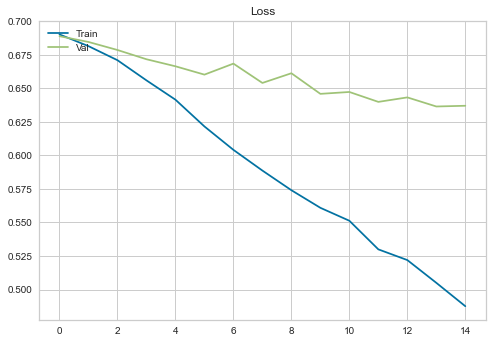

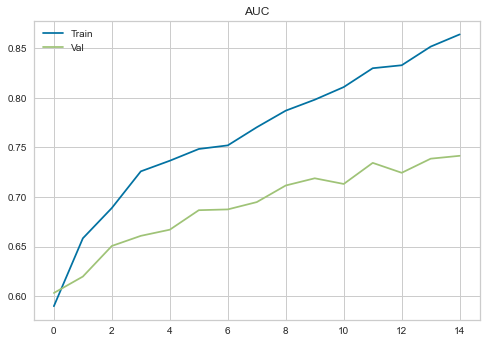

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 27s 2s/step - loss: 0.6920 - auc: 0.5548 - val_loss: 0.6888 - val_auc: 0.6309
Epoch 2/15
7/7 [==============================] - 13s 2s/step - loss: 0.6867 - auc: 0.6437 - val_loss: 0.6846 - val_auc: 0.6418
Epoch 3/15
7/7 [==============================] - 13s 2s/step - loss: 0.6801 - auc: 0.6607 - val_loss: 0.6800 - val_auc: 0.6863
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.6721 - auc: 0.7200 - val_loss: 0.6718 - val_auc: 0.6878
Epoch 5/15
7/7 [==============================] - 13s 2s/step - loss: 0.6598 - auc: 0.7378 - val_loss: 0.6652 - val_auc: 0.6908
Epoch 6/15
7/7 [==============================] - 13s 2s/step - loss: 0.6433 - auc: 0.7565 - val_loss: 0.6539 - val_auc: 0.7014
Epoch 7/15
7/7 [==============================] - 12s 2s/step -

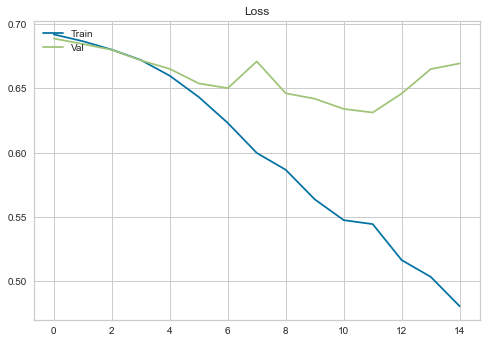

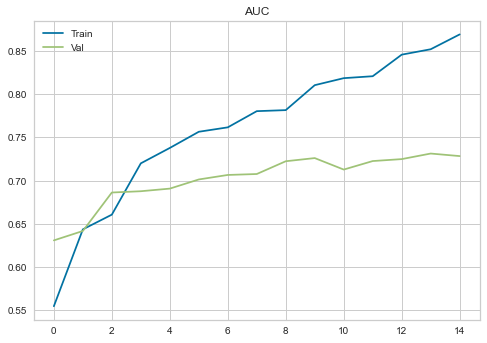

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed at 0x0000027F37157E58>
embed fast text
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 673.1940355300903
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 3s 225ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:3
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


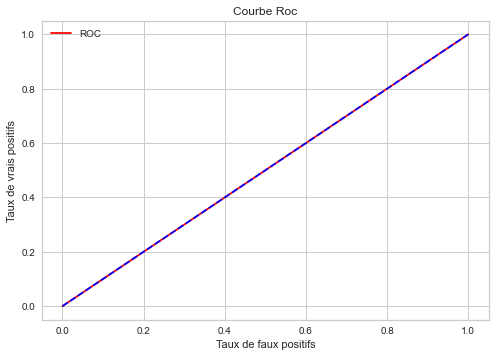

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


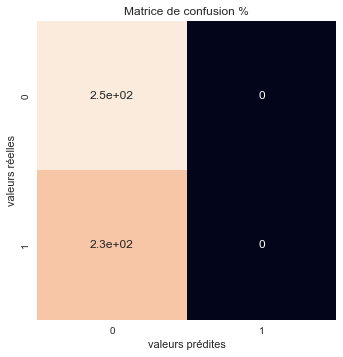

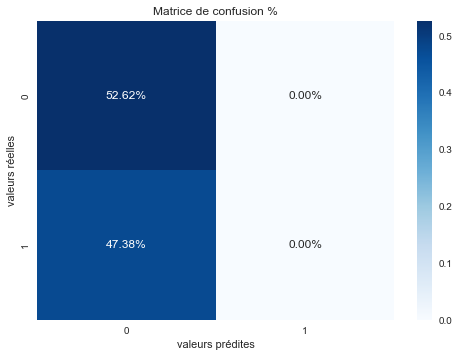


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed at 0x0000027F37157E58>
------------embeddings :  glove
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 27s 3s/step - loss: 0.6897 - auc: 0.5798 - val_loss: 0.6828 - val_auc: 0.6348
Epoch 2/15
7/7 [==============================] - 13s 2s/step - loss: 0.6653 - auc: 0.7487 - val_loss: 0.6712 - val_auc: 0.6632
Epoch 3/15
7/7 [==============================] - 13s 2s/step - loss: 0.6369 - auc: 0.7822 - val_loss: 0.6588 - val_auc: 0.6704
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.5993 - auc: 0.8130 - val_loss: 0.6508 - val_auc: 0.6673
Epoch 5/15
7/7 [==============================] - 12s 2s/step - loss: 0.5630 - auc: 0.8284 - val_loss: 0.6459 - val_auc: 0.6882
Epoch 6/15
7/7 [==============================] - 13s 2s/step - loss: 0.5325 - auc: 0.8457 - val_loss: 0.6496 - val_auc: 0.6806
Epoch 7/15
7/7 [==============================] - 13s 2s/step - loss: 0.4959 - auc: 0.8699 - val_loss: 0.6775 - val_auc: 0.7026
Epoch 8/15
7/7 [==============================] - 13s 2s/step - loss: 0.4663 - auc: 0.8886 - val_loss: 0

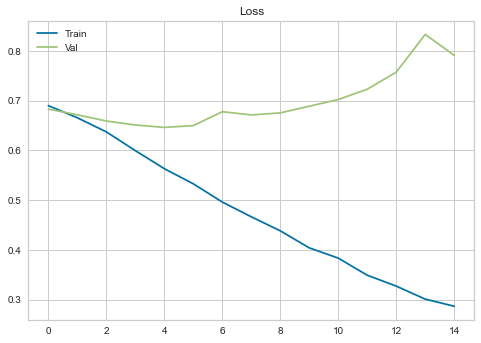

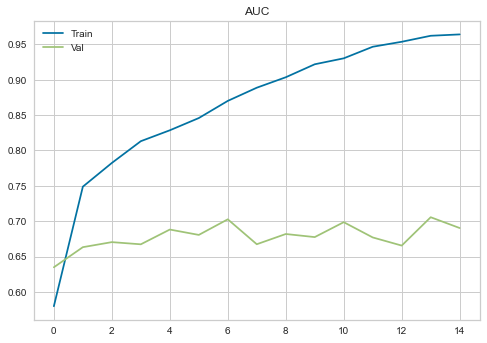

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 34s 3s/step - loss: 0.6909 - auc: 0.5650 - val_loss: 0.6846 - val_auc: 0.6394
Epoch 2/15
7/7 [==============================] - 12s 2s/step - loss: 0.6703 - auc: 0.7089 - val_loss: 0.6724 - val_auc: 0.6930
Epoch 3/15
7/7 [==============================] - 13s 2s/step - loss: 0.6463 - auc: 0.7764 - val_loss: 0.6651 - val_auc: 0.6961
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.6195 - auc: 0.7809 - val_loss: 0.6351 - val_auc: 0.7418
Epoch 5/15
7/7 [==============================] - 13s 2s/step - loss: 0.5844 - auc: 0.8180 - val_loss: 0.6163 - val_auc: 0.7512
Epoch 6/15
7/7 [==============================] - 13s 2s/step - loss: 0.5516 - auc: 0.8328 - val_loss: 0.6006 - val_auc: 0.7646
Epoch 7/15
7/7 [==============================] - 13s 2s/step -

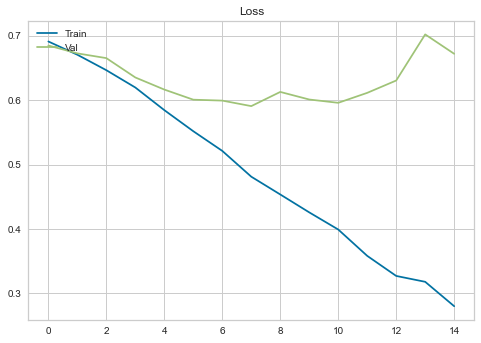

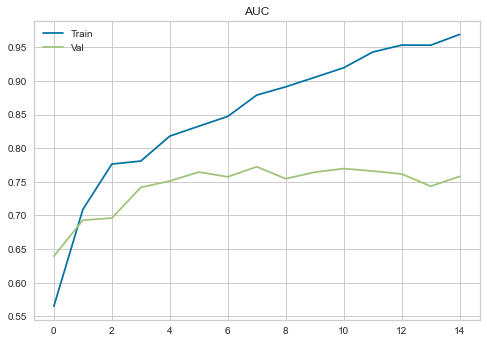

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 28s 2s/step - loss: 0.6908 - auc: 0.5644 - val_loss: 0.6854 - val_auc: 0.6300
Epoch 2/15
7/7 [==============================] - 13s 2s/step - loss: 0.6684 - auc: 0.7819 - val_loss: 0.6735 - val_auc: 0.6722
Epoch 3/15
7/7 [==============================] - 13s 2s/step - loss: 0.6404 - auc: 0.7981 - val_loss: 0.6552 - val_auc: 0.7020
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.5978 - auc: 0.8287 - val_loss: 0.6388 - val_auc: 0.7096
Epoch 5/15
7/7 [==============================] - 13s 2s/step - loss: 0.5550 - auc: 0.8464 - val_loss: 0.6475 - val_auc: 0.7118
Epoch 6/15
7/7 [==============================] - 13s 2s/step - loss: 0.5190 - auc: 0.8574 - val_loss: 0.6533 - val_auc: 0.7097
Epoch 7/15
7/7 [==============================] - 13s 2s/step -

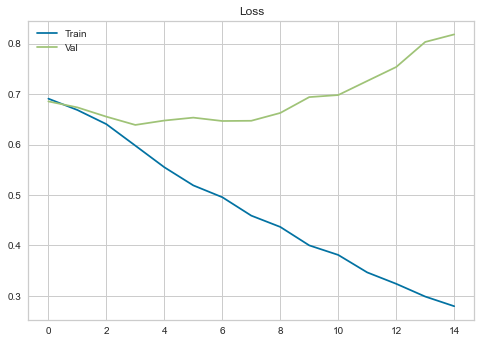

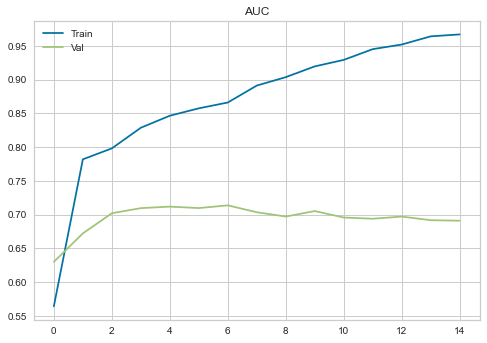

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed at 0x0000027F37157E58>
embed glove
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 666.6212215423584
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 3s 211ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:3
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


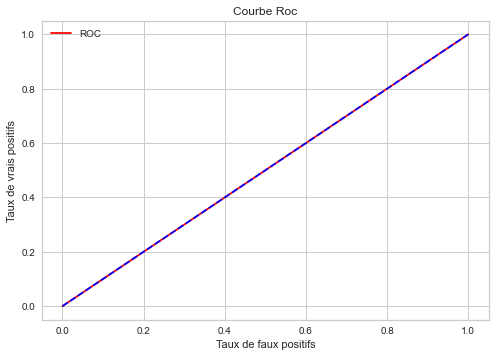

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


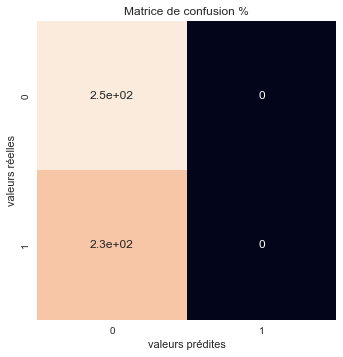

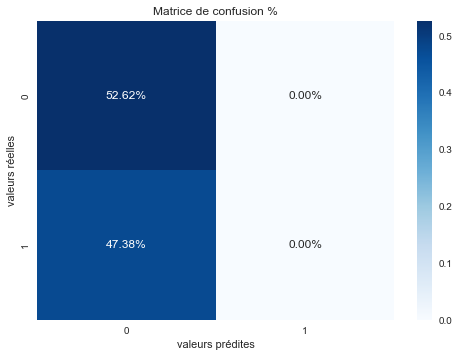


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
------------embeddings :  fast text
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 63s 7s/step - loss: 0.6953 - auc: 0.5330 - val_loss: 0.6914 - val_auc: 0.6217
Epoch 2/15
7/7 [==============================] - 38s 6s/step - loss: 0.6583 - auc: 0.6518 - val_loss: 0.6117 - val_auc: 0.7383
Epoch 3/15
7/7 [==============================] - 40s 6s/step - loss: 0.5820 - auc: 0.7671 - val_loss: 0.6318 - val_auc: 0.7568
Epoch 4/15
7/7 [==============================] - 38s 6s/step - loss: 0.5131 - auc: 0.8355 - val_loss: 0.6310 - val_auc: 0.7625
Epoch 5/15
7/7 [==============================] - 41s 6s/step - loss: 0.4447 - auc: 0.8872 - val_loss: 0.6694 - val_auc: 0.7464
Epoch 6/15
7/7 [==============================] - 40s 6s/step - loss: 0.4172 - auc: 0.8937 - val_loss: 0.7001 - val_auc: 0.7413
Epoch 7/15
7/7 [==============================] - 37s 6s/step - loss: 0.3568 - auc: 0.9215 - val_loss: 0.7057 - val_auc: 0.7490
Epoch 8/15
7/7 [==============================] - 37s 5s/step - loss: 0.3145 - auc: 0.9412 - val_loss: 0

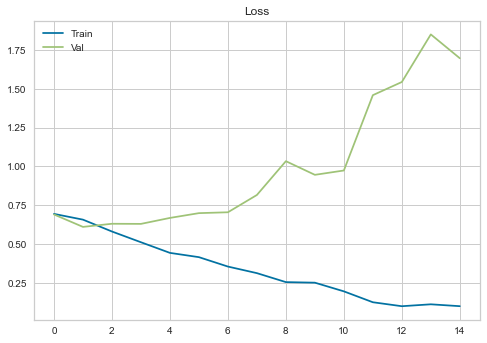

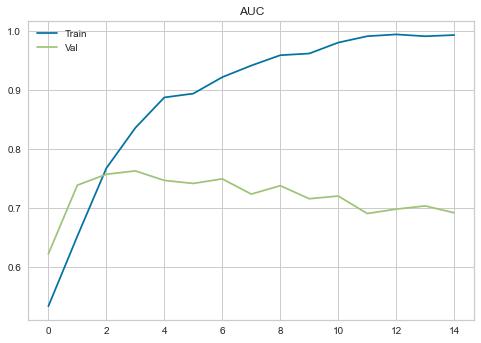

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 178s 7s/step - loss: 0.6969 - auc: 0.5279 - val_loss: 0.6808 - val_auc: 0.6352
Epoch 2/15
7/7 [==============================] - 37s 5s/step - loss: 0.6434 - auc: 0.6964 - val_loss: 0.6796 - val_auc: 0.6661
Epoch 3/15
7/7 [==============================] - 40s 6s/step - loss: 0.5749 - auc: 0.7669 - val_loss: 0.6163 - val_auc: 0.7347
Epoch 4/15
7/7 [==============================] - 41s 6s/step - loss: 0.4987 - auc: 0.8402 - val_loss: 0.5710 - val_auc: 0.7827
Epoch 5/15
7/7 [==============================] - 41s 6s/step - loss: 0.4266 - auc: 0.8869 - val_loss: 0.6100 - val_auc: 0.7823
Epoch 6/15
7/7 [==============================] - 40s 6s/step - loss: 0.3963 - auc: 0.9027 - val_loss: 0.6498 - val_auc: 0.7636
Epoch 7/15
7/7 [==============================] - 38s 6s/step 

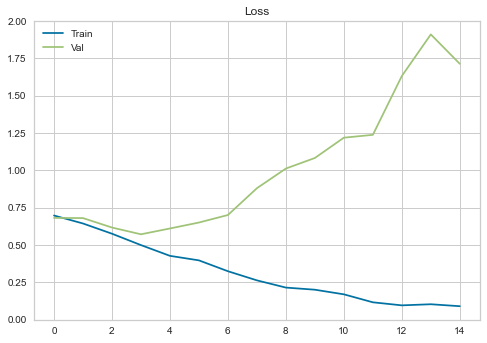

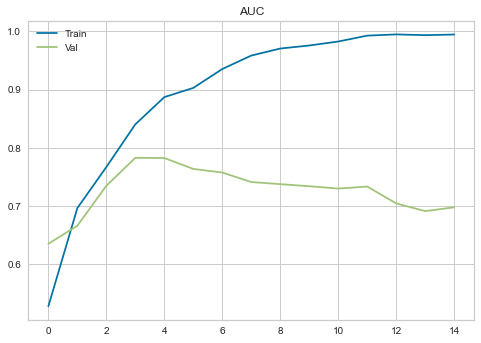

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 62s 8s/step - loss: 0.7180 - auc: 0.5514 - val_loss: 0.6697 - val_auc: 0.6826
Epoch 2/15
7/7 [==============================] - 40s 6s/step - loss: 0.6459 - auc: 0.6919 - val_loss: 0.6103 - val_auc: 0.7302
Epoch 3/15
7/7 [==============================] - 41s 6s/step - loss: 0.5554 - auc: 0.8035 - val_loss: 0.6708 - val_auc: 0.7253
Epoch 4/15
7/7 [==============================] - 40s 6s/step - loss: 0.5096 - auc: 0.8329 - val_loss: 0.5968 - val_auc: 0.7637
Epoch 5/15
7/7 [==============================] - 40s 6s/step - loss: 0.4357 - auc: 0.8791 - val_loss: 0.6541 - val_auc: 0.7676
Epoch 6/15
7/7 [==============================] - 39s 6s/step - loss: 0.3984 - auc: 0.8971 - val_loss: 0.6265 - val_auc: 0.7611
Epoch 7/15
7/7 [==============================] - 38s 6s/step -

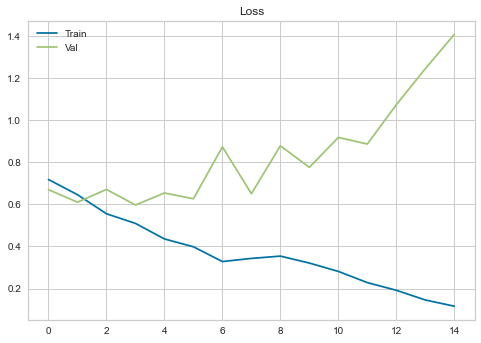

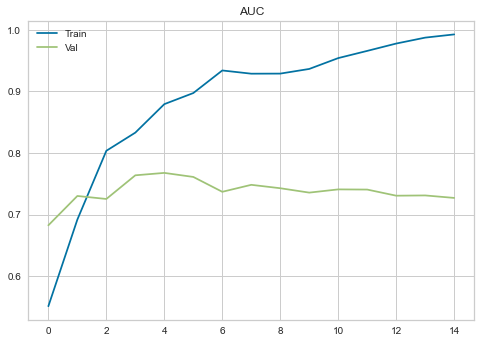

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
embed fast text
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 2011.6850678920746
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 18s 1s/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:4
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


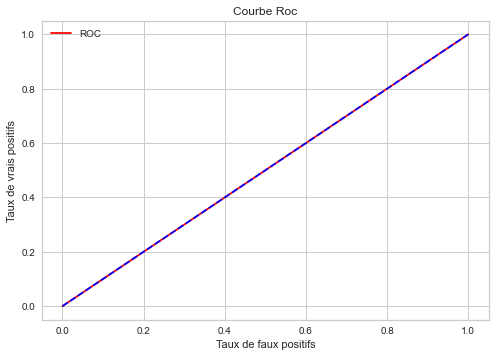

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


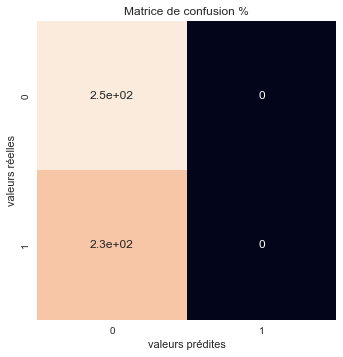

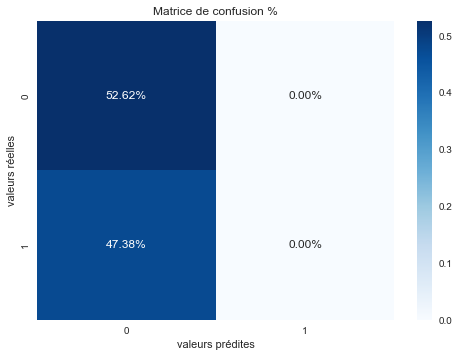


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
------------embeddings :  glove
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 63s 8s/step - loss: 0.7082 - auc: 0.5401 - val_loss: 0.6363 - val_auc: 0.7089
Epoch 2/15
7/7 [==============================] - 40s 6s/step - loss: 0.5429 - auc: 0.8046 - val_loss: 0.6174 - val_auc: 0.7355
Epoch 3/15
7/7 [==============================] - 40s 6s/step - loss: 0.4067 - auc: 0.8969 - val_loss: 0.7633 - val_auc: 0.7311
Epoch 4/15
7/7 [==============================] - 39s 6s/step - loss: 0.2800 - auc: 0.9518 - val_loss: 0.8450 - val_auc: 0.7167
Epoch 5/15
7/7 [==============================] - 37s 5s/step - loss: 0.1455 - auc: 0.9879 - val_loss: 1.3800 - val_auc: 0.7228
Epoch 6/15
7/7 [==============================] - 37s 5s/step - loss: 0.0881 - auc: 0.9942 - val_loss: 1.7765 - val_auc: 0.6991
Epoch 7/15
7/7 [==============================] - 38s 5s/step - loss: 0.1348 - auc: 0.9871 - val_loss: 1.3930 - val_auc: 0.6835
Epoch 8/15
7/7 [==============================] - 37s 5s/step - loss: 0.0854 - auc: 0.9962 - val_loss: 1

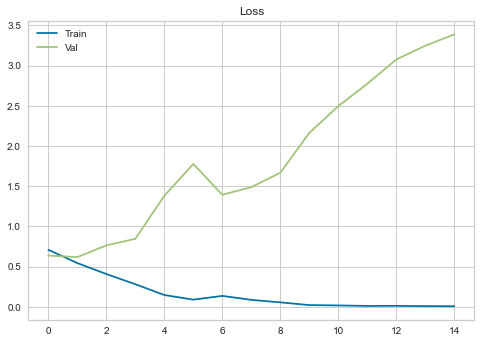

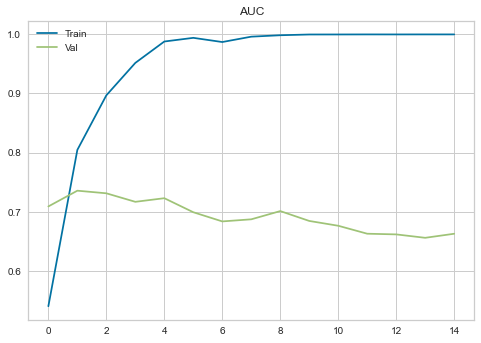

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 61s 7s/step - loss: 0.7267 - auc: 0.5236 - val_loss: 0.6879 - val_auc: 0.5664
Epoch 2/15
7/7 [==============================] - 42s 6s/step - loss: 0.6505 - auc: 0.6738 - val_loss: 0.6425 - val_auc: 0.7088
Epoch 3/15
7/7 [==============================] - 41s 6s/step - loss: 0.5287 - auc: 0.8144 - val_loss: 0.5612 - val_auc: 0.7907
Epoch 4/15
7/7 [==============================] - 41s 6s/step - loss: 0.4284 - auc: 0.8873 - val_loss: 0.6861 - val_auc: 0.7542
Epoch 5/15
7/7 [==============================] - 40s 6s/step - loss: 0.2779 - auc: 0.9524 - val_loss: 0.7660 - val_auc: 0.7599
Epoch 6/15
7/7 [==============================] - 39s 6s/step - loss: 0.1780 - auc: 0.9790 - val_loss: 1.0402 - val_auc: 0.7549
Epoch 7/15
7/7 [==============================] - 39s 6s/step -

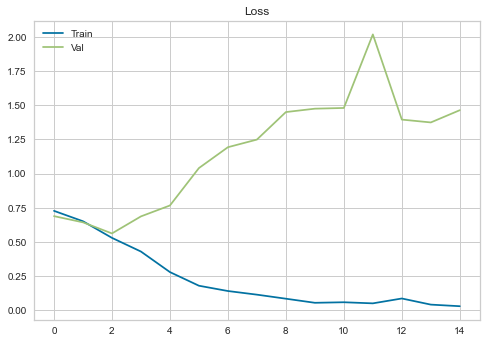

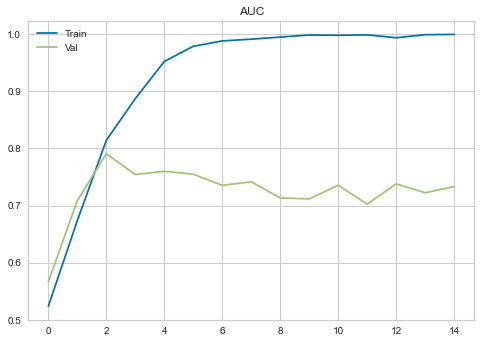

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 57s 7s/step - loss: 0.6797 - auc: 0.5975 - val_loss: 0.6415 - val_auc: 0.7026
Epoch 2/15
7/7 [==============================] - 40s 6s/step - loss: 0.5993 - auc: 0.7505 - val_loss: 0.7054 - val_auc: 0.6957
Epoch 3/15
7/7 [==============================] - 43s 6s/step - loss: 0.4858 - auc: 0.8473 - val_loss: 0.6687 - val_auc: 0.7219
Epoch 4/15
7/7 [==============================] - 42s 6s/step - loss: 0.3998 - auc: 0.8961 - val_loss: 0.6979 - val_auc: 0.7265
Epoch 5/15
7/7 [==============================] - 41s 6s/step - loss: 0.3021 - auc: 0.9548 - val_loss: 0.7476 - val_auc: 0.6973
Epoch 6/15
7/7 [==============================] - 40s 6s/step - loss: 0.2146 - auc: 0.9733 - val_loss: 1.2258 - val_auc: 0.7006
Epoch 7/15
7/7 [==============================] - 39s 6s/step -

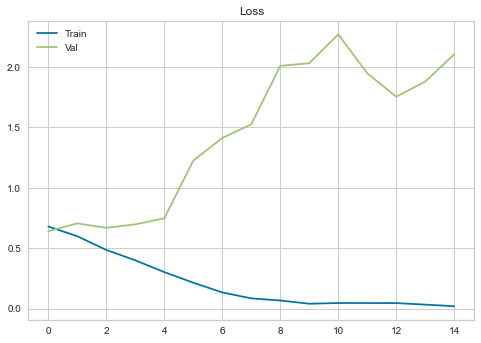

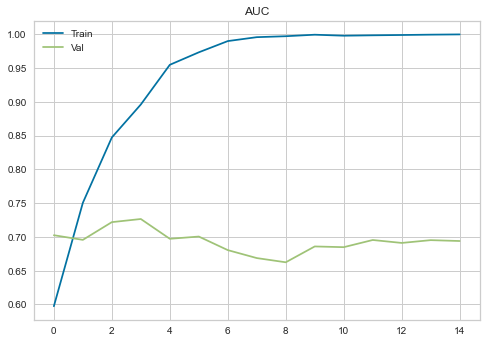

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
embed glove
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 1940.6350464820862
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 19s 1s/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:4
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


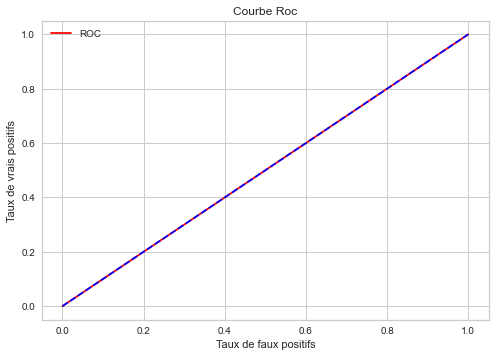

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


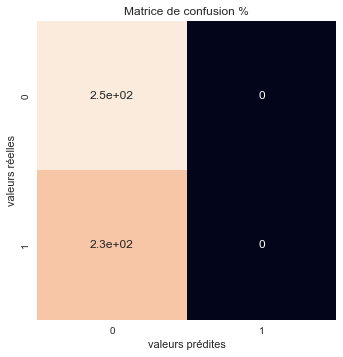

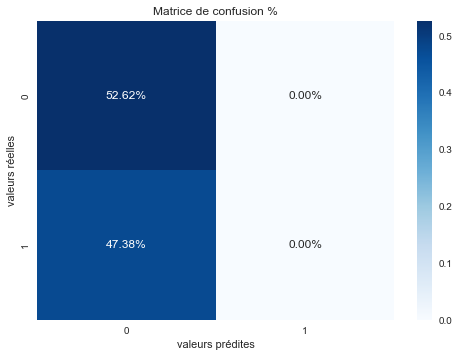


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [301]:
metric_history = []
test_history_n = []
search_best_model(df, embeddings)

In [311]:
df_metrics_history=pd.DataFrame(metric_history).reset_index()
train_graph=df_metrics_history.copy()

In [312]:
train_graph

index  method                                              model  \
0       0       1  <keras.engine.sequential.Sequential object at ...   
1       1       1  <keras.engine.sequential.Sequential object at ...   
2       2       1  <keras.engine.sequential.Sequential object at ...   
3       3       1  <keras.engine.sequential.Sequential object at ...   
4       4       1  <keras.engine.sequential.Sequential object at ...   
5       5       1  <keras.engine.sequential.Sequential object at ...   
6       6       2  <keras.engine.sequential.Sequential object at ...   
7       7       2  <keras.engine.sequential.Sequential object at ...   
8       8       2  <keras.engine.sequential.Sequential object at ...   
9       9       2  <keras.engine.sequential.Sequential object at ...   
10     10       2  <keras.engine.sequential.Sequential object at ...   
11     11       2  <keras.engine.sequential.Sequential object at ...   
12     12       3  <keras.engine.sequential.Sequential object at ...   
13     13       3  <keras.engine.sequential.Sequential object at ...   
14     14       4  <keras.engine.sequential.Sequential object at ...   
15     15       4  <keras.engine.sequential.Sequential object at ...   

                                             function  auc    metier  \
0   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
1   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
2   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
3   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
4   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
5   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
6   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
7   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
8   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
9   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
10  <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
11  <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
12  <function funct_model_bilstm_embed at 0x000002...  0.5  0.461332   
13  <function funct_model_bilstm_embed at 0x000002...  0.5  0.461332   
14  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.461332   
15  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.461332   

           time name_embed                                          embbeding  \
0    652.670475  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     77.974329      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     51.262564  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     45.833641      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     47.064224  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5     40.194220      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6     46.346560  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
7     44.800983      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8     47.711636  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9     46.655252      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
10    47.121323  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
11    45.446569      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
12   673.194036  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
13   666.621222      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
14  2011.685068  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
15  1940.635046      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

    parameters  
0          0.2  
1          0.2  
2          0.4  
3          0.4  
4          0.6  
5          0.6  
6          0.2  
7          0.2  
8          0.4  
9     

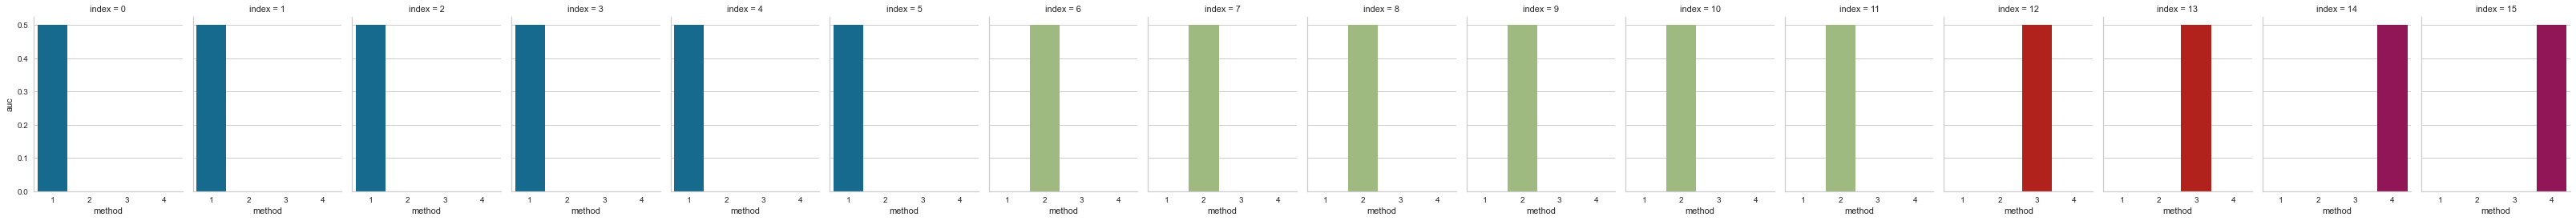

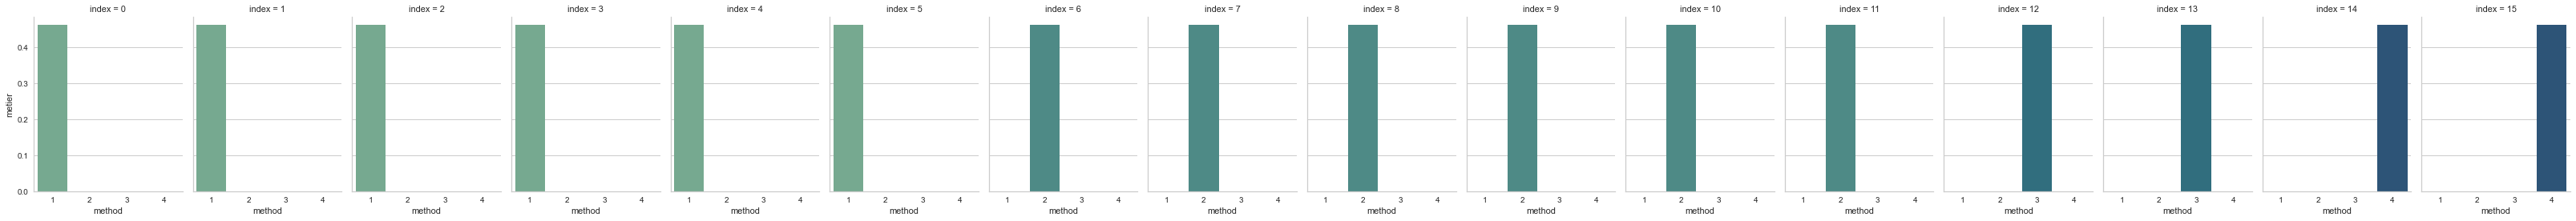

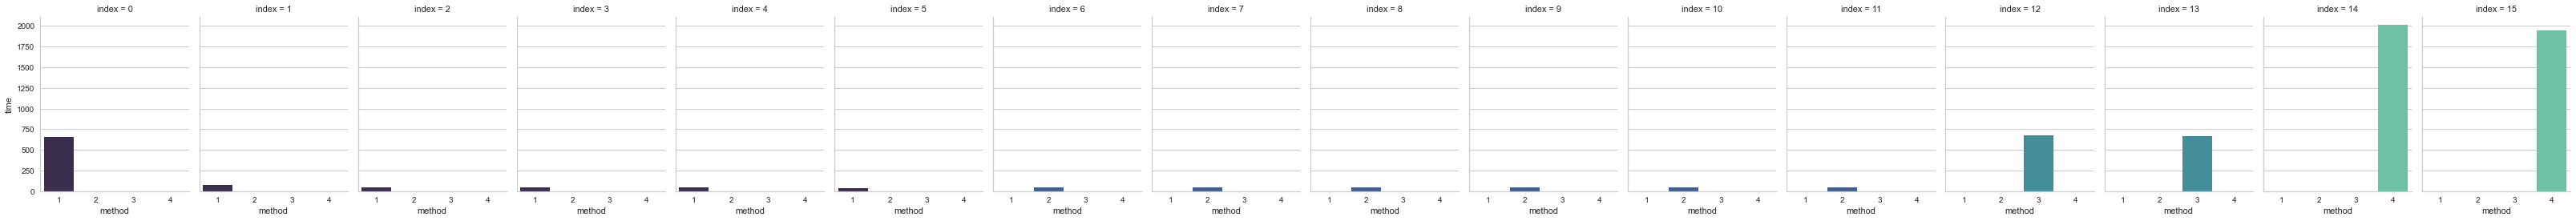

In [313]:
sns.catplot(x="method", y="auc", col="index",
                data=train_graph, kind="bar",
                height=4, aspect=.7)
sns.catplot(x="method", y="metier",
                col="index",orient="v",
                data=train_graph, kind="bar",palette="crest",
                height=4, aspect=.7)
sns.catplot(x="method", y="time",
                col="index",
                data=train_graph, kind="bar",palette='mako',
                height=4, aspect=.7)

In [254]:
df_metrics_history.head(2)

index  method                                              model  \
0      0       1  <keras.engine.sequential.Sequential object at ...   
1      1       1  <keras.engine.sequential.Sequential object at ...   

                                            function  auc    metier  \
0  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
1  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   

         time name_embed                                          embbeding  \
0  191.995958  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   39.172347      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

   parameters  
0         0.2  
1         0.2

In [314]:
df_metrics_history["funct_model"] = df_metrics_history["function"] 

In [315]:
df_metrics_history.head(2)

index  method                                              model  \
0      0       1  <keras.engine.sequential.Sequential object at ...   
1      1       1  <keras.engine.sequential.Sequential object at ...   

                                            function  auc    metier  \
0  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
1  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   

         time name_embed                                          embbeding  \
0  652.670475  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   77.974329      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

   parameters                                        funct_model  
0         0.2  <function funct_model_simple at 0x0000027E11A1...  
1         0.2  <function funct_model_simple at 0x0000027E11A1...

In [316]:
df_metrics_history_test=pd.DataFrame(test_history_n).reset_index()
test_graph=df_metrics_history_test.copy()

In [317]:
df_metrics_history_test

index  method                                              model  \
0       0       1  <keras.engine.sequential.Sequential object at ...   
1       1       1  <keras.engine.sequential.Sequential object at ...   
2       2       1  <keras.engine.sequential.Sequential object at ...   
3       3       1  <keras.engine.sequential.Sequential object at ...   
4       4       1  <keras.engine.sequential.Sequential object at ...   
5       5       1  <keras.engine.sequential.Sequential object at ...   
6       6       2  <keras.engine.sequential.Sequential object at ...   
7       7       2  <keras.engine.sequential.Sequential object at ...   
8       8       2  <keras.engine.sequential.Sequential object at ...   
9       9       2  <keras.engine.sequential.Sequential object at ...   
10     10       2  <keras.engine.sequential.Sequential object at ...   
11     11       2  <keras.engine.sequential.Sequential object at ...   
12     12       3  <keras.engine.sequential.Sequential object at ...   
13     13       3  <keras.engine.sequential.Sequential object at ...   
14     14       4  <keras.engine.sequential.Sequential object at ...   
15     15       4  <keras.engine.sequential.Sequential object at ...   

                                             function  auc    metier  \
0   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
1   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
2   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
3   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
4   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
5   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
6   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
7   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
8   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
9   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
10  <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
11  <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
12  <function funct_model_bilstm_embed at 0x000002...  0.5  0.426415   
13  <function funct_model_bilstm_embed at 0x000002...  0.5  0.426415   
14  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.426415   
15  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.426415   

         time name_embedd                                          embbeding  \
0    2.819933   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1    3.043355       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2    2.462661   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3    2.330225       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4    2.291489   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5    2.449234       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6    2.498416   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
7    2.509677       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8    2.520741   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9    2.413676       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
10   2.478670   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
11   3.071624       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
12   6.170620   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
13   5.978115       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
14  21.058509   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
15  21.491819       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

    parameters  
0          0.2  
1          0.2  
2          0.4  
3          0.4  
4          0.6  
5          0.6  
6          0.2  
7          0.2  
8          0.4  
9          0.4  
10    

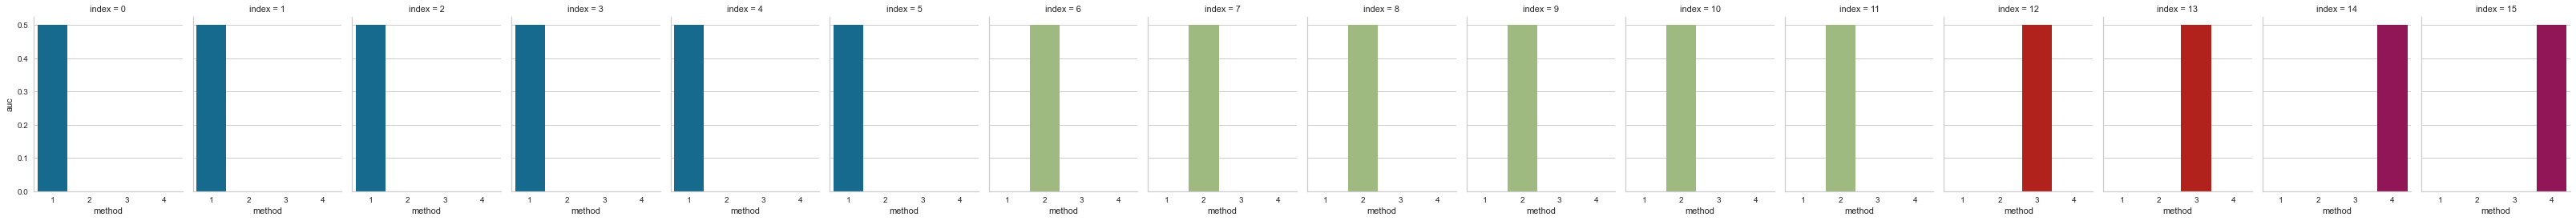

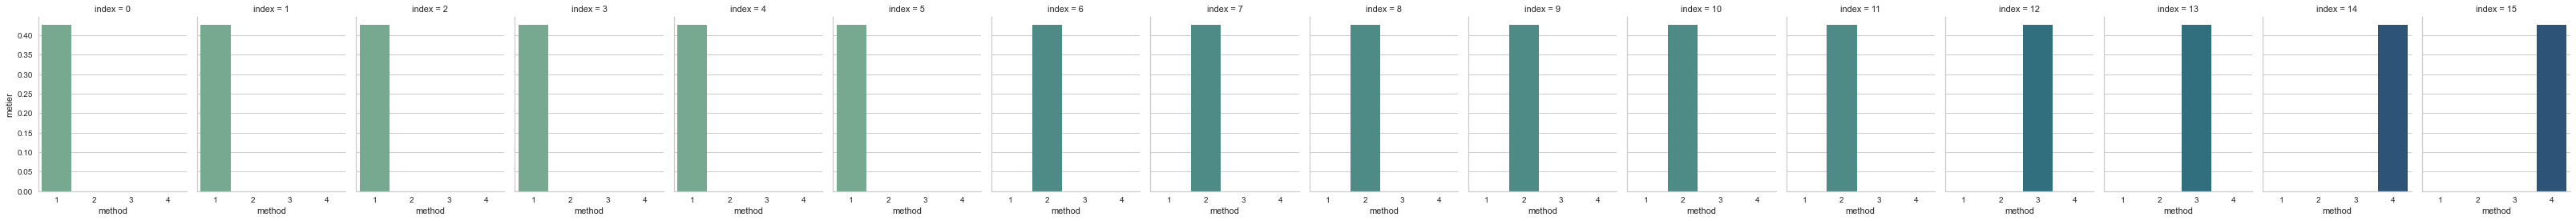

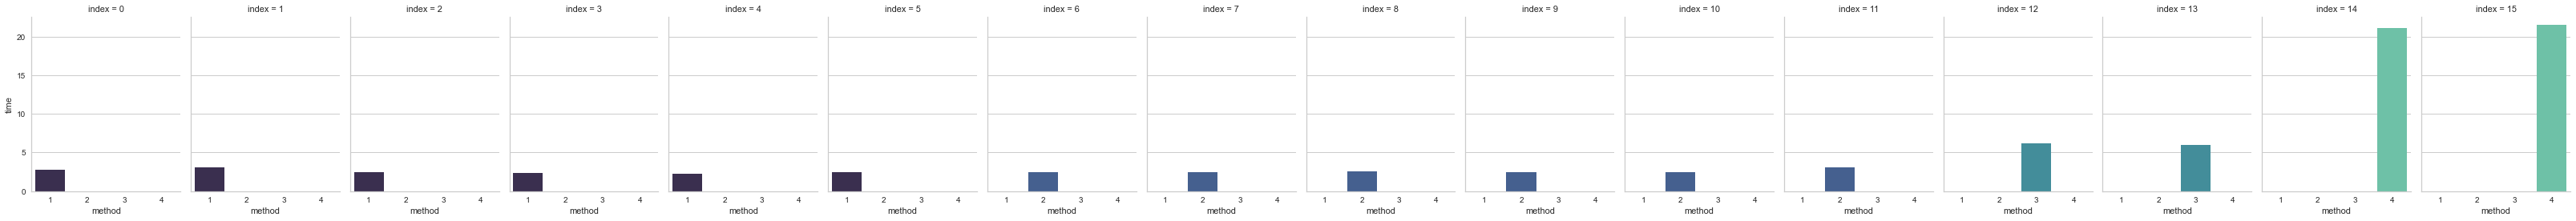

In [318]:
sns.catplot(x="method", y="auc",
                col="index",
                data=test_graph, kind="bar",
                height=4, aspect=.7)
sns.catplot(x="method", y="metier",
                col="index",
                data=test_graph, kind="bar",palette="crest",
                height=4, aspect=.7)
sns.catplot(x="method", y="time",
                col="index",
                data=test_graph, kind="bar",palette="mako",
                height=4, aspect=.7)


Nous allons réaliser un pipeline différent pour Bert afin que ce soit plus clair.

## Bert

In [292]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [293]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

Nous allons utiliser un modèle pré-entrainé Bert qui a été entrainé sur une grande quantité de données. C'est donc plus intéressant ici d'utiliser ce type de modèle car nous recherchons les sentiments des tweets. 

Nous décidons d'utiliser le modèle bert de base, qui est composé de 12 couches, 768 cachés, 12 têtes, 110 millions de paramètres.<br>
Plus d'information, ici : https://github.com/google-research/bert

In [320]:
num_classes=len(df.target.unique())

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)



loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\aurel/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005b

Le tokenizer permet de mettre en minuscule les mots et les tokenizés. Un mot hors vocabulaire est découpé en deux avec des "##".<br>
Regardons un exemple :

In [19]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


calculates a été découpé en deux mots :  'calculate', '##s' car il n'existe pas dans le vocabulaire.

Faisons la même chose pour nos données

In [321]:
sentences=df['tweet_lemma_join']
labels=df['target']
len(sentences),len(labels)

(1589, 1589)

Le but est donc de tokenizer nos données pour remplir les paramètres du modèle.<br>
Nous en avons 3 : 
- input_ids : les identifiants d'entrée obtenus à partir du tokenizer
- attention_mask : Masquer les valeurs sélectionnées dans [0, 1]: 1 pour les jetons non masqués , 0 pour les jetons marqués (0 si le jeton est ajouté par remplissage), obtenus aussi avec le tokenizer.
- labels : la variable cible pour calculer la perte de classification ou de régression.  Si num_classes == 1, une perte de régression est calculée (perte moyenne-carrée), si num_classes > 1, une perte de classification est calculée (entropie croisée)

In [322]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)
len(input_ids),len(attention_masks),len(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(1589, 1589, 1589)

Sauvegarde des parametres dans des fichiers pickle pour ne pas refaire cette étape

In [323]:
import pickle
print('Preparing the pickle file.....')

pickle_inp_path='./output/bert_inp.pkl'
pickle_mask_path='./output/bert_mask.pkl'
pickle_label_path='./output/bert_label.pkl'


pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))
 

Preparing the pickle file.....
Pickle files saved as  ./output/bert_inp.pkl ./output/bert_mask.pkl ./output/bert_label.pkl
Loading the saved pickle files..
Input shape (1589, 64) Attention mask shape (1589, 64) Input label shape (1589,)


Division en train, test

In [324]:

train_inp,val_inp,train_label,val_label,train_mask,val_mask=pk_multi.train_test_split(input_ids,labels,attention_masks,test_size=0.3)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

 


Train inp shape (1112, 64) Val input shape (477, 64)
Train label shape (1112,) Val label shape (477,)
Train attention mask shape (1112, 64) Val attention mask shape (477, 64)


Nous configurons ici les différents paramètres : perte, métrique et ceux de l'optimiseur

In [325]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./output/models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('auc')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_906 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [326]:
epochs= [4, 7, 9]
batch_size = [20, 32, 40]

history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)
graph_history_train(history)

Epoch 1/4
35/35 [==============================] - 1781s 36s/step - loss: 0.6917 - auc: 0.5306 - val_loss: 0.6520 - val_auc: 0.6625
Epoch 2/4
35/35 [==============================] - 979s 28s/step - loss: 0.5596 - auc: 0.7302 - val_loss: 0.5154 - val_auc: 0.7526
Epoch 3/4
35/35 [==============================] - 993s 29s/step - loss: 0.4058 - auc: 0.8309 - val_loss: 0.6486 - val_auc: 0.7275
Epoch 4/4
35/35 [==============================] - 998s 29s/step - loss: 0.2322 - auc: 0.9101 - val_loss: 0.5984 - val_auc: 0.7568


In [335]:
val_inp.shape

(477, 64)

In [327]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report

model_save_path='./output/models/bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cac

15/15 [==============================] - 373s 9s/step


In [328]:
pred_labels = np.argmax(preds.logits, axis=1)
#pred_labels = preds.arg_max(axis=1)

0.75237358464027


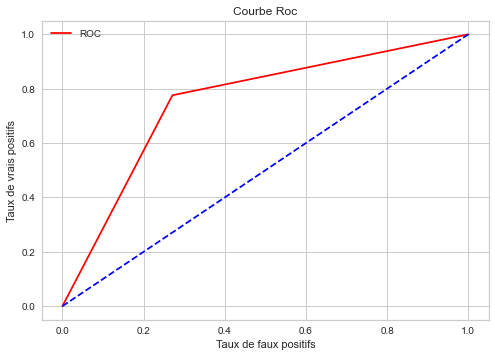

In [334]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(val_label, pred_labels)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
#print("false positive rate : ", false_positive_rate)
#print("true positive rate : ", true_positive_rate)
x_rate = false_positive_rate
y_rate = true_positive_rate 

# This is the ROC curve
plot_roc_curve(x_rate,y_rate)

In [329]:

f1 = metrics.f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')   

F1 score 0.7601626016260161
Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74       236
         1.0       0.75      0.78      0.76       241

    accuracy                           0.75       477
   macro avg       0.75      0.75      0.75       477
weighted avg       0.75      0.75      0.75       477

Training and saving built model.....


In [330]:
metrics.confusion_matrix(val_label,pred_labels)

array([[172,  64],
       [ 54, 187]], dtype=int64)

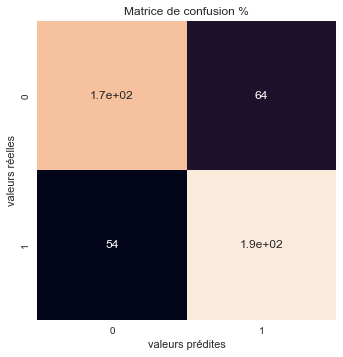

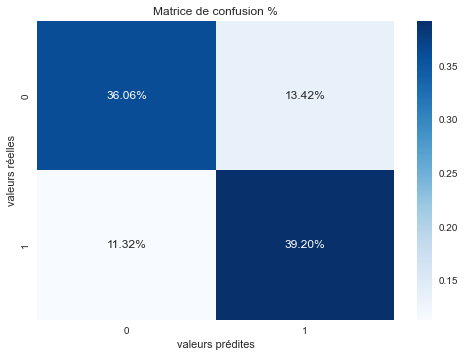

In [331]:
#Matrice de confusion
conf = metrics.confusion_matrix(val_label,pred_labels)
conf
sns.heatmap(conf, square=True, annot=True, cbar=False)
        #, xticklabels=list(iris.target_names)
        #, yticklabels=list(iris.target_names))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion %')
plt.show()

sns.heatmap(conf/np.sum(conf), annot=True, 
        fmt='.2%', cmap='Blues')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion %')
plt.show()

Nous obtenons de bien meilleurs résultats avec le modèle de Bert

In [337]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model

save_model(trained_model, "output/models/model_bert_final.h5")

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

## Service cognitif Azure : Analyse de sentiment

In [ ]:
from azure.identity import ClientSecretCredential
from azure.keyvault.secrets import SecretClient

def get_authentication(tenant_id, client_id, client_secret, endpoint_kv, secret_name_cg):
    try:

        credential = ClientSecretCredential(
            tenant_id=tenant_id,
            client_id=client_id,
            client_secret=client_secret
        )
        # authentication to keyvault
        secret_client = SecretClient(vault_url=endpoint_kv, credential=credential)
        # retrieve secret in keyvault
        secret = secret_client.get_secret(secret_name_cg)

        ## connect to service text analyze
        key_credential = AzureKeyCredential(secret.value)
        return key_credential
    except Exception as e:
        print("error authentication ",e)

In [ ]:
SECRET_NAME_CG = os.getenv('SECRET_NAME_CG')
ENDPOINT_KV = os.environ.get('ENDPOINT_KV')
TENANT_ID = os.getenv('TENANT_ID')
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')

# authentication to get secret to connect to service cognitive azure
cog_key = get_authentication(TENANT_ID, CLIENT_ID, CLIENT_SECRET, ENDPOINT_KV, SECRET_NAME_CG)
cog_endpoint = os.getenv('ENDPOINT_CG')

In [99]:
import os
from azure.ai.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials

In [100]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(cog_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=cog_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [101]:
def azure_cg(text, score):
    documents = []
    documents.append(text)
    response = client.analyze_sentiment(documents=documents)[0]
    if score == 1:
        return response.confidence_scores.positive
    elif score == 2:
        return response.confidence_scores.neutral
    elif score == 3:
        return response.confidence_scores.negative

In [102]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   

                                    tweet_lemma_join target_lib  
0  know sphincter oddi dysfunction pls send link ...   Negative  
1            not lookin good Mr. Sun not lookin good   Negative

In [153]:
df["cg_positive"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 1))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [154]:
gc.collect()

51875

In [155]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   

                                    tweet_lemma_join target_lib  cg_positive  \
0  know sphincter oddi dysfunction pls send link ...   Negative         0.01   
1            not lookin good Mr. Sun not lookin good   Negative         0.01   

   cg_neutral  cg_negative  
0        0.06         0.93  
1        0.01         0.98

In [156]:
df["cg_neutral"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 2))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [157]:
df["cg_neutral"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 2))
df["cg_negative"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 3))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [198]:
# df.to_csv("output/sample_cg.csv") >> sur tweet_lemma_join
# df.to_csv("output/sample_cg_v2.csv") # sur tweet

In [5]:
df = pd.read_csv("output/sample_cg_v2.csv")

In [7]:
del df["Unnamed: 0"]

In [8]:
gc.collect()

21

In [6]:
df.tail(3)

Unnamed: 0  target    identity                          date  \
1586        1597     1.0  1694091879  Mon May 04 01:02:50 PDT 2009   
1587        1598     1.0  1978674036  Sun May 31 00:05:41 PDT 2009   
1588        1599     1.0  1686803025  Sun May 03 06:49:31 PDT 2009   

             username                                              tweet  \
1586           SDoT84                                I am following Mya    
1587  chellebelle12xo  closed my phone on my finger  and it hurt like...   
1588    KyngDyngalyng  I can't wait until tomorrow...breakfast,car ri...   

                                            tweet_clean  \
1586                                     following Mya    
1587  closed phone finger hurt like bitch lol going ...   
1588  n't wait tomorrow breakfast car riding massage...   

                                            tweet_lemma  \
1586                                  ['follow', 'Mya']   
1587  ['closed', 'phone', 'finger', 'hurt', 'like', ...   
1588  ['not', 'wait', 'tomorrow', 'breakfast', 'car'...   

                                       tweet_lemma_join target_lib  \
1586                                         follow Mya   Positive   
1587  closed phone finger hurt like bitch lol go bed...   Positive   
1588  not wait tomorrow breakfast car ride massage g...   Positive   

      cg_positive  cg_neutral  cg_negative  
1586         0.02        0.95         0.03  
1587         0.38        0.10         0.52  
1588         0.77        0.20         0.03

Nous modifions la valeur 4 à 1 afin que ce soit plus pratique avec l'utilisation des algorithmes. 1 = tweet positif et 0 tweet negatif

In [111]:
df2 = df.copy()

In [175]:
df['target'] = df['target'].map({0:0,
                             pd.NaN:1},
                             na_action=None)

AttributeError: module 'pandas' has no attribute 'NaN'

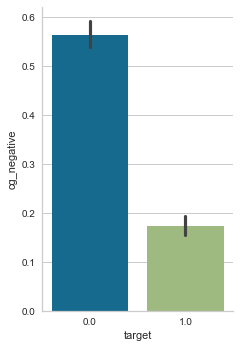

In [177]:
sns.catplot(x="target", y="cg_negative",
                data=df, kind="bar",
                 aspect=.7)

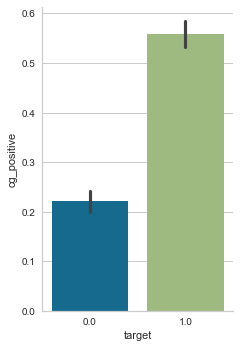

In [178]:
sns.catplot(x="target", y="cg_positive",
                data=df, kind="bar",
                 aspect=.7)



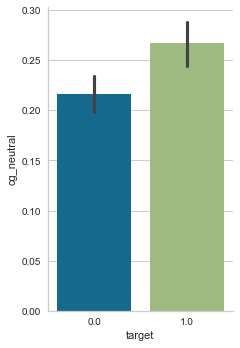

In [179]:
sns.catplot(x="target", y="cg_neutral",
                data=df, kind="bar",
                 aspect=.7)

### Modèle Simple : Regression logistique VS RandomForest

Nous séparons notre jeu de données en train et en test

In [10]:
def pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()
    X=data2[["cg_positive", "cg_neutral", "cg_negative"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

Nous voulons détecter les commentaires négéatifs pour pouvoir agir. Nous allons créer une nouvelle métrique dans laquelle nous allons donc accentuer la non détection des commentaires négatifs.

Nous testons deux méthodes : Regression logistique et l'arbre de decision : Random forest

Pour cela, nous utilisons Hyperopt pour choisir les meilleures paramètres possibles

In [24]:
import mlflow
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
# fonction pour diviser le dataframe en training set
def step1_ech(df):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
    return X_train, X_test, y_train, y_test

####score pour fonction metier >> on veut detecter les commentaires negatives afin de pouvoir agir, nous accentuons donc le poids pour les Faux negatifs.
def fmetric_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.1+FP*0.9)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier

metric_history = []
best_metric_history_n = []
feat_imp_df = pd.DataFrame()
feat_imp_df_history = []


###creation de fonction pour le tuning des hyperparamètres
def objective(params, X, y):
    gc.collect()
    print("------------------------------------------------")
    print("--------------params : ", params)
    #del params['type']
    classifier_type = params['type']
    #maxd=params['max_depthg']
    #del params['max_depthg']
    del params['type']
    
    ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
        
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    feat_imp_df = pd.DataFrame()

    auc_fold=[]
    metier_fold=[]
    cv = StratifiedKFold(n_splits=3)
    i=1
    t0 = time.time()
    for train_idx, test_idx, in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

                #standardisation
        std_scale = StandardScaler().fit(X_train)
        X_train = std_scale.fit_transform(X_train)
        clf.fit(X_train, y_train)  
            
        y_prob = clf.predict_proba(X_test)[:,1] 
                
        # On créé un vecteur de prédiction à partir du vecteur de probabilités
        y_pred = np.where(y_prob > 0.5, 1, 0) 
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        metier_c=fmetric_metier(y_test, y_pred)
        auc_fold.append(roc_auc)
        metier_fold.append(metier_c)
        print(f'For fold {i}:')
        print(f'AUC: {roc_auc}')
        print(f'f1-score: {metrics.f1_score(y_test, y_pred)}')
        print(f'score métier:{metier_c}')
        fold_importance_df = pd.DataFrame()
        if (classifier_type != 'logreg'):
            fold_importance_df["classifier_type"] = classifier_type
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            if len(feat_imp_df)>0:
                feat_imp_df = pd.concat([feat_imp_df, fold_importance_df], axis=0)
            else:
                feat_imp_df = fold_importance_df
                feat_imp_df_history.append(feat_imp_df)
        gc.collect()
        i+=1
        
    time_res=time.time() - t0
    auc_m=np.mean(auc_fold)
    metier=np.mean(metier_fold)
    print("metric auc moyenne :", auc_m)
    print("taux metier moyen :", metier)
    print("temps calcul :", time_res)

    if len(best_metric_history_n)>0:
        best_metric = max(best_metric_history_n)
    else:
        best_metric=auc_m

    print("best_metric : ", best_metric)
    if auc_m > best_metric:
        best_metric=auc_m

    metric_history.append({'classifier_type':classifier_type, 'auc':auc_m,'metier':metier, 'time':time_res, 'params':params})
    best_metric_history_n.append(best_metric)

    #Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': 1-auc_m, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    {
        'type': 'rf',
        'max_depth': hp.choice('max_depth', range(3,10)),
        'n_estimators': hp.choice('n_estimators', range(100,300)),#nb d'arbres dans la forêt
        'max_features': hp.choice('max_features', range(1, 3)),#nb de variables max pour diviser un noeud
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1,0.4), #nb de points de données placées dans un noeud avec qu'il soit divisé
        'min_samples_split': hp.choice('min_samples_split', range(2,12)) #nb minimal de points de données autorisées dans un noeud de feuille
       # 'criterion': hp.choice('criterion', ['gini', 'entropy'])
        #bootstrap > avec ou sans remplacement
    },
    {
        'type': 'logreg',
        'C': hp.uniform('LR_C', 0.1,1.0), # force de la penalité
        'solver': hp.choice('solver', ['liblinear']),#, 'lbfgs'
        'penalty' : hp.choice('penalty', ['l1','l2'])
    }
])


#Nous allons restreindre les colonnes sur la regression logistique, nous testerons les features obtenues grâce aux méthodes statistiques et celles sorties via le LGBM.
def score_model(X_train, y_train):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    scores = []
    i=0
    print("------------------------------------------")
    ###hyperopt tuning
    with mlflow.start_run():
            best_result = fmin(
                                partial(objective, 
                                        X=X_train, 
                                        y=y_train),
                                    space=search_space,
                                    algo=tpe.suggest,
                                    max_evals=10
                                    #trials=SparkTrials()
            )
    gc.collect()
    scores.append(best_result)
    return np.array(scores)


def SearchModel(df, target):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test=step1_ech(df)
    result=score_model(X_train, y_train)
    return result, X_train, y_train, X_test, y_test

In [25]:
result, X_train, y_train, X_test, y_test = SearchModel(df, "target")

------------------------------------------
------------------------------------------------      
--------------params :                                
{'C': 0.23355134504657385, 'penalty': 'l2', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                
0.1417789757412399                                    
For fold 1:                                           
AUC: 0.7455655713870312                               
f1-score: 0.7614213197969544                          
score métier:0.1417789757412399                       
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                
0.20458221024258758                                   
For fold 2:                                           
AUC: 0.7182175050886885                               
f1-score: 0.7664399092970521                          
score métier:0.20458221024258758                      
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                
0.15864864864864864                                   
For fold 3:                                           
AUC: 0.7305555555555555                               
f1-score: 0.7543424317617866                          
score métier:0.15864864864864864                      
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                  
0.7314462106770918                                    
taux metier moyen :                                   
0.1683366115441587                                    
temps calcul :                                        
0.8252496719360352                                    
best_metric :                                         
0.7314462106770918                                    
------------------------------------------------                                
--------------params :                                                          
{'C': 0.6996001358561512, 'penalty': 'l1', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                                          
0.08436657681940701                                                             
For fold 1:                                                                     
AUC: 0.7412038383250945                                                

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.1293800539083558                                                              
For fold 2:                                                                     
AUC: 0.7410875254434429                                                         
f1-score: 0.7473684210526316                                                    
score métier:0.1293800539083558                                                 
 10%|█         | 1/10 [00:01<00:09,  1.09s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.09945945945945946                                                             
For fold 3:                                                                     
AUC: 0.7005847953216374                                                         
f1-score: 0.6626506024096386                                                    
score métier:0.09945945945945946                                                
 10%|█         | 1/10 [00:02<00:09,  1.09s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                                            
0.7276253863633917                                                              
taux metier moyen :                                                             
0.10440203006240743                                                             
temps calcul :                                                                  
1.0384292602539062                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.2250601624134342, 'min_samples_split': 2, 'n_estimators': 282, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.1657681940700809                                                              
For fold 2:                                                                     
AUC: 0.6787292817679558                                                         
f1-score: 0.6909090909090909                                                    
score métier:0.1657681940700809                                                 
 20%|██        | 2/10 [00:04<00:09,  1.21s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.13648648648648648                                                             
For fold 3:                                                                     
AUC: 0.6745614035087719                                                         
f1-score: 0.6591549295774648                                                    
score métier:0.13648648648648648                                                
 20%|██        | 2/10 [00:05<00:09,  1.21s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.6752318180349585                                                              
taux metier moyen :                                                             
0.14765182972730143                                                             
temps calcul :                                                                  
3.1004068851470947                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 0.2227807505469715, 'min_samples_split': 5, 'n_estimators': 237, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.05121293800539083                                                             
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.05121293800539083                                                
 30%|███       | 3/10 [00:07<00:15,  2.22s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.051351351351351354                                                            
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.051351351351351354                                               
 30%|███       | 3/10 [00:08<00:15,  2.22s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.05125907578737767                                                             
temps calcul :                                                                  
2.4285216331481934                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 0.2082399000033839, 'min_samples_split': 9, 'n_estimators': 134, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.14150943396226415                                                             
For fold 2:                                                                     
AUC: 0.6854318115731317                                                         
f1-score: 0.6794520547945206                                                    
score métier:0.14150943396226415                                                
 40%|████      | 4/10 [00:09<00:14,  2.43s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.09027027027027029                                                             
For fold 3:                                                                     
AUC: 0.6646198830409357                                                         
f1-score: 0.588235294117647                                                     
score métier:0.09027027027027029                                                
 40%|████      | 4/10 [00:10<00:14,  2.43s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.6748451854005794                                                              
taux metier moyen :                                                             
0.0983740074306112                                                              
temps calcul :                                                                  
1.4786481857299805                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 0.1776268410539253, 'min_samples_split': 3, 'n_estimators': 214, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.05121293800539083                                                             
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.05121293800539083                                                
 50%|█████     | 5/10 [00:11<00:10,  2.18s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.051351351351351354                                                            
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.051351351351351354                                               
 50%|█████     | 5/10 [00:12<00:10,  2.18s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.05125907578737767                                                             
temps calcul :                                                                  
1.9182014465332031                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.13777374837122203, 'min_samples_split': 3, 'n_estimators': 162, 'type': 'rf'}
FULL Métrique Métier :                                

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.09218328840970351                                                             
For fold 2:                                                                     
AUC: 0.6858098284384995                                                         
f1-score: 0.628930817610063                                                     
score métier:0.09218328840970351                                                
 60%|██████    | 6/10 [00:13<00:08,  2.20s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.061621621621621624                                                            
For fold 3:                                                                     
AUC: 0.6090643274853801                                                         
f1-score: 0.4126984126984127                                                    
score métier:0.061621621621621624                                               
 60%|██████    | 6/10 [00:14<00:08,  2.20s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.6598305924418165                                                              
taux metier moyen :                                                             
0.07417935455671305                                                             
temps calcul :                                                                  
1.5849978923797607                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'C': 0.2986530401866129, 'penalty': 'l2', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                                          
0.1417789757412399       

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.20458221024258758                                                             
For fold 2:                                                                     
AUC: 0.7182175050886885                                                         
f1-score: 0.7664399092970521                                                    
score métier:0.20458221024258758                                                
 70%|███████   | 7/10 [00:14<00:06,  2.08s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.1562162162162162                                                              
For fold 3:                                                                     
AUC: 0.7333333333333334                                                         
f1-score: 0.7562189054726367                                                    
score métier:0.1562162162162162                                                 
 70%|███████   | 7/10 [00:15<00:06,  2.08s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                                            
0.7323721366030177                                                              
taux metier moyen :                                                             
0.16752580073334788                                                             
temps calcul :                                                                  
0.6945886611938477                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.309764679582077, 'min_samples_split': 4, 'n_estimators': 129, 'type': 'rf'}
FULL Métrique Métier :                                  

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.05121293800539083                                                             
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.05121293800539083                                                
 80%|████████  | 8/10 [00:16<00:03,  1.71s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.051351351351351354                                                            
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.051351351351351354                                               
 80%|████████  | 8/10 [00:16<00:03,  1.71s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.05125907578737767                                                             
temps calcul :                                                                  
1.2763583660125732                                                              
best_metric :                                                                   
0.7323721366030177                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 0.3379142387144206, 'min_samples_split': 5, 'n_estimators': 136, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.4390835579514825                                                              
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.6773618538324421                                                    
score métier:0.4390835579514825                                                 
 90%|█████████ | 9/10 [00:17<00:01,  1.66s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.43783783783783786                                                             
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.6785714285714285                                                    
score métier:0.43783783783783786                                                
 90%|█████████ | 9/10 [00:18<00:01,  1.66s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.438668317913601                                                               
temps calcul :                                                                  
1.2330029010772705                                                              
best_metric :                                                                   
0.7323721366030177                                                              
100%|██████████| 10/10 [00:18<00:00,  1.83s/trial, best loss: 0.2676278633969823]


In [21]:
metric_history

[{'classifier_type': 'rf',
  'auc': 0.546832358674464,
  'metier': 0.24802675991355239,
  'time': 1.4449489116668701,
  'params': {'max_depth': 5,
   'max_features': 1,
   'min_samples_leaf': 0.27236264301515356,
   'min_samples_split': 7,
   'n_estimators': 109}},
 {'classifier_type': 'rf',
  'auc': 0.6696439533456108,
  'metier': 0.07031737937398315,
  'time': 2.717998743057251,
  'params': {'max_depth': 6,
   'max_features': 1,
   'min_samples_leaf': 0.11248992486751819,
   'min_samples_split': 6,
   'n_estimators': 286}},
 {'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.438668317913601,
  'time': 2.2539877891540527,
  'params': {'max_depth': 6,
   'max_features': 2,
   'min_samples_leaf': 0.3965926573794545,
   'min_samples_split': 4,
   'n_estimators': 130}},
 {'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.438668317913601,
  'time': 1.783200740814209,
  'params': {'max_depth': 9,
   'max_features': 2,
   'min_samples_leaf': 0.3471644892065293,
   'min_samples_split': 

In [26]:
df_metrics_history=pd.DataFrame(metric_history).reset_index()

In [27]:
df_metrics_history

index classifier_type       auc    metier      time  \
0      0          logreg  0.731446  0.168337  0.825250   
1      1          logreg  0.727625  0.104402  1.038429   
2      2              rf  0.675232  0.147652  3.100407   
3      3              rf  0.500000  0.051259  2.428522   
4      4              rf  0.674845  0.098374  1.478648   
5      5              rf  0.500000  0.051259  1.918201   
6      6              rf  0.659831  0.074179  1.584998   
7      7          logreg  0.732372  0.167526  0.694589   
8      8              rf  0.500000  0.051259  1.276358   
9      9              rf  0.500000  0.438668  1.233003   

                                              params  
0  {'C': 0.23355134504657385, 'penalty': 'l2', 's...  
1  {'C': 0.6996001358561512, 'penalty': 'l1', 'so...  
2  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
3  {'max_depth': 5, 'max_features': 2, 'min_sampl...  
4  {'max_depth': 4, 'max_features': 1, 'min_sampl...  
5  {'max_depth': 7, 'max_features': 2, 'min_sampl...  
6  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
7  {'C': 0.2986530401866129, 'penalty': 'l2', 'so...  
8  {'max_depth': 8, 'max_features': 2, 'min_sampl...  
9  {'max_depth': 7, 'max_features': 1, 'min_sampl...

In [28]:
train_graph=df_metrics_history.copy()

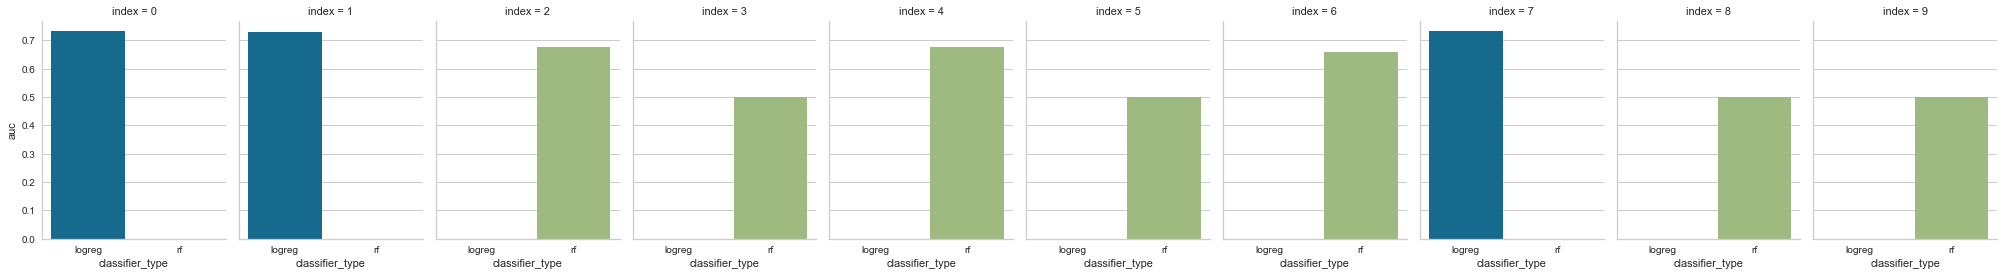

In [29]:
sns.catplot(x="classifier_type", y="auc", col="index",
                data=train_graph, kind="bar",
                height=4, aspect=.7)

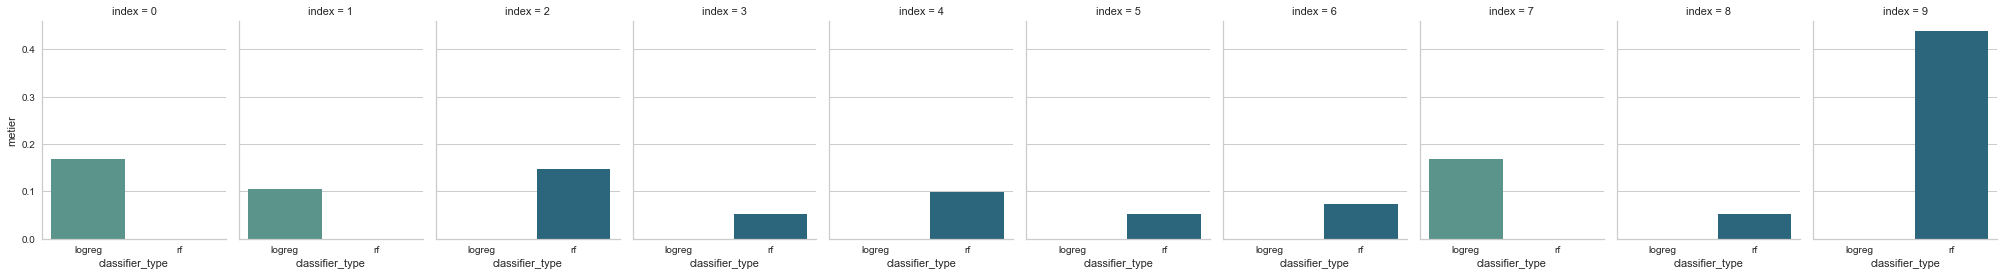

In [30]:
sns.catplot(x="classifier_type", y="metier",
                col="index",orient="v",
                data=train_graph, kind="bar",palette="crest",
                height=4, aspect=.7)

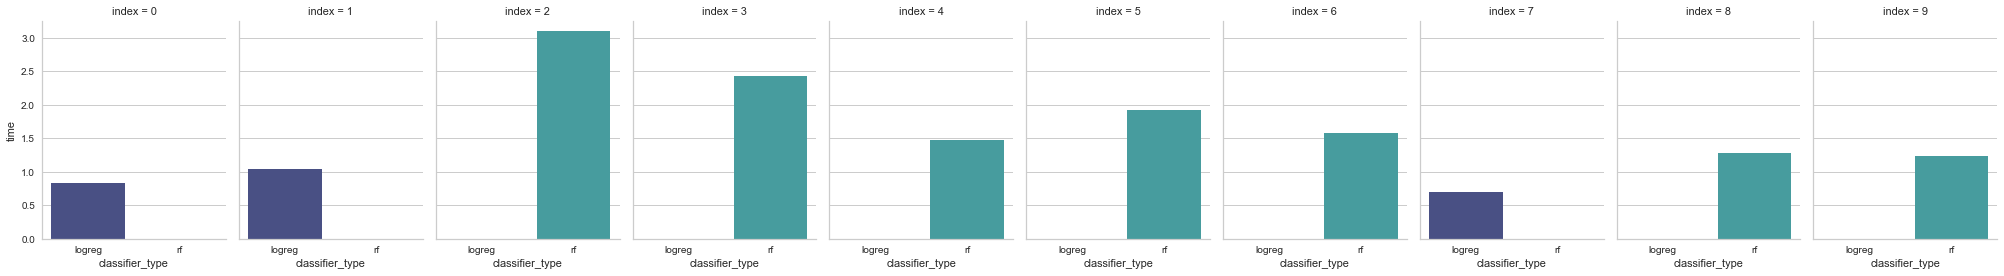

In [31]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=train_graph, kind="bar",palette='mako',
                height=4, aspect=.7)

In [32]:
import joblib

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe Roc')
    plt.legend()
    plt.show()


def pipeline_training_metrics(y_prob, y_test):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.1+FP*0.9)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #

def result_compare_model(df_best_score_history):
    all_bestscore_history=[]
    i=0
    for item in df_best_score_history.itertuples():
        res = compare_best_model(i, item.classifier_type, item.params, X_train, y_train, X_test, y_test)
        all_bestscore_history.append(res)
        i=i+1
    return pd.DataFrame(all_bestscore_history)

def compare_best_model(i,classifier_type, params, X_train, y_train, X_test, y_test):
   ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
    
    print(params)
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    
    t0 = time.time()
             
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:,1] 
    
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    metier_c=fmetric_metier(y_test, y_pred)
    pipeline_training_metrics(y_pred, y_test)
    time_res=time.time() - t0
    return {'classifier_type':classifier_type, 'score':roc_auc,'metier':metier_c,'time': time_res, 'params':params}

In [40]:
df_metrics_history

index classifier_type       auc    metier      time  \
0      0          logreg  0.731446  0.168337  0.825250   
1      1          logreg  0.727625  0.104402  1.038429   
2      2              rf  0.675232  0.147652  3.100407   
3      3              rf  0.500000  0.051259  2.428522   
4      4              rf  0.674845  0.098374  1.478648   
5      5              rf  0.500000  0.051259  1.918201   
6      6              rf  0.659831  0.074179  1.584998   
7      7          logreg  0.732372  0.167526  0.694589   
8      8              rf  0.500000  0.051259  1.276358   
9      9              rf  0.500000  0.438668  1.233003   

                                              params  
0  {'C': 0.23355134504657385, 'penalty': 'l2', 's...  
1  {'C': 0.6996001358561512, 'penalty': 'l1', 'so...  
2  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
3  {'max_depth': 5, 'max_features': 2, 'min_sampl...  
4  {'max_depth': 4, 'max_features': 1, 'min_sampl...  
5  {'max_depth': 7, 'max_features': 2, 'min_sampl...  
6  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
7  {'C': 0.2986530401866129, 'penalty': 'l2', 'so...  
8  {'max_depth': 8, 'max_features': 2, 'min_sampl...  
9  {'max_depth': 7, 'max_features': 1, 'min_sampl...

{'C': 0.23355134504657385, 'penalty': 'l2', 'solver': 'liblinear'}
FULL Métrique Métier :  0.15387840670859537
0.7559055812149633


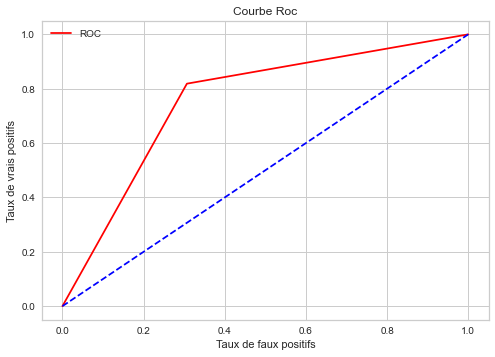

FULL Métrique Métier :  0.15387840670859537
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


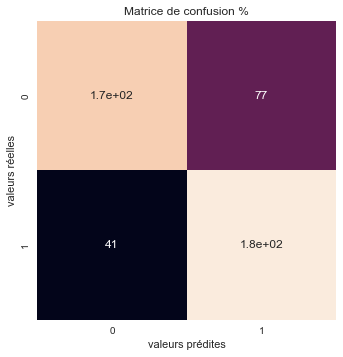

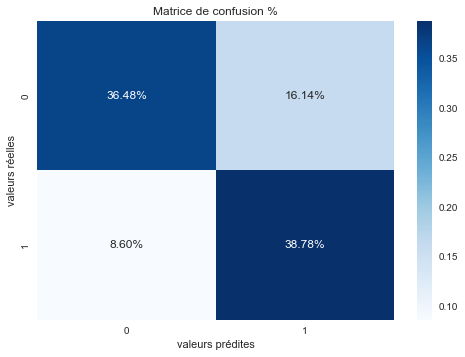


Sur le jeu de test auc : 0.756

Sur le jeu de test f1_score : 0.758

Sur le jeu de test precision : 0.706

Sur le jeu de test recall : 0.819
{'C': 0.6996001358561512, 'penalty': 'l1', 'solver': 'liblinear'}
FULL Métrique Métier :  0.15387840670859537
0.7559055812149633


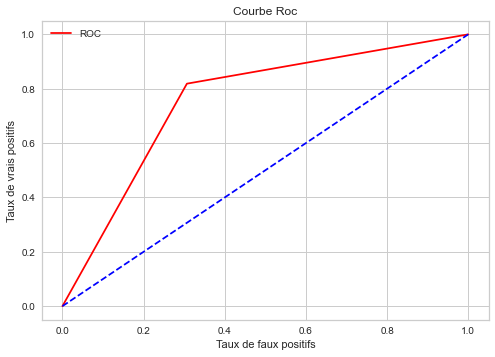

FULL Métrique Métier :  0.15387840670859537
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


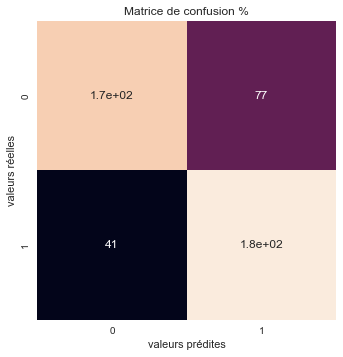

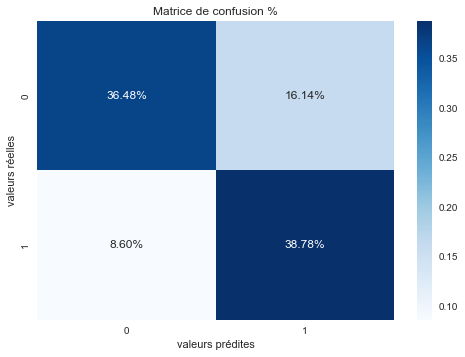


Sur le jeu de test auc : 0.756

Sur le jeu de test f1_score : 0.758

Sur le jeu de test precision : 0.706

Sur le jeu de test recall : 0.819
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.2250601624134342, 'min_samples_split': 2, 'n_estimators': 282}
FULL Métrique Métier :  0.1387840670859539
0.753922363642774


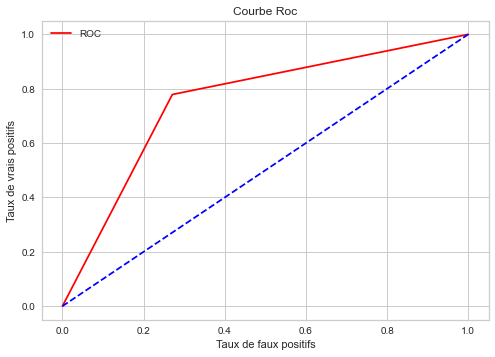

FULL Métrique Métier :  0.1387840670859539
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


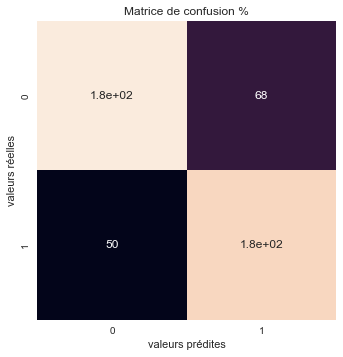

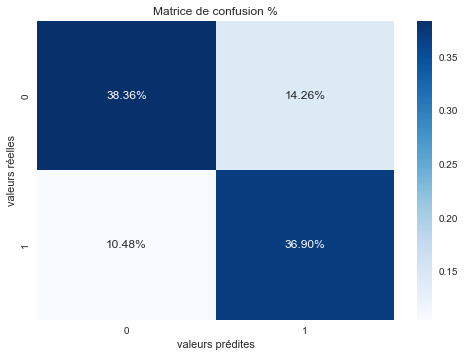


Sur le jeu de test auc : 0.754

Sur le jeu de test f1_score : 0.749

Sur le jeu de test precision : 0.721

Sur le jeu de test recall : 0.779
{'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 0.2227807505469715, 'min_samples_split': 5, 'n_estimators': 237}
FULL Métrique Métier :  0.13354297693920336
0.755473680499242


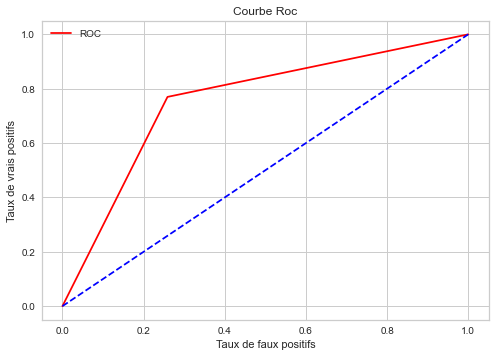

FULL Métrique Métier :  0.13354297693920336
Mean Absolute Error: 0.24528301886792453
Mean Squared Error: 0.24528301886792453
Root Mean Squared Error: 0.4952605565436486


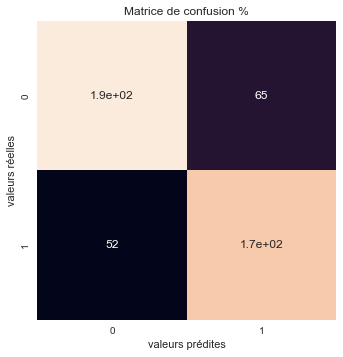

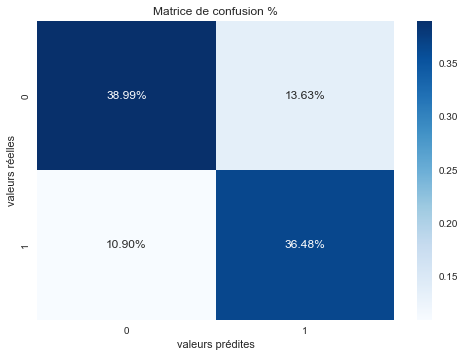


Sur le jeu de test auc : 0.755

Sur le jeu de test f1_score : 0.748

Sur le jeu de test precision : 0.728

Sur le jeu de test recall : 0.770
{'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 0.2082399000033839, 'min_samples_split': 9, 'n_estimators': 134}
FULL Métrique Métier :  0.14067085953878405
0.7519303317702641


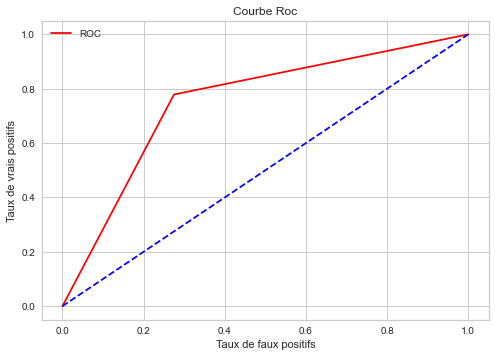

FULL Métrique Métier :  0.14067085953878405
Mean Absolute Error: 0.24947589098532494
Mean Squared Error: 0.24947589098532494
Root Mean Squared Error: 0.49947561600675255


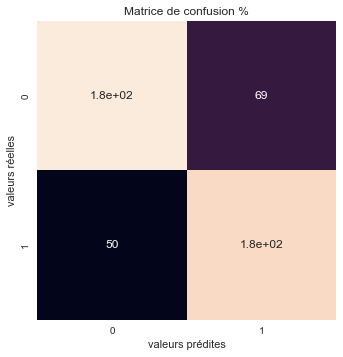

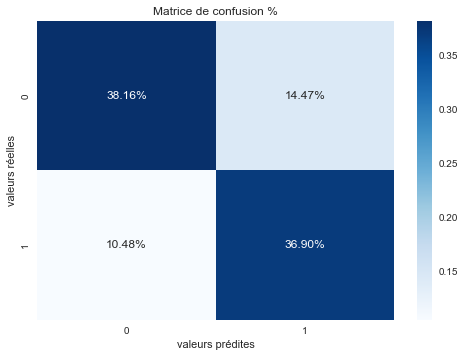


Sur le jeu de test auc : 0.752

Sur le jeu de test f1_score : 0.747

Sur le jeu de test precision : 0.718

Sur le jeu de test recall : 0.779
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 0.1776268410539253, 'min_samples_split': 3, 'n_estimators': 214}
FULL Métrique Métier :  0.13731656184486374
0.7514896167542221


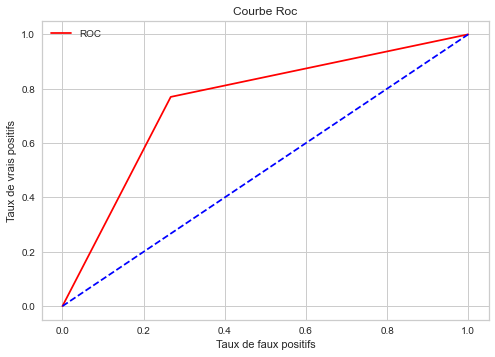

FULL Métrique Métier :  0.13731656184486374
Mean Absolute Error: 0.24947589098532494
Mean Squared Error: 0.24947589098532494
Root Mean Squared Error: 0.49947561600675255


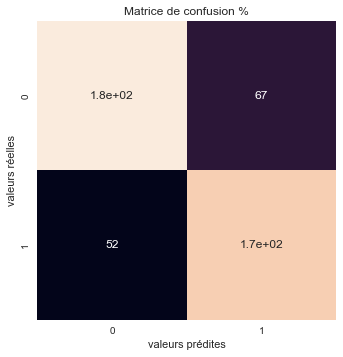

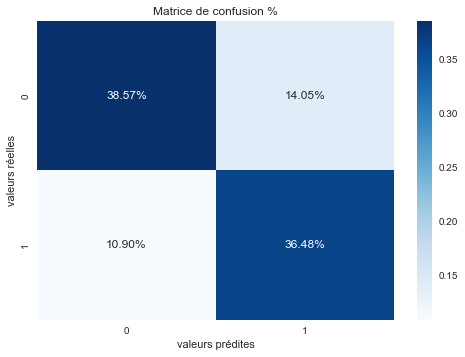


Sur le jeu de test auc : 0.751

Sur le jeu de test f1_score : 0.745

Sur le jeu de test precision : 0.722

Sur le jeu de test recall : 0.770
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.13777374837122203, 'min_samples_split': 3, 'n_estimators': 162}
FULL Métrique Métier :  0.14821802935010484
0.7439622042802242


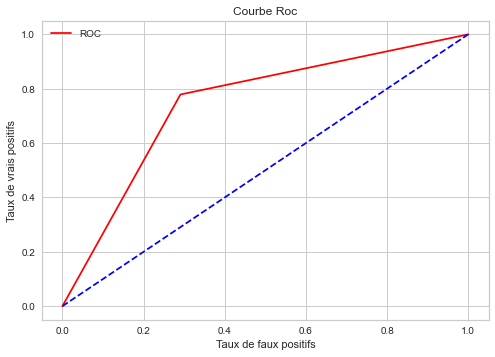

FULL Métrique Métier :  0.14821802935010484
Mean Absolute Error: 0.2578616352201258
Mean Squared Error: 0.2578616352201258
Root Mean Squared Error: 0.5078007830046403


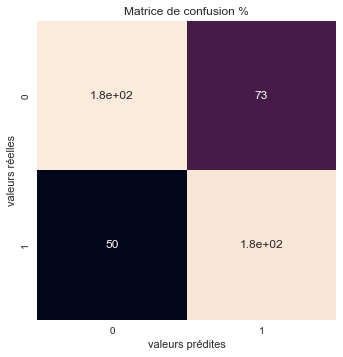

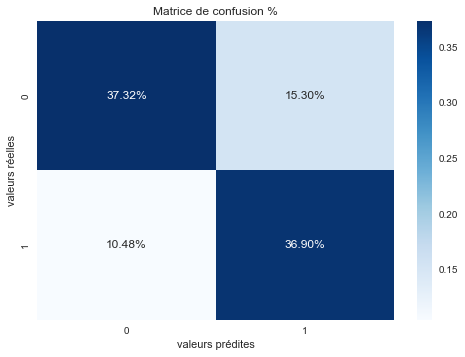


Sur le jeu de test auc : 0.744

Sur le jeu de test f1_score : 0.741

Sur le jeu de test precision : 0.707

Sur le jeu de test recall : 0.779
{'C': 0.2986530401866129, 'penalty': 'l2', 'solver': 'liblinear'}
FULL Métrique Métier :  0.15387840670859537
0.7559055812149633


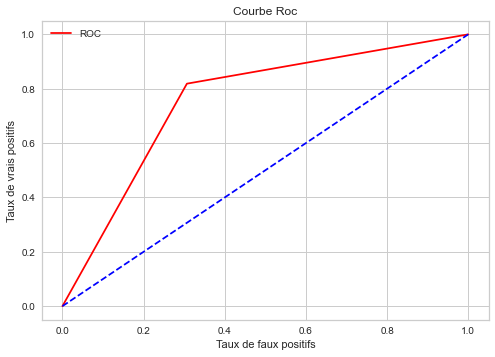

FULL Métrique Métier :  0.15387840670859537
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


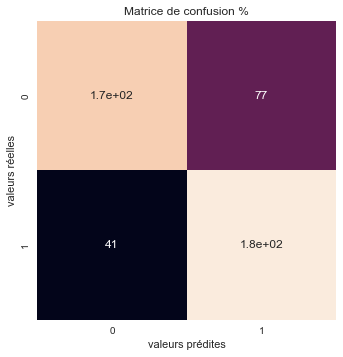

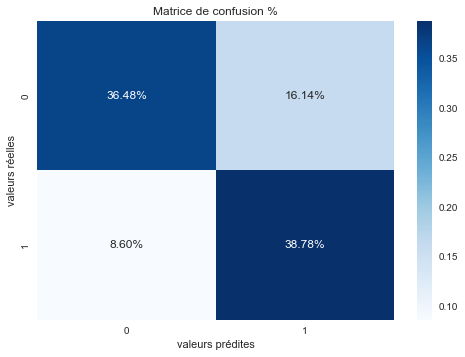


Sur le jeu de test auc : 0.756

Sur le jeu de test f1_score : 0.758

Sur le jeu de test precision : 0.706

Sur le jeu de test recall : 0.819
{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.309764679582077, 'min_samples_split': 4, 'n_estimators': 129}
FULL Métrique Métier :  0.12515723270440252
0.7543718929591369


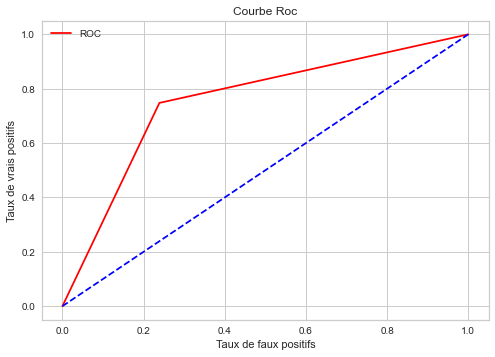

FULL Métrique Métier :  0.12515723270440252
Mean Absolute Error: 0.24528301886792453
Mean Squared Error: 0.24528301886792453
Root Mean Squared Error: 0.4952605565436486


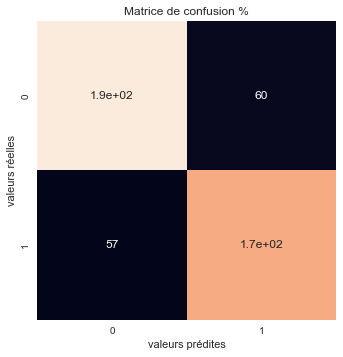

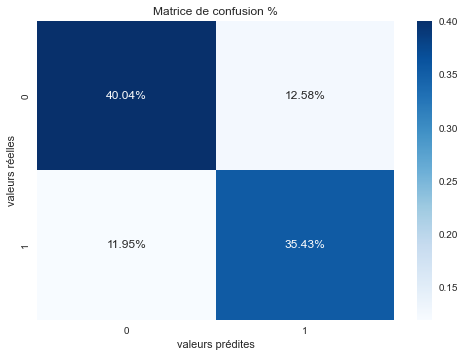


Sur le jeu de test auc : 0.754

Sur le jeu de test f1_score : 0.743

Sur le jeu de test precision : 0.738

Sur le jeu de test recall : 0.748
{'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 0.3379142387144206, 'min_samples_split': 5, 'n_estimators': 136}
FULL Métrique Métier :  0.47358490566037736
0.5


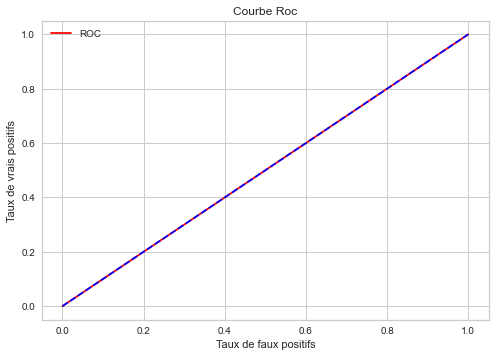

FULL Métrique Métier :  0.47358490566037736
Mean Absolute Error: 0.5262054507337526
Mean Squared Error: 0.5262054507337526
Root Mean Squared Error: 0.7254002003954456


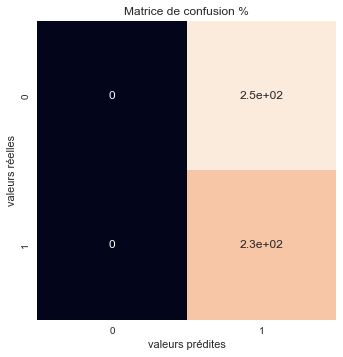

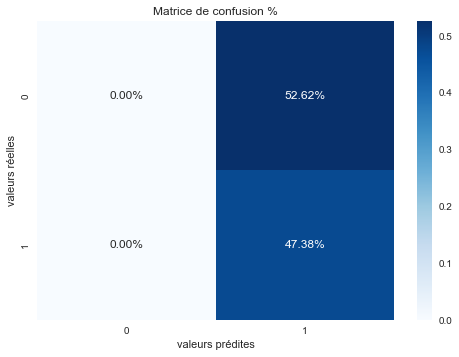


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.643

Sur le jeu de test precision : 0.474

Sur le jeu de test recall : 1.000


In [33]:
final_result=result_compare_model(df_metrics_history)

In [34]:
final_result = final_result.reset_index()

In [35]:

data=final_result.copy()



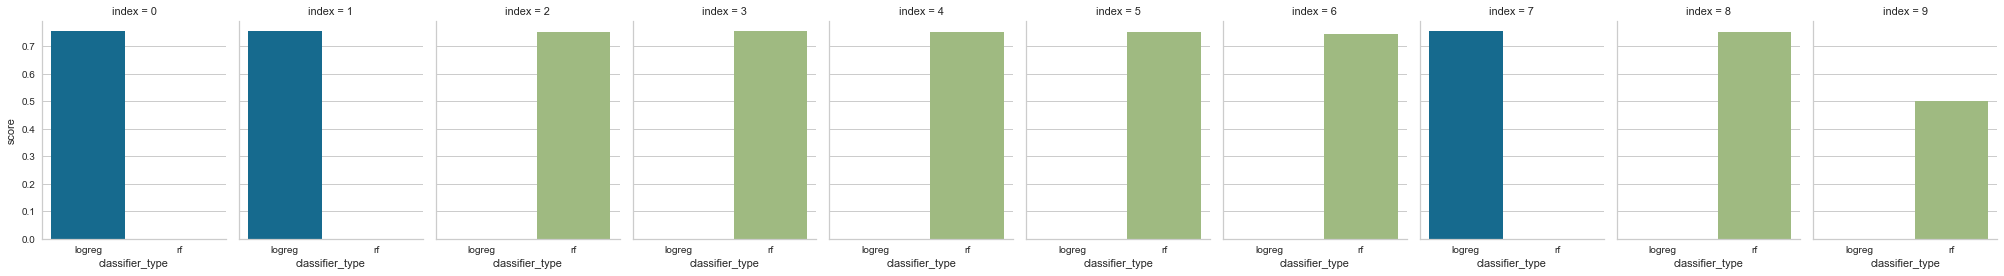

In [36]:
sns.catplot(x="classifier_type", y="score",
                col="index",
                data=data, kind="bar",
                height=4, aspect=.7)

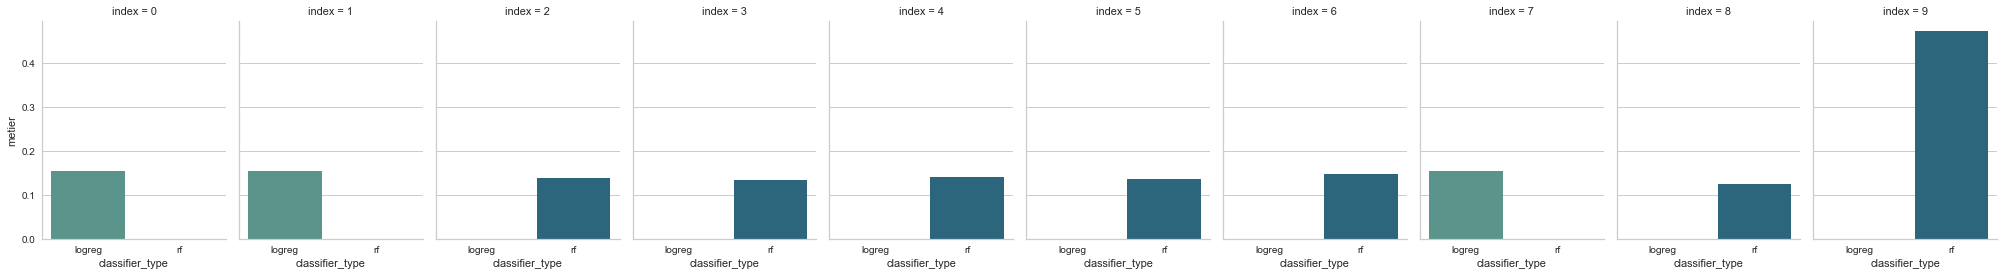

In [37]:
sns.catplot(x="classifier_type", y="metier",
                col="index",
                data=data, kind="bar",palette="crest",
                height=4, aspect=.7)

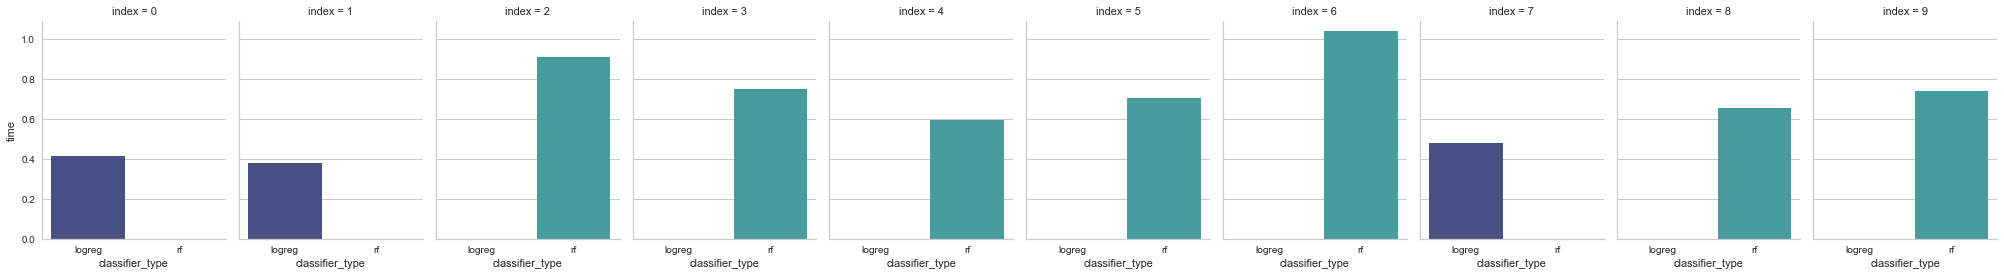

In [38]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=data, kind="bar",palette="mako",
                height=4, aspect=.7)

In [39]:
final_result

index classifier_type     score    metier      time  \
0      0          logreg  0.755906  0.153878  0.415999   
1      1          logreg  0.755906  0.153878  0.380997   
2      2              rf  0.753922  0.138784  0.910601   
3      3              rf  0.755474  0.133543  0.748651   
4      4              rf  0.751930  0.140671  0.595245   
5      5              rf  0.751490  0.137317  0.704485   
6      6              rf  0.743962  0.148218  1.039997   
7      7          logreg  0.755906  0.153878  0.481996   
8      8              rf  0.754372  0.125157  0.655226   
9      9              rf  0.500000  0.473585  0.738204   

                                              params  
0  {'C': 0.23355134504657385, 'penalty': 'l2', 's...  
1  {'C': 0.6996001358561512, 'penalty': 'l1', 'so...  
2  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
3  {'max_depth': 5, 'max_features': 2, 'min_sampl...  
4  {'max_depth': 4, 'max_features': 1, 'min_sampl...  
5  {'max_depth': 7, 'max_features': 2, 'min_sampl...  
6  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
7  {'C': 0.2986530401866129, 'penalty': 'l2', 'so...  
8  {'max_depth': 8, 'max_features': 2, 'min_sampl...  
9  {'max_depth': 7, 'max_features': 1, 'min_sampl...

### Choix :  Random forest (numéro 8)

In [45]:
import joblib

def result_save_model(df_best_score_history, num_choice):
    all_bestscore_history=[]
    i=0
    for item in df_best_score_history.itertuples():
        if item.index==num_choice:
            save_best_model(i, item.classifier_type, item.params, X_train, y_train)

def save_best_model(i,classifier_type, params, X_train, y_train):
   ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
    
    print(params)
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0    
    clf.fit(X_train, y_train)
    joblib.dump(clf, "output/models/method1/my_random_forest.pkl")
    print("ok")

In [46]:
result_save_model(final_result, 8)

{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.309764679582077, 'min_samples_split': 4, 'n_estimators': 129}
ok


In [48]:
X_train

cg_positive  cg_neutral  cg_negative
53           0.43        0.06         0.51
486          0.07        0.01         0.92
142          0.01        0.14         0.84
852          0.14        0.78         0.08
1137         0.55        0.44         0.01
...           ...         ...          ...
924          0.66        0.32         0.03
1247         0.98        0.00         0.02
271          0.01        0.17         0.82
474          0.58        0.06         0.35
1379         0.13        0.83         0.05

[1112 rows x 3 columns]

In [51]:
##

#import joblib
#from sklearn.ensemble import RandomForestClassifier


# save
#joblib.dump(rf, "my_random_forest.joblib")

# load
loaded_rf = joblib.load("output/models/method1/my_random_forest.pkl")
#loaded_rf.predict(X)

In [58]:
d = {'cg_positive': [0.06], 'cg_neutral': [0.22], 'cg_negative': [0.72]}

In [59]:
Xd= pd.DataFrame(d)

In [60]:
y_hat = loaded_rf.predict(Xd)

In [61]:
y_hat

array([0.])